In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [2]:
from data.dataset import CoDeTM4

In [3]:
train, val, test  = CoDeTM4('../../data/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)

In [4]:
from datasets import concatenate_datasets

In [5]:
codet = concatenate_datasets([train, val, test])

In [6]:
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER, JAVA_PARSER, CPP_PARSER = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)

In [7]:
import matplotlib.pyplot as plt

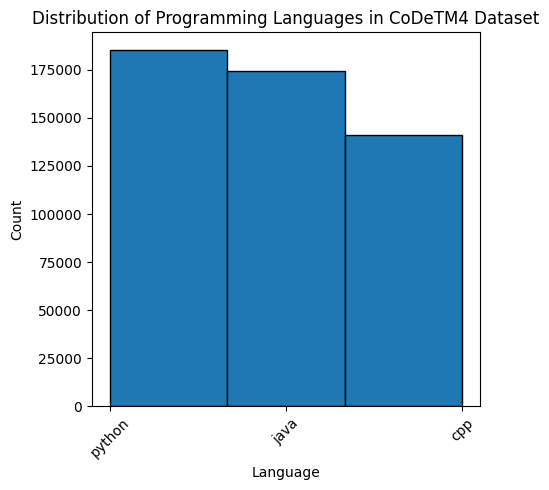

Python count: 185163
Java count: 174169
C++ count: 141220


In [8]:
language_counts = codet['language']
plt.figure(figsize=(5, 5))
plt.hist(language_counts, bins=len(set(language_counts)), edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in CoDeTM4 Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

python_count = language_counts.count("python")
java_count = language_counts.count("java")
cpp_count = language_counts.count("cpp")

print(f'Python count: {python_count}')
print(f'Java count: {java_count}')
print(f'C++ count: {cpp_count}')

In [9]:
def get_parser(language):
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")

In [10]:
def create_tree(sample, code_key='cleaned_code'):
    language = sample['language']
    parser = get_parser(language)
    tree = parser.parse(bytes(sample[code_key], 'utf-8'))
    return tree

In [11]:
from tree_sitter import TreeCursor

def walk_tree(cursor: TreeCursor, depth=0):
    indent = '  ' * depth
    print(f"{indent}{cursor.node.type}")

    if cursor.goto_first_child():
        walk_tree(cursor, depth+1)
    
        while cursor.goto_next_sibling():
            walk_tree(cursor, depth+1)

        cursor.goto_parent()

In [12]:
from typing import Set

def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
    if types is None:
        types = set()
    
    types.add(cursor.node.type)

    if cursor.goto_first_child():
        get_node_types_from_tree(cursor, types)
    
        while cursor.goto_next_sibling():
            get_node_types_from_tree(cursor, types)

        cursor.goto_parent()

    return types

In [13]:
def extract_types(sample):
    # Import everything needed inside the function
    import tree_sitter_python as tspython
    import tree_sitter_cpp as tscpp
    import tree_sitter_java as tsjava
    from tree_sitter import Parser, Language, TreeCursor
    from typing import Set
    
    # Create parsers locally
    TS_PYTHON = Language(tspython.language())
    TS_JAVA = Language(tsjava.language())
    TS_CPP = Language(tscpp.language())
    
    PYTHON_PARSER = Parser(language=TS_PYTHON)
    JAVA_PARSER = Parser(language=TS_JAVA)
    CPP_PARSER = Parser(language=TS_CPP)
    
    def get_parser(language):
        match language:
            case 'python':
                return PYTHON_PARSER
            case 'java':
                return JAVA_PARSER
            case 'cpp':
                return CPP_PARSER
        raise ValueError(f"Unsupported language: {language}")
    
    def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
        if types is None:
            types = set()
        
        types.add(cursor.node.type)

        if cursor.goto_first_child():
            get_node_types_from_tree(cursor, types)
        
            while cursor.goto_next_sibling():
                get_node_types_from_tree(cursor, types)

            cursor.goto_parent()

        return types
    
    parser = get_parser(sample['language'])
    tree = parser.parse(sample['cleaned_code'].encode('utf-8'))
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types)}

result = codet.map(extract_types, batched=False, num_proc=8)

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)

print(f"Collected {len(all_types)} unique node types")

# # Below code doesn't work on windows due to different multiprocessing logic udner the hood
# def extract_types(sample):
#     parser = get_parser(sample['language'])
#     tree = parser.parse(sample['cleaned_code'].encode('utf-8'))
#     cursor = tree.walk()
#     types = get_node_types_from_tree(cursor)
#     return {"types": list(types)}

# result = codet.map(extract_types, batched=False, num_proc=8)

# all_types = set()
# for tlist in result['types']:
#     all_types.update(tlist)

# print(f"Collected {len(all_types)} unique node types")

Collected 563 unique node types


In [14]:
all_types = sorted(list(all_types))

In [15]:
type_to_ind = {t: i for i, t in enumerate(all_types)}

In [16]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from tree_sitter import Node

In [17]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from torch import tensor, long as tlong
from tree_sitter import TreeCursor

def tree_to_graph(cursor: TreeCursor, id_map: Dict = None, next_id: int = 0, edges: List[Tuple[int, int]] = None) -> Tuple[List[Tuple[int, int]], Dict, int]:
    if edges is None:
        edges = []
    if id_map is None:
        id_map = {}

    # Assign ID to current node
    if cursor.node not in id_map:
        id_map[cursor.node] = next_id
        next_id += 1
    current_id = id_map[cursor.node]

    if cursor.goto_first_child():
        # Process first child
        if cursor.node not in id_map:
            id_map[cursor.node] = next_id
            next_id += 1
        child_id = id_map[cursor.node]
        edges.append((current_id, child_id))
        edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        # Process siblings
        while cursor.goto_next_sibling():
            if cursor.node not in id_map:
                id_map[cursor.node] = next_id
                next_id += 1
            child_id = id_map[cursor.node]
            edges.append((current_id, child_id))
            edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        cursor.goto_parent()

    return edges, id_map, next_id

In [18]:
from tqdm import tqdm

In [19]:
def create_graph(sample):
    tree = create_tree(sample)
    edges, id_map, _ = tree_to_graph(tree.walk())
    edge_index = tensor(edges, dtype=tlong).t().contiguous()
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = tensor(x, dtype=tlong)
    y = tensor([sample['target_binary']], dtype=tlong)

    graph_features = tensor(list(sample['features'].values()))
    
    metadata = {
        'language': sample['language'],
        'target': sample['target'],
        'target_binary': sample['target_binary'],
        'code': sample['code'],
        'cleaned_code': sample['cleaned_code']
    }
    
    data = Data(
        x=x, 
        y=y, 
        edge_index=edge_index, 
        graph_features=graph_features,
        metadata=metadata
    )    
    return data


In [20]:
codet

Dataset({
    features: ['code', 'language', 'model', 'split', 'target', 'source', 'features', 'cleaned_code', '__index_level_0__', 'target_binary'],
    num_rows: 500552
})

In [21]:
def create_graphs(dataset, desc_keyword):
    graphs = []

    for i, sample in enumerate(tqdm(dataset, desc=f'Creating {desc_keyword} graphs')):
        data = create_graph(sample)
        graphs.append(data)

    return graphs
    

In [22]:
from torch_geometric.data import Data
from torch import save

train_graphs = create_graphs(train, 'train')
save(train_graphs, '../../data/codet_graphs/train_graphs.pt')
del train, train_graphs
val_graphs = create_graphs(val, 'val')
save(val_graphs, '../../data/codet_graphs/val_graphs.pt')
del val, val_graphs
test_graphs = create_graphs(test, 'test')
save(test_graphs, '../../data/codet_graphs/test_graphs.pt')
del test, test_graphs
save(type_to_ind, '../../data/codet_graphs/type_to_ind.pt')

Creating train graphs:   0%|                                                                | 0/405069 [00:00<?, ?it/s]

Creating train graphs:   0%|                                                      | 9/405069 [00:00<1:23:57, 80.41it/s]

Creating train graphs:   0%|                                                    | 238/405069 [00:00<05:22, 1253.46it/s]

Creating train graphs:   0%|                                                    | 463/405069 [00:00<04:09, 1618.54it/s]

Creating train graphs:   0%|                                                    | 665/405069 [00:00<03:56, 1708.39it/s]

Creating train graphs:   0%|                                                    | 888/405069 [00:00<03:40, 1833.45it/s]

Creating train graphs:   0%|▏                                                  | 1129/405069 [00:00<03:28, 1937.61it/s]

Creating train graphs:   0%|▏                                                  | 1342/405069 [00:00<03:28, 1940.79it/s]

Creating train graphs:   0%|▏                                                  | 1547/405069 [00:00<03:25, 1964.59it/s]

Creating train graphs:   0%|▏                                                  | 1769/405069 [00:00<03:23, 1985.16it/s]

Creating train graphs:   0%|▎                                                  | 1997/405069 [00:01<03:20, 2010.03it/s]

Creating train graphs:   1%|▎                                                  | 2215/405069 [00:01<03:20, 2004.83it/s]

Creating train graphs:   1%|▎                                                  | 2430/405069 [00:01<03:24, 1968.25it/s]

Creating train graphs:   1%|▎                                                  | 2646/405069 [00:01<03:24, 1970.24it/s]

Creating train graphs:   1%|▎                                                  | 2854/405069 [00:01<03:26, 1949.64it/s]

Creating train graphs:   1%|▍                                                  | 3096/405069 [00:01<03:20, 2004.84it/s]

Creating train graphs:   1%|▍                                                  | 3318/405069 [00:01<03:19, 2012.25it/s]

Creating train graphs:   1%|▍                                                  | 3546/405069 [00:01<03:17, 2033.83it/s]

Creating train graphs:   1%|▍                                                  | 3766/405069 [00:01<03:19, 2012.89it/s]

Creating train graphs:   1%|▌                                                  | 3994/405069 [00:02<03:14, 2065.77it/s]

Creating train graphs:   1%|▌                                                  | 4232/405069 [00:02<03:10, 2099.02it/s]

Creating train graphs:   1%|▌                                                  | 4443/405069 [00:02<03:15, 2047.86it/s]

Creating train graphs:   1%|▌                                                  | 4653/405069 [00:02<03:18, 2017.55it/s]

Creating train graphs:   1%|▌                                                  | 4858/405069 [00:02<03:22, 1974.37it/s]

Creating train graphs:   1%|▋                                                  | 5068/405069 [00:02<03:19, 2007.70it/s]

Creating train graphs:   1%|▋                                                  | 5304/405069 [00:02<03:15, 2044.52it/s]

Creating train graphs:   1%|▋                                                  | 5509/405069 [00:02<03:17, 2022.86it/s]

Creating train graphs:   1%|▋                                                  | 5748/405069 [00:02<03:12, 2072.42it/s]

Creating train graphs:   1%|▊                                                  | 5970/405069 [00:03<03:13, 2059.52it/s]

Creating train graphs:   2%|▊                                                  | 6176/405069 [00:03<03:14, 2052.39it/s]

Creating train graphs:   2%|▊                                                  | 6418/405069 [00:03<03:09, 2101.45it/s]

Creating train graphs:   2%|▊                                                  | 6644/405069 [00:03<03:10, 2090.67it/s]

Creating train graphs:   2%|▊                                                  | 6865/405069 [00:03<03:11, 2074.19it/s]

Creating train graphs:   2%|▉                                                  | 7073/405069 [00:03<03:13, 2053.86it/s]

Creating train graphs:   2%|▉                                                  | 7298/405069 [00:03<03:13, 2054.86it/s]

Creating train graphs:   2%|▉                                                  | 7530/405069 [00:03<03:11, 2074.92it/s]

Creating train graphs:   2%|▉                                                  | 7769/405069 [00:03<03:08, 2103.28it/s]

Creating train graphs:   2%|█                                                  | 7985/405069 [00:04<03:12, 2064.52it/s]

Creating train graphs:   2%|█                                                  | 8206/405069 [00:04<03:13, 2051.37it/s]

Creating train graphs:   2%|█                                                  | 8430/405069 [00:04<03:13, 2047.58it/s]

Creating train graphs:   2%|█                                                  | 8668/405069 [00:04<03:10, 2086.08it/s]

Creating train graphs:   2%|█                                                  | 8877/405069 [00:04<03:14, 2033.49it/s]

Creating train graphs:   2%|█▏                                                 | 9112/405069 [00:04<03:11, 2068.03it/s]

Creating train graphs:   2%|█▏                                                 | 9320/405069 [00:04<03:13, 2049.68it/s]

Creating train graphs:   2%|█▏                                                 | 9544/405069 [00:04<03:13, 2049.23it/s]

Creating train graphs:   2%|█▏                                                 | 9764/405069 [00:04<03:13, 2037.81it/s]

Creating train graphs:   2%|█▎                                                 | 9968/405069 [00:04<03:14, 2034.18it/s]

Creating train graphs:   3%|█▎                                                | 10173/405069 [00:05<03:18, 1985.17it/s]

Creating train graphs:   3%|█▎                                                | 10378/405069 [00:05<03:22, 1951.42it/s]

Creating train graphs:   3%|█▎                                                | 10592/405069 [00:05<03:21, 1952.98it/s]

Creating train graphs:   3%|█▎                                                | 10833/405069 [00:05<03:16, 2008.71it/s]

Creating train graphs:   3%|█▎                                                | 11050/405069 [00:05<03:16, 2001.37it/s]

Creating train graphs:   3%|█▍                                                | 11254/405069 [00:05<03:16, 2004.65it/s]

Creating train graphs:   3%|█▍                                                | 11464/405069 [00:05<04:22, 1497.89it/s]

Creating train graphs:   3%|█▍                                                | 11667/405069 [00:05<04:07, 1586.57it/s]

Creating train graphs:   3%|█▍                                                | 11883/405069 [00:06<03:52, 1688.04it/s]

Creating train graphs:   3%|█▍                                                | 12098/405069 [00:06<03:40, 1779.25it/s]

Creating train graphs:   3%|█▌                                                | 12328/405069 [00:06<03:29, 1870.35it/s]

Creating train graphs:   3%|█▌                                                | 12563/405069 [00:06<03:21, 1950.15it/s]

Creating train graphs:   3%|█▌                                                | 12803/405069 [00:06<03:16, 1993.70it/s]

Creating train graphs:   3%|█▌                                                | 13017/405069 [00:06<03:17, 1982.91it/s]

Creating train graphs:   3%|█▋                                                | 13251/405069 [00:06<03:13, 2028.82it/s]

Creating train graphs:   3%|█▋                                                | 13458/405069 [00:06<03:16, 1988.59it/s]

Creating train graphs:   3%|█▋                                                | 13683/405069 [00:06<03:17, 1982.09it/s]

Creating train graphs:   3%|█▋                                                | 13904/405069 [00:07<03:16, 1993.44it/s]

Creating train graphs:   3%|█▋                                                | 14105/405069 [00:07<03:20, 1947.28it/s]

Creating train graphs:   4%|█▊                                                | 14301/405069 [00:07<03:23, 1922.05it/s]

Creating train graphs:   4%|█▊                                                | 14525/405069 [00:07<03:19, 1959.91it/s]

Creating train graphs:   4%|█▊                                                | 14758/405069 [00:07<03:14, 2011.08it/s]

Creating train graphs:   4%|█▊                                                | 14991/405069 [00:07<03:10, 2046.87it/s]

Creating train graphs:   4%|█▉                                                | 15203/405069 [00:07<03:12, 2020.61it/s]

Creating train graphs:   4%|█▉                                                | 15408/405069 [00:07<03:17, 1976.60it/s]

Creating train graphs:   4%|█▉                                                | 15615/405069 [00:07<03:19, 1951.29it/s]

Creating train graphs:   4%|█▉                                                | 15831/405069 [00:08<03:20, 1945.13it/s]

Creating train graphs:   4%|█▉                                                | 16066/405069 [00:08<03:13, 2005.93it/s]

Creating train graphs:   4%|██                                                | 16307/405069 [00:08<03:08, 2065.02it/s]

Creating train graphs:   4%|██                                                | 16534/405069 [00:08<03:07, 2068.13it/s]

Creating train graphs:   4%|██                                                | 16745/405069 [00:08<03:07, 2069.27it/s]

Creating train graphs:   4%|██                                                | 16964/405069 [00:08<03:09, 2048.90it/s]

Creating train graphs:   4%|██                                                | 17191/405069 [00:08<03:08, 2056.93it/s]

Creating train graphs:   4%|██▏                                               | 17408/405069 [00:08<03:07, 2072.89it/s]

Creating train graphs:   4%|██▏                                               | 17636/405069 [00:08<03:06, 2076.38it/s]

Creating train graphs:   4%|██▏                                               | 17844/405069 [00:09<03:11, 2023.40it/s]

Creating train graphs:   4%|██▏                                               | 18076/405069 [00:09<03:08, 2052.98it/s]

Creating train graphs:   5%|██▎                                               | 18305/405069 [00:09<03:07, 2057.60it/s]

Creating train graphs:   5%|██▎                                               | 18520/405069 [00:09<03:10, 2029.99it/s]

Creating train graphs:   5%|██▎                                               | 18735/405069 [00:09<03:12, 2010.62it/s]

Creating train graphs:   5%|██▎                                               | 18945/405069 [00:09<03:14, 1983.37it/s]

Creating train graphs:   5%|██▎                                               | 19166/405069 [00:09<03:13, 1994.53it/s]

Creating train graphs:   5%|██▍                                               | 19400/405069 [00:09<03:09, 2038.02it/s]

Creating train graphs:   5%|██▍                                               | 19625/405069 [00:09<03:08, 2043.76it/s]

Creating train graphs:   5%|██▍                                               | 19833/405069 [00:10<03:09, 2028.82it/s]

Creating train graphs:   5%|██▍                                               | 20043/405069 [00:10<03:12, 1995.85it/s]

Creating train graphs:   5%|██▍                                               | 20244/405069 [00:10<03:15, 1973.05it/s]

Creating train graphs:   5%|██▌                                               | 20450/405069 [00:10<03:15, 1970.70it/s]

Creating train graphs:   5%|██▌                                               | 20675/405069 [00:10<03:12, 1997.13it/s]

Creating train graphs:   5%|██▌                                               | 20897/405069 [00:10<03:11, 2007.03it/s]

Creating train graphs:   5%|██▌                                               | 21106/405069 [00:10<03:14, 1969.12it/s]

Creating train graphs:   5%|██▋                                               | 21345/405069 [00:10<03:09, 2022.79it/s]

Creating train graphs:   5%|██▋                                               | 21566/405069 [00:10<03:09, 2022.13it/s]

Creating train graphs:   5%|██▋                                               | 21769/405069 [00:10<03:09, 2022.50it/s]

Creating train graphs:   5%|██▋                                               | 21972/405069 [00:11<03:11, 2002.77it/s]

Creating train graphs:   5%|██▋                                               | 22199/405069 [00:11<03:09, 2025.06it/s]

Creating train graphs:   6%|██▊                                               | 22418/405069 [00:11<03:09, 2018.12it/s]

Creating train graphs:   6%|██▊                                               | 22655/405069 [00:11<03:05, 2063.24it/s]

Creating train graphs:   6%|██▊                                               | 22867/405069 [00:11<03:05, 2063.38it/s]

Creating train graphs:   6%|██▊                                               | 23085/405069 [00:11<03:07, 2041.87it/s]

Creating train graphs:   6%|██▊                                               | 23290/405069 [00:11<03:08, 2022.23it/s]

Creating train graphs:   6%|██▉                                               | 23502/405069 [00:11<03:08, 2028.05it/s]

Creating train graphs:   6%|██▉                                               | 23722/405069 [00:11<03:08, 2022.94it/s]

Creating train graphs:   6%|██▉                                               | 23937/405069 [00:12<03:10, 2005.54it/s]

Creating train graphs:   6%|██▉                                               | 24170/405069 [00:12<03:06, 2043.35it/s]

Creating train graphs:   6%|███                                               | 24380/405069 [00:12<03:07, 2028.62it/s]

Creating train graphs:   6%|███                                               | 24583/405069 [00:12<03:09, 2007.42it/s]

Creating train graphs:   6%|███                                               | 24784/405069 [00:12<03:14, 1950.27it/s]

Creating train graphs:   6%|███                                               | 24993/405069 [00:12<03:12, 1971.76it/s]

Creating train graphs:   6%|███                                               | 25206/405069 [00:12<03:13, 1964.24it/s]

Creating train graphs:   6%|███▏                                              | 25423/405069 [00:12<03:12, 1970.32it/s]

Creating train graphs:   6%|███▏                                              | 25631/405069 [00:13<04:38, 1360.90it/s]

Creating train graphs:   6%|███▏                                              | 25858/405069 [00:13<04:08, 1526.69it/s]

Creating train graphs:   6%|███▏                                              | 26096/405069 [00:13<03:45, 1680.78it/s]

Creating train graphs:   7%|███▎                                              | 26330/405069 [00:13<03:30, 1800.72it/s]

Creating train graphs:   7%|███▎                                              | 26558/405069 [00:13<03:21, 1877.91it/s]

Creating train graphs:   7%|███▎                                              | 26764/405069 [00:13<03:21, 1879.46it/s]

Creating train graphs:   7%|███▎                                              | 26979/405069 [00:13<03:18, 1904.09it/s]

Creating train graphs:   7%|███▎                                              | 27209/405069 [00:13<03:09, 1998.34it/s]

Creating train graphs:   7%|███▍                                              | 27419/405069 [00:13<03:11, 1975.10it/s]

Creating train graphs:   7%|███▍                                              | 27625/405069 [00:14<03:10, 1986.46it/s]

Creating train graphs:   7%|███▍                                              | 27860/405069 [00:14<03:05, 2035.50it/s]

Creating train graphs:   7%|███▍                                              | 28085/405069 [00:14<03:04, 2042.02it/s]

Creating train graphs:   7%|███▍                                              | 28318/405069 [00:14<03:02, 2068.61it/s]

Creating train graphs:   7%|███▌                                              | 28539/405069 [00:14<03:03, 2054.16it/s]

Creating train graphs:   7%|███▌                                              | 28750/405069 [00:14<03:07, 2006.42it/s]

Creating train graphs:   7%|███▌                                              | 28957/405069 [00:14<03:10, 1972.34it/s]

Creating train graphs:   7%|███▌                                              | 29185/405069 [00:14<03:07, 2008.82it/s]

Creating train graphs:   7%|███▋                                              | 29395/405069 [00:14<03:09, 1982.18it/s]

Creating train graphs:   7%|███▋                                              | 29629/405069 [00:15<03:05, 2029.29it/s]

Creating train graphs:   7%|███▋                                              | 29865/405069 [00:15<03:01, 2067.88it/s]

Creating train graphs:   7%|███▋                                              | 30096/405069 [00:15<03:00, 2081.12it/s]

Creating train graphs:   7%|███▋                                              | 30316/405069 [00:15<02:59, 2086.69it/s]

Creating train graphs:   8%|███▊                                              | 30542/405069 [00:15<03:00, 2080.51it/s]

Creating train graphs:   8%|███▊                                              | 30792/405069 [00:15<02:57, 2107.56it/s]

Creating train graphs:   8%|███▊                                              | 31004/405069 [00:15<02:58, 2100.09it/s]

Creating train graphs:   8%|███▊                                              | 31236/405069 [00:15<02:57, 2106.46it/s]

Creating train graphs:   8%|███▉                                              | 31458/405069 [00:15<02:59, 2083.29it/s]

Creating train graphs:   8%|███▉                                              | 31668/405069 [00:16<03:03, 2034.07it/s]

Creating train graphs:   8%|███▉                                              | 31883/405069 [00:16<03:03, 2032.95it/s]

Creating train graphs:   8%|███▉                                              | 32120/405069 [00:16<02:59, 2073.49it/s]

Creating train graphs:   8%|███▉                                              | 32348/405069 [00:16<02:57, 2097.25it/s]

Creating train graphs:   8%|████                                              | 32568/405069 [00:16<02:59, 2071.21it/s]

Creating train graphs:   8%|████                                              | 32798/405069 [00:16<02:58, 2080.78it/s]

Creating train graphs:   8%|████                                              | 33036/405069 [00:16<02:56, 2109.51it/s]

Creating train graphs:   8%|████                                              | 33261/405069 [00:16<02:57, 2093.74it/s]

Creating train graphs:   8%|████▏                                             | 33471/405069 [00:16<03:01, 2052.51it/s]

Creating train graphs:   8%|████▏                                             | 33677/405069 [00:16<03:05, 2001.50it/s]

Creating train graphs:   8%|████▏                                             | 33908/405069 [00:17<03:04, 2014.44it/s]

Creating train graphs:   8%|████▏                                             | 34116/405069 [00:17<03:07, 1980.76it/s]

Creating train graphs:   8%|████▏                                             | 34331/405069 [00:17<03:07, 1976.26it/s]

Creating train graphs:   9%|████▎                                             | 34555/405069 [00:17<03:05, 1997.74it/s]

Creating train graphs:   9%|████▎                                             | 34779/405069 [00:17<03:03, 2012.79it/s]

Creating train graphs:   9%|████▎                                             | 34989/405069 [00:17<03:01, 2035.98it/s]

Creating train graphs:   9%|████▎                                             | 35212/405069 [00:17<03:01, 2040.23it/s]

Creating train graphs:   9%|████▎                                             | 35436/405069 [00:17<02:58, 2068.86it/s]

Creating train graphs:   9%|████▍                                             | 35644/405069 [00:17<03:03, 2017.81it/s]

Creating train graphs:   9%|████▍                                             | 35846/405069 [00:18<03:07, 1965.86it/s]

Creating train graphs:   9%|████▍                                             | 36066/405069 [00:18<03:06, 1979.60it/s]

Creating train graphs:   9%|████▍                                             | 36284/405069 [00:18<03:05, 1983.75it/s]

Creating train graphs:   9%|████▌                                             | 36519/405069 [00:18<03:01, 2031.17it/s]

Creating train graphs:   9%|████▌                                             | 36723/405069 [00:18<03:01, 2031.98it/s]

Creating train graphs:   9%|████▌                                             | 36946/405069 [00:18<02:58, 2066.24it/s]

Creating train graphs:   9%|████▌                                             | 37175/405069 [00:18<02:57, 2074.69it/s]

Creating train graphs:   9%|████▌                                             | 37398/405069 [00:18<02:58, 2063.69it/s]

Creating train graphs:   9%|████▋                                             | 37619/405069 [00:18<02:59, 2050.66it/s]

Creating train graphs:   9%|████▋                                             | 37833/405069 [00:19<03:01, 2022.20it/s]

Creating train graphs:   9%|████▋                                             | 38052/405069 [00:19<02:59, 2049.48it/s]

Creating train graphs:   9%|████▋                                             | 38270/405069 [00:19<02:58, 2055.71it/s]

Creating train graphs:  10%|████▊                                             | 38487/405069 [00:19<02:58, 2059.05it/s]

Creating train graphs:  10%|████▊                                             | 38710/405069 [00:19<02:58, 2052.86it/s]

Creating train graphs:  10%|████▊                                             | 38928/405069 [00:19<02:59, 2034.67it/s]

Creating train graphs:  10%|████▊                                             | 39145/405069 [00:19<03:01, 2019.31it/s]

Creating train graphs:  10%|████▊                                             | 39364/405069 [00:19<03:01, 2014.16it/s]

Creating train graphs:  10%|████▉                                             | 39597/405069 [00:19<02:59, 2033.19it/s]

Creating train graphs:  10%|████▉                                             | 39843/405069 [00:20<02:56, 2073.61it/s]

Creating train graphs:  10%|████▉                                             | 40051/405069 [00:20<02:57, 2053.83it/s]

Creating train graphs:  10%|████▉                                             | 40273/405069 [00:20<02:58, 2046.50it/s]

Creating train graphs:  10%|████▉                                             | 40479/405069 [00:20<03:02, 1997.50it/s]

Creating train graphs:  10%|█████                                             | 40686/405069 [00:20<03:05, 1965.96it/s]

Creating train graphs:  10%|█████                                             | 40932/405069 [00:20<02:57, 2051.03it/s]

Creating train graphs:  10%|█████                                             | 41140/405069 [00:20<03:01, 2009.24it/s]

Creating train graphs:  10%|█████                                             | 41345/405069 [00:20<03:00, 2015.86it/s]

Creating train graphs:  10%|█████▏                                            | 41567/405069 [00:20<02:57, 2052.23it/s]

Creating train graphs:  10%|█████▏                                            | 41806/405069 [00:20<02:53, 2093.04it/s]

Creating train graphs:  10%|█████▏                                            | 42016/405069 [00:21<02:53, 2087.18it/s]

Creating train graphs:  10%|█████▏                                            | 42225/405069 [00:21<02:58, 2032.83it/s]

Creating train graphs:  10%|█████▏                                            | 42429/405069 [00:21<03:03, 1981.56it/s]

Creating train graphs:  11%|█████▎                                            | 42639/405069 [00:21<03:03, 1973.34it/s]

Creating train graphs:  11%|█████▎                                            | 42847/405069 [00:21<03:02, 1981.12it/s]

Creating train graphs:  11%|█████▎                                            | 43064/405069 [00:21<03:02, 1981.96it/s]

Creating train graphs:  11%|█████▎                                            | 43303/405069 [00:21<02:57, 2043.75it/s]

Creating train graphs:  11%|█████▎                                            | 43508/405069 [00:22<04:51, 1240.80it/s]

Creating train graphs:  11%|█████▍                                            | 43744/405069 [00:22<04:11, 1434.97it/s]

Creating train graphs:  11%|█████▍                                            | 43964/405069 [00:22<03:48, 1582.67it/s]

Creating train graphs:  11%|█████▍                                            | 44191/405069 [00:22<03:28, 1728.62it/s]

Creating train graphs:  11%|█████▍                                            | 44399/405069 [00:22<03:23, 1774.75it/s]

Creating train graphs:  11%|█████▌                                            | 44610/405069 [00:22<03:18, 1817.32it/s]

Creating train graphs:  11%|█████▌                                            | 44847/405069 [00:22<03:07, 1916.09it/s]

Creating train graphs:  11%|█████▌                                            | 45082/405069 [00:22<03:01, 1982.96it/s]

Creating train graphs:  11%|█████▌                                            | 45296/405069 [00:22<03:04, 1955.09it/s]

Creating train graphs:  11%|█████▌                                            | 45523/405069 [00:23<02:59, 2002.78it/s]

Creating train graphs:  11%|█████▋                                            | 45749/405069 [00:23<02:57, 2018.96it/s]

Creating train graphs:  11%|█████▋                                            | 45979/405069 [00:23<02:55, 2043.78it/s]

Creating train graphs:  11%|█████▋                                            | 46200/405069 [00:23<02:56, 2036.93it/s]

Creating train graphs:  11%|█████▋                                            | 46418/405069 [00:23<02:56, 2026.72it/s]

Creating train graphs:  12%|█████▊                                            | 46622/405069 [00:23<03:01, 1975.61it/s]

Creating train graphs:  12%|█████▊                                            | 46833/405069 [00:23<03:01, 1978.53it/s]

Creating train graphs:  12%|█████▊                                            | 47076/405069 [00:23<02:56, 2029.67it/s]

Creating train graphs:  12%|█████▊                                            | 47307/405069 [00:23<02:54, 2054.24it/s]

Creating train graphs:  12%|█████▊                                            | 47528/405069 [00:24<02:54, 2044.17it/s]

Creating train graphs:  12%|█████▉                                            | 47768/405069 [00:24<02:50, 2092.11it/s]

Creating train graphs:  12%|█████▉                                            | 47988/405069 [00:24<02:52, 2067.86it/s]

Creating train graphs:  12%|█████▉                                            | 48210/405069 [00:24<02:53, 2056.49it/s]

Creating train graphs:  12%|█████▉                                            | 48416/405069 [00:24<02:53, 2053.29it/s]

Creating train graphs:  12%|██████                                            | 48624/405069 [00:24<02:55, 2034.02it/s]

Creating train graphs:  12%|██████                                            | 48850/405069 [00:24<02:54, 2043.89it/s]

Creating train graphs:  12%|██████                                            | 49077/405069 [00:24<02:53, 2053.43it/s]

Creating train graphs:  12%|██████                                            | 49297/405069 [00:24<02:54, 2040.77it/s]

Creating train graphs:  12%|██████                                            | 49502/405069 [00:24<02:58, 1990.46it/s]

Creating train graphs:  12%|██████▏                                           | 49738/405069 [00:25<02:54, 2040.89it/s]

Creating train graphs:  12%|██████▏                                           | 49961/405069 [00:25<02:53, 2042.80it/s]

Creating train graphs:  12%|██████▏                                           | 50194/405069 [00:25<02:52, 2060.71it/s]

Creating train graphs:  12%|██████▏                                           | 50401/405069 [00:25<02:56, 2010.30it/s]

Creating train graphs:  12%|██████▏                                           | 50616/405069 [00:25<02:57, 1996.93it/s]

Creating train graphs:  13%|██████▎                                           | 50826/405069 [00:25<03:00, 1962.57it/s]

Creating train graphs:  13%|██████▎                                           | 51028/405069 [00:25<03:03, 1927.90it/s]

Creating train graphs:  13%|██████▎                                           | 51249/405069 [00:25<03:00, 1955.68it/s]

Creating train graphs:  13%|██████▎                                           | 51456/405069 [00:25<02:58, 1986.43it/s]

Creating train graphs:  13%|██████▍                                           | 51663/405069 [00:26<02:56, 1997.51it/s]

Creating train graphs:  13%|██████▍                                           | 51870/405069 [00:26<02:59, 1965.22it/s]

Creating train graphs:  13%|██████▍                                           | 52108/405069 [00:26<02:53, 2029.58it/s]

Creating train graphs:  13%|██████▍                                           | 52336/405069 [00:26<02:52, 2046.28it/s]

Creating train graphs:  13%|██████▍                                           | 52547/405069 [00:26<02:55, 2010.83it/s]

Creating train graphs:  13%|██████▌                                           | 52768/405069 [00:26<02:54, 2013.77it/s]

Creating train graphs:  13%|██████▌                                           | 52986/405069 [00:26<02:56, 1996.37it/s]

Creating train graphs:  13%|██████▌                                           | 53208/405069 [00:26<02:55, 2008.02it/s]

Creating train graphs:  13%|██████▌                                           | 53447/405069 [00:26<02:50, 2061.14it/s]

Creating train graphs:  13%|██████▋                                           | 53675/405069 [00:27<02:49, 2068.17it/s]

Creating train graphs:  13%|██████▋                                           | 53910/405069 [00:27<02:47, 2092.29it/s]

Creating train graphs:  13%|██████▋                                           | 54153/405069 [00:27<02:44, 2131.12it/s]

Creating train graphs:  13%|██████▋                                           | 54369/405069 [00:27<02:48, 2084.24it/s]

Creating train graphs:  13%|██████▋                                           | 54589/405069 [00:27<02:47, 2090.95it/s]

Creating train graphs:  14%|██████▊                                           | 54818/405069 [00:27<02:50, 2056.70it/s]

Creating train graphs:  14%|██████▊                                           | 55028/405069 [00:27<02:53, 2015.90it/s]

Creating train graphs:  14%|██████▊                                           | 55239/405069 [00:27<02:55, 1989.97it/s]

Creating train graphs:  14%|██████▊                                           | 55460/405069 [00:27<02:54, 1999.13it/s]

Creating train graphs:  14%|██████▊                                           | 55674/405069 [00:28<02:55, 1986.38it/s]

Creating train graphs:  14%|██████▉                                           | 55891/405069 [00:28<02:55, 1985.67it/s]

Creating train graphs:  14%|██████▉                                           | 56123/405069 [00:28<02:54, 2003.94it/s]

Creating train graphs:  14%|██████▉                                           | 56349/405069 [00:28<02:51, 2039.21it/s]

Creating train graphs:  14%|██████▉                                           | 56582/405069 [00:28<02:48, 2066.53it/s]

Creating train graphs:  14%|███████                                           | 56797/405069 [00:28<02:51, 2036.29it/s]

Creating train graphs:  14%|███████                                           | 57035/405069 [00:28<02:47, 2078.13it/s]

Creating train graphs:  14%|███████                                           | 57257/405069 [00:28<02:48, 2063.67it/s]

Creating train graphs:  14%|███████                                           | 57473/405069 [00:28<02:50, 2037.03it/s]

Creating train graphs:  14%|███████                                           | 57677/405069 [00:29<02:50, 2034.03it/s]

Creating train graphs:  14%|███████▏                                          | 57889/405069 [00:29<02:53, 2003.47it/s]

Creating train graphs:  14%|███████▏                                          | 58121/405069 [00:29<02:50, 2039.17it/s]

Creating train graphs:  14%|███████▏                                          | 58325/405069 [00:29<02:54, 1986.55it/s]

Creating train graphs:  14%|███████▏                                          | 58532/405069 [00:29<02:53, 1996.51it/s]

Creating train graphs:  15%|███████▎                                          | 58768/405069 [00:29<02:49, 2045.78it/s]

Creating train graphs:  15%|███████▎                                          | 58989/405069 [00:29<02:49, 2038.13it/s]

Creating train graphs:  15%|███████▎                                          | 59193/405069 [00:29<02:50, 2028.42it/s]

Creating train graphs:  15%|███████▎                                          | 59396/405069 [00:29<02:55, 1972.51it/s]

Creating train graphs:  15%|███████▎                                          | 59614/405069 [00:29<02:54, 1978.78it/s]

Creating train graphs:  15%|███████▍                                          | 59825/405069 [00:30<02:55, 1963.75it/s]

Creating train graphs:  15%|███████▍                                          | 60057/405069 [00:30<02:51, 2011.28it/s]

Creating train graphs:  15%|███████▍                                          | 60287/405069 [00:30<02:49, 2038.88it/s]

Creating train graphs:  15%|███████▍                                          | 60495/405069 [00:30<02:48, 2042.73it/s]

Creating train graphs:  15%|███████▍                                          | 60708/405069 [00:30<02:47, 2060.49it/s]

Creating train graphs:  15%|███████▌                                          | 60945/405069 [00:30<02:45, 2081.03it/s]

Creating train graphs:  15%|███████▌                                          | 61174/405069 [00:30<02:45, 2072.73it/s]

Creating train graphs:  15%|███████▌                                          | 61398/405069 [00:30<02:46, 2065.25it/s]

Creating train graphs:  15%|███████▌                                          | 61616/405069 [00:30<02:48, 2043.52it/s]

Creating train graphs:  15%|███████▋                                          | 61829/405069 [00:31<02:47, 2054.53it/s]

Creating train graphs:  15%|███████▋                                          | 62053/405069 [00:31<02:47, 2052.48it/s]

Creating train graphs:  15%|███████▋                                          | 62294/405069 [00:31<02:46, 2063.56it/s]

Creating train graphs:  15%|███████▋                                          | 62532/405069 [00:31<02:43, 2094.23it/s]

Creating train graphs:  15%|███████▋                                          | 62748/405069 [00:31<02:46, 2058.55it/s]

Creating train graphs:  16%|███████▊                                          | 62962/405069 [00:31<02:48, 2028.04it/s]

Creating train graphs:  16%|███████▊                                          | 63182/405069 [00:31<02:48, 2023.06it/s]

Creating train graphs:  16%|███████▊                                          | 63410/405069 [00:31<02:47, 2041.49it/s]

Creating train graphs:  16%|███████▊                                          | 63636/405069 [00:31<02:46, 2048.86it/s]

Creating train graphs:  16%|███████▉                                          | 63860/405069 [00:32<02:47, 2041.91it/s]

Creating train graphs:  16%|███████▉                                          | 64065/405069 [00:32<02:51, 1991.77it/s]

Creating train graphs:  16%|███████▉                                          | 64292/405069 [00:32<02:48, 2016.75it/s]

Creating train graphs:  16%|███████▉                                          | 64495/405069 [00:32<02:52, 1968.65it/s]

Creating train graphs:  16%|███████▉                                          | 64731/405069 [00:32<02:48, 2025.32it/s]

Creating train graphs:  16%|████████                                          | 64951/405069 [00:32<02:50, 1997.65it/s]

Creating train graphs:  16%|████████                                          | 65187/405069 [00:32<02:46, 2045.25it/s]

Creating train graphs:  16%|████████                                          | 65392/405069 [00:33<05:03, 1118.62it/s]

Creating train graphs:  16%|████████                                          | 65551/405069 [00:33<04:48, 1178.58it/s]

Creating train graphs:  16%|████████                                          | 65754/405069 [00:33<04:16, 1324.38it/s]

Creating train graphs:  16%|████████▏                                         | 65986/405069 [00:33<03:44, 1508.28it/s]

Creating train graphs:  16%|████████▏                                         | 66193/405069 [00:33<03:26, 1639.31it/s]

Creating train graphs:  16%|████████▏                                         | 66427/405069 [00:33<03:11, 1770.99it/s]

Creating train graphs:  16%|████████▏                                         | 66647/405069 [00:33<03:04, 1837.46it/s]

Creating train graphs:  17%|████████▎                                         | 66872/405069 [00:33<02:58, 1899.75it/s]

Creating train graphs:  17%|████████▎                                         | 67108/405069 [00:33<02:51, 1974.08it/s]

Creating train graphs:  17%|████████▎                                         | 67336/405069 [00:34<02:48, 2006.29it/s]

Creating train graphs:  17%|████████▎                                         | 67568/405069 [00:34<02:45, 2040.06it/s]

Creating train graphs:  17%|████████▎                                         | 67778/405069 [00:34<02:45, 2037.93it/s]

Creating train graphs:  17%|████████▍                                         | 67987/405069 [00:34<02:48, 1995.22it/s]

Creating train graphs:  17%|████████▍                                         | 68198/405069 [00:34<02:50, 1975.41it/s]

Creating train graphs:  17%|████████▍                                         | 68427/405069 [00:34<02:47, 2010.89it/s]

Creating train graphs:  17%|████████▍                                         | 68633/405069 [00:34<02:50, 1972.66it/s]

Creating train graphs:  17%|████████▍                                         | 68857/405069 [00:34<02:48, 1995.26it/s]

Creating train graphs:  17%|████████▌                                         | 69087/405069 [00:34<02:45, 2027.53it/s]

Creating train graphs:  17%|████████▌                                         | 69300/405069 [00:35<02:44, 2037.13it/s]

Creating train graphs:  17%|████████▌                                         | 69524/405069 [00:35<02:44, 2037.52it/s]

Creating train graphs:  17%|████████▌                                         | 69751/405069 [00:35<02:43, 2048.98it/s]

Creating train graphs:  17%|████████▋                                         | 69970/405069 [00:35<02:41, 2076.06it/s]

Creating train graphs:  17%|████████▋                                         | 70186/405069 [00:35<02:44, 2039.73it/s]

Creating train graphs:  17%|████████▋                                         | 70424/405069 [00:35<02:40, 2081.03it/s]

Creating train graphs:  17%|████████▋                                         | 70636/405069 [00:35<02:42, 2063.66it/s]

Creating train graphs:  17%|████████▋                                         | 70843/405069 [00:35<02:43, 2041.71it/s]

Creating train graphs:  18%|████████▊                                         | 71060/405069 [00:35<02:42, 2053.18it/s]

Creating train graphs:  18%|████████▊                                         | 71289/405069 [00:36<02:41, 2065.63it/s]

Creating train graphs:  18%|████████▊                                         | 71496/405069 [00:36<02:45, 2012.84it/s]

Creating train graphs:  18%|████████▊                                         | 71708/405069 [00:36<02:47, 1990.22it/s]

Creating train graphs:  18%|████████▉                                         | 71925/405069 [00:36<02:47, 1988.33it/s]

Creating train graphs:  18%|████████▉                                         | 72147/405069 [00:36<02:46, 2000.82it/s]

Creating train graphs:  18%|████████▉                                         | 72368/405069 [00:36<02:45, 2008.08it/s]

Creating train graphs:  18%|████████▉                                         | 72587/405069 [00:36<02:43, 2034.45it/s]

Creating train graphs:  18%|████████▉                                         | 72817/405069 [00:36<02:41, 2055.22it/s]

Creating train graphs:  18%|█████████                                         | 73034/405069 [00:36<02:43, 2033.67it/s]

Creating train graphs:  18%|█████████                                         | 73252/405069 [00:37<02:44, 2021.45it/s]

Creating train graphs:  18%|█████████                                         | 73479/405069 [00:37<02:42, 2037.71it/s]

Creating train graphs:  18%|█████████                                         | 73690/405069 [00:37<02:45, 2005.04it/s]

Creating train graphs:  18%|█████████                                         | 73896/405069 [00:37<02:45, 1998.67it/s]

Creating train graphs:  18%|█████████▏                                        | 74113/405069 [00:37<02:45, 1994.28it/s]

Creating train graphs:  18%|█████████▏                                        | 74330/405069 [00:37<02:46, 1991.17it/s]

Creating train graphs:  18%|█████████▏                                        | 74555/405069 [00:37<02:44, 2011.08it/s]

Creating train graphs:  18%|█████████▏                                        | 74789/405069 [00:37<02:41, 2049.74it/s]

Creating train graphs:  19%|█████████▎                                        | 75004/405069 [00:37<02:43, 2024.46it/s]

Creating train graphs:  19%|█████████▎                                        | 75217/405069 [00:37<02:44, 2001.31it/s]

Creating train graphs:  19%|█████████▎                                        | 75418/405069 [00:38<02:48, 1952.73it/s]

Creating train graphs:  19%|█████████▎                                        | 75614/405069 [00:38<02:50, 1931.21it/s]

Creating train graphs:  19%|█████████▎                                        | 75838/405069 [00:38<02:47, 1966.62it/s]

Creating train graphs:  19%|█████████▍                                        | 76073/405069 [00:38<02:42, 2021.61it/s]

Creating train graphs:  19%|█████████▍                                        | 76291/405069 [00:38<02:43, 2013.03it/s]

Creating train graphs:  19%|█████████▍                                        | 76505/405069 [00:38<02:44, 1996.03it/s]

Creating train graphs:  19%|█████████▍                                        | 76746/405069 [00:38<02:39, 2058.41it/s]

Creating train graphs:  19%|█████████▍                                        | 76962/405069 [00:38<02:38, 2072.95it/s]

Creating train graphs:  19%|█████████▌                                        | 77181/405069 [00:38<02:40, 2042.97it/s]

Creating train graphs:  19%|█████████▌                                        | 77402/405069 [00:39<02:40, 2036.26it/s]

Creating train graphs:  19%|█████████▌                                        | 77611/405069 [00:39<02:43, 1998.45it/s]

Creating train graphs:  19%|█████████▌                                        | 77834/405069 [00:39<02:42, 2010.62it/s]

Creating train graphs:  19%|█████████▋                                        | 78044/405069 [00:39<02:46, 1961.44it/s]

Creating train graphs:  19%|█████████▋                                        | 78275/405069 [00:39<02:43, 2003.53it/s]

Creating train graphs:  19%|█████████▋                                        | 78486/405069 [00:39<02:42, 2004.84it/s]

Creating train graphs:  19%|█████████▋                                        | 78693/405069 [00:39<02:43, 2001.32it/s]

Creating train graphs:  19%|█████████▋                                        | 78897/405069 [00:39<02:46, 1959.90it/s]

Creating train graphs:  20%|█████████▊                                        | 79117/405069 [00:39<02:44, 1975.57it/s]

Creating train graphs:  20%|█████████▊                                        | 79344/405069 [00:40<02:42, 2005.73it/s]

Creating train graphs:  20%|█████████▊                                        | 79583/405069 [00:40<02:38, 2059.75it/s]

Creating train graphs:  20%|█████████▊                                        | 79789/405069 [00:40<02:42, 2006.74it/s]

Creating train graphs:  20%|█████████▊                                        | 79990/405069 [00:40<02:41, 2007.20it/s]

Creating train graphs:  20%|█████████▉                                        | 80207/405069 [00:40<02:44, 1978.07it/s]

Creating train graphs:  20%|█████████▉                                        | 80446/405069 [00:40<02:39, 2040.57it/s]

Creating train graphs:  20%|█████████▉                                        | 80651/405069 [00:40<02:40, 2015.51it/s]

Creating train graphs:  20%|█████████▉                                        | 80883/405069 [00:40<02:38, 2047.63it/s]

Creating train graphs:  20%|██████████                                        | 81107/405069 [00:40<02:38, 2047.75it/s]

Creating train graphs:  20%|██████████                                        | 81320/405069 [00:41<02:37, 2057.58it/s]

Creating train graphs:  20%|██████████                                        | 81540/405069 [00:41<02:35, 2084.25it/s]

Creating train graphs:  20%|██████████                                        | 81760/405069 [00:41<02:35, 2076.54it/s]

Creating train graphs:  20%|██████████                                        | 81991/405069 [00:41<02:34, 2087.43it/s]

Creating train graphs:  20%|██████████▏                                       | 82200/405069 [00:41<02:38, 2033.59it/s]

Creating train graphs:  20%|██████████▏                                       | 82415/405069 [00:41<02:40, 2013.00it/s]

Creating train graphs:  20%|██████████▏                                       | 82635/405069 [00:41<02:40, 2012.52it/s]

Creating train graphs:  20%|██████████▏                                       | 82867/405069 [00:41<02:37, 2045.29it/s]

Creating train graphs:  21%|██████████▎                                       | 83103/405069 [00:41<02:36, 2058.65it/s]

Creating train graphs:  21%|██████████▎                                       | 83312/405069 [00:41<02:35, 2064.98it/s]

Creating train graphs:  21%|██████████▎                                       | 83532/405069 [00:42<02:36, 2048.74it/s]

Creating train graphs:  21%|██████████▎                                       | 83739/405069 [00:42<02:40, 2001.42it/s]

Creating train graphs:  21%|██████████▎                                       | 83968/405069 [00:42<02:38, 2029.31it/s]

Creating train graphs:  21%|██████████▍                                       | 84184/405069 [00:42<02:39, 2012.89it/s]

Creating train graphs:  21%|██████████▍                                       | 84386/405069 [00:42<02:43, 1962.91it/s]

Creating train graphs:  21%|██████████▍                                       | 84592/405069 [00:42<02:42, 1968.82it/s]

Creating train graphs:  21%|██████████▍                                       | 84820/405069 [00:42<02:39, 2004.10it/s]

Creating train graphs:  21%|██████████▍                                       | 85039/405069 [00:42<02:39, 2003.55it/s]

Creating train graphs:  21%|██████████▌                                       | 85269/405069 [00:42<02:37, 2033.52it/s]

Creating train graphs:  21%|██████████▌                                       | 85498/405069 [00:43<02:35, 2051.66it/s]

Creating train graphs:  21%|██████████▌                                       | 85735/405069 [00:43<02:33, 2086.32it/s]

Creating train graphs:  21%|██████████▌                                       | 85944/405069 [00:43<02:37, 2027.29it/s]

Creating train graphs:  21%|██████████▋                                       | 86154/405069 [00:43<02:40, 1992.03it/s]

Creating train graphs:  21%|██████████▋                                       | 86367/405069 [00:43<02:37, 2017.22it/s]

Creating train graphs:  21%|██████████▋                                       | 86577/405069 [00:43<02:40, 1987.69it/s]

Creating train graphs:  21%|██████████▋                                       | 86776/405069 [00:43<02:51, 1856.52it/s]

Creating train graphs:  21%|██████████▋                                       | 86963/405069 [00:43<02:55, 1813.46it/s]

Creating train graphs:  22%|██████████▊                                       | 87149/405069 [00:43<02:58, 1780.20it/s]

Creating train graphs:  22%|██████████▊                                       | 87365/405069 [00:44<02:49, 1878.86it/s]

Creating train graphs:  22%|██████████▊                                       | 87586/405069 [00:44<02:45, 1918.94it/s]

Creating train graphs:  22%|██████████▊                                       | 87834/405069 [00:44<02:37, 2012.88it/s]

Creating train graphs:  22%|██████████▊                                       | 88052/405069 [00:44<02:37, 2006.97it/s]

Creating train graphs:  22%|██████████▉                                       | 88267/405069 [00:44<02:38, 1994.60it/s]

Creating train graphs:  22%|██████████▉                                       | 88492/405069 [00:44<02:37, 2013.35it/s]

Creating train graphs:  22%|██████████▉                                       | 88730/405069 [00:44<02:33, 2062.06it/s]

Creating train graphs:  22%|██████████▉                                       | 88951/405069 [00:44<02:34, 2051.52it/s]

Creating train graphs:  22%|███████████                                       | 89181/405069 [00:44<02:32, 2067.32it/s]

Creating train graphs:  22%|███████████                                       | 89391/405069 [00:45<02:33, 2051.26it/s]

Creating train graphs:  22%|███████████                                       | 89617/405069 [00:45<02:33, 2055.81it/s]

Creating train graphs:  22%|███████████                                       | 89845/405069 [00:45<02:32, 2064.49it/s]

Creating train graphs:  22%|███████████                                       | 90078/405069 [00:45<02:31, 2084.33it/s]

Creating train graphs:  22%|███████████▏                                      | 90310/405069 [00:45<02:30, 2095.41it/s]

Creating train graphs:  22%|███████████▏                                      | 90520/405069 [00:45<02:30, 2096.49it/s]

Creating train graphs:  22%|███████████▏                                      | 90730/405069 [00:45<02:30, 2095.14it/s]

Creating train graphs:  22%|███████████▏                                      | 90959/405069 [00:45<02:28, 2108.63it/s]

Creating train graphs:  23%|███████████▎                                      | 91196/405069 [00:45<02:27, 2126.57it/s]

Creating train graphs:  23%|███████████▎                                      | 91409/405069 [00:46<02:31, 2071.83it/s]

Creating train graphs:  23%|███████████▎                                      | 91637/405069 [00:46<02:31, 2075.70it/s]

Creating train graphs:  23%|███████████▎                                      | 91855/405069 [00:46<02:32, 2050.71it/s]

Creating train graphs:  23%|███████████▎                                      | 92061/405069 [00:46<02:35, 2016.94it/s]

Creating train graphs:  23%|███████████▍                                      | 92295/405069 [00:46<02:32, 2054.06it/s]

Creating train graphs:  23%|███████████▍                                      | 92519/405069 [00:46<02:31, 2065.66it/s]

Creating train graphs:  23%|███████████▍                                      | 92726/405069 [00:47<05:09, 1009.04it/s]

Creating train graphs:  23%|███████████▍                                      | 92942/405069 [00:47<04:25, 1174.29it/s]

Creating train graphs:  23%|███████████▍                                      | 93144/405069 [00:47<03:54, 1332.64it/s]

Creating train graphs:  23%|███████████▌                                      | 93368/405069 [00:47<03:28, 1494.90it/s]

Creating train graphs:  23%|███████████▌                                      | 93592/405069 [00:47<03:11, 1630.34it/s]

Creating train graphs:  23%|███████████▌                                      | 93809/405069 [00:47<03:00, 1721.97it/s]

Creating train graphs:  23%|███████████▌                                      | 94006/405069 [00:47<02:56, 1762.66it/s]

Creating train graphs:  23%|███████████▋                                      | 94234/405069 [00:47<02:47, 1853.02it/s]

Creating train graphs:  23%|███████████▋                                      | 94438/405069 [00:47<02:47, 1856.54it/s]

Creating train graphs:  23%|███████████▋                                      | 94650/405069 [00:47<02:44, 1888.13it/s]

Creating train graphs:  23%|███████████▋                                      | 94882/405069 [00:48<02:39, 1947.37it/s]

Creating train graphs:  23%|███████████▋                                      | 95100/405069 [00:48<02:38, 1960.80it/s]

Creating train graphs:  24%|███████████▊                                      | 95324/405069 [00:48<02:35, 1986.70it/s]

Creating train graphs:  24%|███████████▊                                      | 95553/405069 [00:48<02:33, 2018.53it/s]

Creating train graphs:  24%|███████████▊                                      | 95782/405069 [00:48<02:31, 2040.95it/s]

Creating train graphs:  24%|███████████▊                                      | 96007/405069 [00:48<02:32, 2029.19it/s]

Creating train graphs:  24%|███████████▉                                      | 96211/405069 [00:48<02:33, 2005.83it/s]

Creating train graphs:  24%|███████████▉                                      | 96431/405069 [00:48<02:33, 2007.46it/s]

Creating train graphs:  24%|███████████▉                                      | 96653/405069 [00:48<02:33, 2014.15it/s]

Creating train graphs:  24%|███████████▉                                      | 96885/405069 [00:49<02:30, 2046.29it/s]

Creating train graphs:  24%|███████████▉                                      | 97091/405069 [00:49<02:34, 1997.39it/s]

Creating train graphs:  24%|████████████                                      | 97312/405069 [00:49<02:33, 2004.35it/s]

Creating train graphs:  24%|████████████                                      | 97534/405069 [00:49<02:31, 2025.84it/s]

Creating train graphs:  24%|████████████                                      | 97741/405069 [00:49<02:31, 2031.40it/s]

Creating train graphs:  24%|████████████                                      | 97945/405069 [00:49<02:39, 1926.58it/s]

Creating train graphs:  24%|████████████                                      | 98175/405069 [00:49<02:35, 1979.16it/s]

Creating train graphs:  24%|████████████▏                                     | 98389/405069 [00:49<02:35, 1972.40it/s]

Creating train graphs:  24%|████████████▏                                     | 98614/405069 [00:49<02:33, 1997.75it/s]

Creating train graphs:  24%|████████████▏                                     | 98849/405069 [00:50<02:31, 2014.80it/s]

Creating train graphs:  24%|████████████▏                                     | 99057/405069 [00:50<02:32, 2011.86it/s]

Creating train graphs:  25%|████████████▎                                     | 99273/405069 [00:50<02:30, 2025.87it/s]

Creating train graphs:  25%|████████████▎                                     | 99504/405069 [00:50<02:28, 2051.88it/s]

Creating train graphs:  25%|████████████▎                                     | 99720/405069 [00:50<02:30, 2028.66it/s]

Creating train graphs:  25%|████████████▎                                     | 99935/405069 [00:50<02:31, 2009.67it/s]

Creating train graphs:  25%|████████████                                     | 100154/405069 [00:50<02:29, 2044.02it/s]

Creating train graphs:  25%|████████████▏                                    | 100376/405069 [00:50<02:30, 2027.94it/s]

Creating train graphs:  25%|████████████▏                                    | 100581/405069 [00:50<02:31, 2011.47it/s]

Creating train graphs:  25%|████████████▏                                    | 100783/405069 [00:51<02:32, 1992.30it/s]

Creating train graphs:  25%|████████████▏                                    | 100983/405069 [00:51<02:40, 1888.89it/s]

Creating train graphs:  25%|████████████▏                                    | 101173/405069 [00:51<02:51, 1768.08it/s]

Creating train graphs:  25%|████████████▎                                    | 101357/405069 [00:51<02:54, 1743.22it/s]

Creating train graphs:  25%|████████████▎                                    | 101544/405069 [00:51<02:55, 1733.40it/s]

Creating train graphs:  25%|████████████▎                                    | 101719/405069 [00:51<02:57, 1710.26it/s]

Creating train graphs:  25%|████████████▎                                    | 101891/405069 [00:51<03:09, 1600.85it/s]

Creating train graphs:  25%|████████████▎                                    | 102053/405069 [00:51<03:20, 1510.09it/s]

Creating train graphs:  25%|████████████▎                                    | 102206/405069 [00:51<03:24, 1478.31it/s]

Creating train graphs:  25%|████████████▍                                    | 102355/405069 [00:52<03:29, 1444.68it/s]

Creating train graphs:  25%|████████████▍                                    | 102509/405069 [00:52<03:30, 1433.94it/s]

Creating train graphs:  25%|████████████▍                                    | 102670/405069 [00:52<03:29, 1445.17it/s]

Creating train graphs:  25%|████████████▍                                    | 102900/405069 [00:52<03:05, 1627.05it/s]

Creating train graphs:  25%|████████████▍                                    | 103128/405069 [00:52<02:51, 1762.39it/s]

Creating train graphs:  26%|████████████▌                                    | 103350/405069 [00:52<02:40, 1883.49it/s]

Creating train graphs:  26%|████████████▌                                    | 103584/405069 [00:52<02:33, 1960.95it/s]

Creating train graphs:  26%|████████████▌                                    | 103824/405069 [00:52<02:28, 2031.38it/s]

Creating train graphs:  26%|████████████▌                                    | 104058/405069 [00:52<02:25, 2063.93it/s]

Creating train graphs:  26%|████████████▌                                    | 104268/405069 [00:53<02:28, 2020.56it/s]

Creating train graphs:  26%|████████████▋                                    | 104471/405069 [00:53<02:36, 1920.07it/s]

Creating train graphs:  26%|████████████▋                                    | 104676/405069 [00:53<02:37, 1906.56it/s]

Creating train graphs:  26%|████████████▋                                    | 104868/405069 [00:53<02:41, 1856.58it/s]

Creating train graphs:  26%|████████████▋                                    | 105054/405069 [00:53<02:45, 1810.20it/s]

Creating train graphs:  26%|████████████▋                                    | 105236/405069 [00:53<02:49, 1766.71it/s]

Creating train graphs:  26%|████████████▊                                    | 105413/405069 [00:53<02:53, 1722.41it/s]

Creating train graphs:  26%|████████████▊                                    | 105596/405069 [00:53<02:58, 1681.93it/s]

Creating train graphs:  26%|████████████▊                                    | 105765/405069 [00:53<02:59, 1666.73it/s]

Creating train graphs:  26%|████████████▊                                    | 105936/405069 [00:54<03:02, 1635.70it/s]

Creating train graphs:  26%|████████████▊                                    | 106100/405069 [00:54<03:04, 1619.86it/s]

Creating train graphs:  26%|████████████▊                                    | 106278/405069 [00:54<03:04, 1622.15it/s]

Creating train graphs:  26%|████████████▉                                    | 106455/405069 [00:54<03:04, 1620.98it/s]

Creating train graphs:  26%|████████████▉                                    | 106624/405069 [00:54<03:06, 1598.05it/s]

Creating train graphs:  26%|████████████▉                                    | 106797/405069 [00:54<03:05, 1606.59it/s]

Creating train graphs:  26%|████████████▉                                    | 106964/405069 [00:54<03:05, 1607.40it/s]

Creating train graphs:  26%|████████████▉                                    | 107136/405069 [00:54<03:06, 1596.72it/s]

Creating train graphs:  26%|████████████▉                                    | 107314/405069 [00:54<03:07, 1590.46it/s]

Creating train graphs:  27%|█████████████                                    | 107484/405069 [00:55<03:08, 1579.59it/s]

Creating train graphs:  27%|█████████████                                    | 107668/405069 [00:55<03:04, 1610.43it/s]

Creating train graphs:  27%|█████████████                                    | 107852/405069 [00:55<03:02, 1632.01it/s]

Creating train graphs:  27%|█████████████                                    | 108027/405069 [00:55<03:02, 1631.34it/s]

Creating train graphs:  27%|█████████████                                    | 108196/405069 [00:55<03:04, 1605.33it/s]

Creating train graphs:  27%|█████████████                                    | 108379/405069 [00:55<03:02, 1625.73it/s]

Creating train graphs:  27%|█████████████▏                                   | 108557/405069 [00:55<03:00, 1646.46it/s]

Creating train graphs:  27%|█████████████▏                                   | 108736/405069 [00:55<03:00, 1643.46it/s]

Creating train graphs:  27%|█████████████▏                                   | 108915/405069 [00:55<03:00, 1641.38it/s]

Creating train graphs:  27%|█████████████▏                                   | 109095/405069 [00:55<03:00, 1642.69it/s]

Creating train graphs:  27%|█████████████▏                                   | 109283/405069 [00:56<03:00, 1638.62it/s]

Creating train graphs:  27%|█████████████▏                                   | 109466/405069 [00:56<02:59, 1648.88it/s]

Creating train graphs:  27%|█████████████▎                                   | 109653/405069 [00:56<02:57, 1667.01it/s]

Creating train graphs:  27%|█████████████▎                                   | 109842/405069 [00:56<02:57, 1662.64it/s]

Creating train graphs:  27%|█████████████▎                                   | 110020/405069 [00:56<02:58, 1652.21it/s]

Creating train graphs:  27%|█████████████▎                                   | 110192/405069 [00:56<03:01, 1628.53it/s]

Creating train graphs:  27%|█████████████▎                                   | 110371/405069 [00:56<03:00, 1630.93it/s]

Creating train graphs:  27%|█████████████▎                                   | 110552/405069 [00:56<02:58, 1653.96it/s]

Creating train graphs:  27%|█████████████▍                                   | 110718/405069 [00:56<03:02, 1612.94it/s]

Creating train graphs:  27%|█████████████▍                                   | 110889/405069 [00:57<03:04, 1598.04it/s]

Creating train graphs:  27%|█████████████▍                                   | 111071/405069 [00:57<03:00, 1625.16it/s]

Creating train graphs:  27%|█████████████▍                                   | 111240/405069 [00:57<03:03, 1601.05it/s]

Creating train graphs:  28%|█████████████▍                                   | 111417/405069 [00:57<03:02, 1606.19it/s]

Creating train graphs:  28%|█████████████▍                                   | 111578/405069 [00:57<03:49, 1280.33it/s]

Creating train graphs:  28%|█████████████▊                                    | 111716/405069 [00:57<05:06, 956.04it/s]

Creating train graphs:  28%|█████████████▊                                    | 111830/405069 [00:58<05:52, 832.84it/s]

Creating train graphs:  28%|█████████████▊                                    | 111927/405069 [00:58<06:28, 753.77it/s]

Creating train graphs:  28%|█████████████▊                                    | 112012/405069 [00:58<06:56, 703.35it/s]

Creating train graphs:  28%|█████████████▊                                    | 112089/405069 [00:58<07:22, 662.14it/s]

Creating train graphs:  28%|█████████████▊                                    | 112159/405069 [00:58<07:41, 635.16it/s]

Creating train graphs:  28%|█████████████▊                                    | 112225/405069 [00:58<08:34, 569.32it/s]

Creating train graphs:  28%|█████████████▊                                    | 112294/405069 [00:58<08:21, 583.84it/s]

Creating train graphs:  28%|█████████████▊                                    | 112354/405069 [00:59<08:47, 554.95it/s]

Creating train graphs:  28%|█████████████▉                                    | 112411/405069 [00:59<09:16, 526.19it/s]

Creating train graphs:  28%|█████████████▉                                    | 112474/405069 [00:59<09:02, 539.26it/s]

Creating train graphs:  28%|█████████████▉                                    | 112529/405069 [00:59<09:12, 529.34it/s]

Creating train graphs:  28%|█████████████▉                                    | 112598/405069 [00:59<08:36, 566.37it/s]

Creating train graphs:  28%|█████████████▉                                    | 112666/405069 [00:59<08:22, 582.36it/s]

Creating train graphs:  28%|█████████████▉                                    | 112727/405069 [00:59<08:28, 575.16it/s]

Creating train graphs:  28%|█████████████▉                                    | 112788/405069 [00:59<08:32, 570.02it/s]

Creating train graphs:  28%|█████████████▉                                    | 112846/405069 [00:59<09:16, 525.38it/s]

Creating train graphs:  28%|█████████████▉                                    | 112900/405069 [01:00<09:48, 496.17it/s]

Creating train graphs:  28%|█████████████▉                                    | 112951/405069 [01:00<10:03, 484.22it/s]

Creating train graphs:  28%|█████████████▉                                    | 113000/405069 [01:00<10:16, 473.90it/s]

Creating train graphs:  28%|█████████████▉                                    | 113048/405069 [01:00<10:29, 463.76it/s]

Creating train graphs:  28%|█████████████▉                                    | 113112/405069 [01:00<09:44, 499.26it/s]

Creating train graphs:  28%|█████████████▉                                    | 113177/405069 [01:00<09:11, 529.19it/s]

Creating train graphs:  28%|█████████████▉                                    | 113246/405069 [01:00<08:42, 558.65it/s]

Creating train graphs:  28%|█████████████▉                                    | 113303/405069 [01:00<08:52, 547.49it/s]

Creating train graphs:  28%|█████████████▉                                    | 113358/405069 [01:00<08:59, 540.74it/s]

Creating train graphs:  28%|█████████████▉                                    | 113413/405069 [01:01<08:57, 542.40it/s]

Creating train graphs:  28%|██████████████                                    | 113470/405069 [01:01<09:04, 535.89it/s]

Creating train graphs:  28%|██████████████                                    | 113528/405069 [01:01<09:05, 534.19it/s]

Creating train graphs:  28%|██████████████                                    | 113582/405069 [01:01<09:16, 523.86it/s]

Creating train graphs:  28%|██████████████                                    | 113641/405069 [01:01<09:11, 528.57it/s]

Creating train graphs:  28%|██████████████                                    | 113702/405069 [01:01<09:02, 537.37it/s]

Creating train graphs:  28%|██████████████                                    | 113757/405069 [01:01<09:19, 520.64it/s]

Creating train graphs:  28%|██████████████                                    | 113810/405069 [01:01<09:31, 509.88it/s]

Creating train graphs:  28%|██████████████                                    | 113862/405069 [01:01<10:07, 479.12it/s]

Creating train graphs:  28%|██████████████                                    | 113917/405069 [01:02<09:59, 486.02it/s]

Creating train graphs:  28%|██████████████                                    | 113976/405069 [01:02<09:34, 506.45it/s]

Creating train graphs:  28%|██████████████                                    | 114029/405069 [01:02<09:42, 499.95it/s]

Creating train graphs:  28%|██████████████                                    | 114087/405069 [01:02<09:31, 508.99it/s]

Creating train graphs:  28%|██████████████                                    | 114161/405069 [01:02<08:38, 561.58it/s]

Creating train graphs:  28%|██████████████                                    | 114218/405069 [01:02<08:57, 540.76it/s]

Creating train graphs:  28%|██████████████                                    | 114281/405069 [01:02<08:47, 551.22it/s]

Creating train graphs:  28%|██████████████                                    | 114337/405069 [01:02<08:58, 539.54it/s]

Creating train graphs:  28%|██████████████                                    | 114401/405069 [01:02<08:41, 557.75it/s]

Creating train graphs:  28%|██████████████▏                                   | 114470/405069 [01:03<08:21, 579.73it/s]

Creating train graphs:  28%|██████████████▏                                   | 114538/405069 [01:03<08:10, 592.34it/s]

Creating train graphs:  28%|██████████████▏                                   | 114598/405069 [01:03<08:10, 592.01it/s]

Creating train graphs:  28%|██████████████▏                                   | 114658/405069 [01:03<08:21, 578.77it/s]

Creating train graphs:  28%|██████████████▏                                   | 114716/405069 [01:03<08:34, 564.06it/s]

Creating train graphs:  28%|██████████████▏                                   | 114773/405069 [01:03<08:46, 551.09it/s]

Creating train graphs:  28%|██████████████▏                                   | 114829/405069 [01:03<08:48, 549.38it/s]

Creating train graphs:  28%|██████████████▏                                   | 114891/405069 [01:03<08:43, 554.71it/s]

Creating train graphs:  28%|██████████████▏                                   | 114947/405069 [01:03<10:05, 479.39it/s]

Creating train graphs:  28%|██████████████▏                                   | 115010/405069 [01:04<09:34, 505.07it/s]

Creating train graphs:  28%|██████████████▏                                   | 115067/405069 [01:04<09:29, 509.64it/s]

Creating train graphs:  28%|██████████████▏                                   | 115120/405069 [01:04<09:37, 502.42it/s]

Creating train graphs:  28%|██████████████▏                                   | 115171/405069 [01:04<10:39, 453.50it/s]

Creating train graphs:  28%|██████████████▏                                   | 115222/405069 [01:04<10:34, 457.03it/s]

Creating train graphs:  28%|██████████████▏                                   | 115299/405069 [01:04<09:09, 527.15it/s]

Creating train graphs:  28%|██████████████▏                                   | 115360/405069 [01:04<08:52, 544.07it/s]

Creating train graphs:  28%|██████████████▏                                   | 115422/405069 [01:04<08:45, 550.78it/s]

Creating train graphs:  29%|██████████████▎                                   | 115478/405069 [01:04<09:19, 517.37it/s]

Creating train graphs:  29%|██████████████▎                                   | 115546/405069 [01:05<08:48, 547.52it/s]

Creating train graphs:  29%|██████████████▎                                   | 115606/405069 [01:05<08:36, 560.74it/s]

Creating train graphs:  29%|██████████████▎                                   | 115670/405069 [01:05<08:29, 568.04it/s]

Creating train graphs:  29%|██████████████▎                                   | 115728/405069 [01:05<09:24, 512.84it/s]

Creating train graphs:  29%|██████████████▎                                   | 115792/405069 [01:05<09:07, 528.71it/s]

Creating train graphs:  29%|██████████████▎                                   | 115863/405069 [01:05<08:41, 555.02it/s]

Creating train graphs:  29%|██████████████▎                                   | 115929/405069 [01:05<08:28, 568.90it/s]

Creating train graphs:  29%|██████████████▎                                   | 115990/405069 [01:05<08:20, 577.38it/s]

Creating train graphs:  29%|██████████████▎                                   | 116049/405069 [01:05<08:52, 542.97it/s]

Creating train graphs:  29%|██████████████▎                                   | 116104/405069 [01:06<09:03, 531.34it/s]

Creating train graphs:  29%|██████████████▎                                   | 116158/405069 [01:06<09:15, 520.33it/s]

Creating train graphs:  29%|██████████████▎                                   | 116213/405069 [01:06<09:15, 519.58it/s]

Creating train graphs:  29%|██████████████▎                                   | 116282/405069 [01:06<08:42, 552.76it/s]

Creating train graphs:  29%|██████████████▎                                   | 116342/405069 [01:06<08:43, 551.51it/s]

Creating train graphs:  29%|██████████████▎                                   | 116424/405069 [01:06<07:58, 603.11it/s]

Creating train graphs:  29%|██████████████▍                                   | 116487/405069 [01:06<08:04, 595.07it/s]

Creating train graphs:  29%|██████████████▍                                   | 116547/405069 [01:06<08:16, 581.23it/s]

Creating train graphs:  29%|██████████████▍                                   | 116606/405069 [01:06<08:27, 568.75it/s]

Creating train graphs:  29%|██████████████▍                                   | 116672/405069 [01:07<08:25, 570.54it/s]

Creating train graphs:  29%|██████████████▍                                   | 116730/405069 [01:07<08:36, 558.60it/s]

Creating train graphs:  29%|██████████████▍                                   | 116786/405069 [01:07<08:49, 544.77it/s]

Creating train graphs:  29%|██████████████▍                                   | 116846/405069 [01:07<08:40, 554.23it/s]

Creating train graphs:  29%|██████████████▍                                   | 116923/405069 [01:07<08:00, 599.41it/s]

Creating train graphs:  29%|██████████████▍                                   | 116983/405069 [01:07<08:13, 584.11it/s]

Creating train graphs:  29%|██████████████▍                                   | 117047/405069 [01:07<08:12, 584.42it/s]

Creating train graphs:  29%|██████████████▍                                   | 117106/405069 [01:07<08:24, 570.32it/s]

Creating train graphs:  29%|██████████████▍                                   | 117165/405069 [01:07<08:33, 561.04it/s]

Creating train graphs:  29%|██████████████▍                                   | 117222/405069 [01:08<09:40, 496.18it/s]

Creating train graphs:  29%|██████████████▍                                   | 117273/405069 [01:08<09:41, 494.92it/s]

Creating train graphs:  29%|██████████████▍                                   | 117332/405069 [01:08<09:26, 507.75it/s]

Creating train graphs:  29%|██████████████▍                                   | 117391/405069 [01:08<09:16, 516.98it/s]

Creating train graphs:  29%|██████████████▍                                   | 117444/405069 [01:08<09:24, 509.32it/s]

Creating train graphs:  29%|██████████████▌                                   | 117502/405069 [01:08<09:09, 523.49it/s]

Creating train graphs:  29%|██████████████▌                                   | 117555/405069 [01:08<09:21, 511.79it/s]

Creating train graphs:  29%|██████████████▌                                   | 117607/405069 [01:08<09:47, 489.48it/s]

Creating train graphs:  29%|██████████████▌                                   | 117664/405069 [01:08<09:36, 498.83it/s]

Creating train graphs:  29%|██████████████▌                                   | 117716/405069 [01:09<09:44, 491.88it/s]

Creating train graphs:  29%|██████████████▌                                   | 117787/405069 [01:09<08:53, 538.72it/s]

Creating train graphs:  29%|██████████████▌                                   | 117848/405069 [01:09<08:50, 541.66it/s]

Creating train graphs:  29%|██████████████▌                                   | 117904/405069 [01:09<08:58, 532.82it/s]

Creating train graphs:  29%|██████████████▌                                   | 117958/405069 [01:09<09:10, 521.15it/s]

Creating train graphs:  29%|██████████████▌                                   | 118011/405069 [01:09<09:21, 510.95it/s]

Creating train graphs:  29%|██████████████▌                                   | 118063/405069 [01:09<09:33, 500.31it/s]

Creating train graphs:  29%|██████████████▌                                   | 118121/405069 [01:09<09:23, 509.29it/s]

Creating train graphs:  29%|██████████████▌                                   | 118172/405069 [01:09<09:37, 496.40it/s]

Creating train graphs:  29%|██████████████▌                                   | 118222/405069 [01:10<09:44, 490.65it/s]

Creating train graphs:  29%|██████████████▌                                   | 118272/405069 [01:10<10:22, 460.61it/s]

Creating train graphs:  29%|██████████████▌                                   | 118324/405069 [01:10<10:16, 464.95it/s]

Creating train graphs:  29%|██████████████▌                                   | 118380/405069 [01:10<10:08, 471.23it/s]

Creating train graphs:  29%|██████████████▌                                   | 118447/405069 [01:10<09:19, 512.67it/s]

Creating train graphs:  29%|██████████████▋                                   | 118500/405069 [01:10<09:25, 506.53it/s]

Creating train graphs:  29%|██████████████▋                                   | 118559/405069 [01:10<09:16, 514.53it/s]

Creating train graphs:  29%|██████████████▋                                   | 118611/405069 [01:10<09:36, 497.05it/s]

Creating train graphs:  29%|██████████████▋                                   | 118669/405069 [01:10<09:25, 506.88it/s]

Creating train graphs:  29%|██████████████▋                                   | 118724/405069 [01:11<09:32, 500.16it/s]

Creating train graphs:  29%|██████████████▋                                   | 118775/405069 [01:11<09:33, 499.08it/s]

Creating train graphs:  29%|██████████████▋                                   | 118830/405069 [01:11<09:32, 500.23it/s]

Creating train graphs:  29%|██████████████▋                                   | 118886/405069 [01:11<09:28, 503.77it/s]

Creating train graphs:  29%|██████████████▋                                   | 118952/405069 [01:11<08:56, 533.70it/s]

Creating train graphs:  29%|██████████████▋                                   | 119025/405069 [01:11<08:15, 577.25it/s]

Creating train graphs:  29%|██████████████▋                                   | 119083/405069 [01:11<08:27, 563.09it/s]

Creating train graphs:  29%|██████████████▋                                   | 119144/405069 [01:11<08:29, 561.48it/s]

Creating train graphs:  29%|██████████████▋                                   | 119211/405069 [01:11<08:20, 571.36it/s]

Creating train graphs:  29%|██████████████▋                                   | 119271/405069 [01:12<08:26, 564.56it/s]

Creating train graphs:  29%|██████████████▋                                   | 119328/405069 [01:12<09:00, 528.99it/s]

Creating train graphs:  29%|██████████████▋                                   | 119394/405069 [01:12<08:38, 550.62it/s]

Creating train graphs:  29%|██████████████▋                                   | 119450/405069 [01:12<08:37, 552.05it/s]

Creating train graphs:  30%|██████████████▊                                   | 119506/405069 [01:12<09:34, 497.37it/s]

Creating train graphs:  30%|██████████████▊                                   | 119558/405069 [01:12<09:32, 498.41it/s]

Creating train graphs:  30%|██████████████▊                                   | 119629/405069 [01:12<08:46, 542.27it/s]

Creating train graphs:  30%|██████████████▊                                   | 119690/405069 [01:12<08:41, 546.81it/s]

Creating train graphs:  30%|██████████████▊                                   | 119760/405069 [01:12<08:16, 574.35it/s]

Creating train graphs:  30%|██████████████▊                                   | 119818/405069 [01:13<08:36, 552.32it/s]

Creating train graphs:  30%|██████████████▊                                   | 119874/405069 [01:13<09:01, 526.25it/s]

Creating train graphs:  30%|██████████████▊                                   | 119932/405069 [01:13<09:00, 527.43it/s]

Creating train graphs:  30%|██████████████▊                                   | 119992/405069 [01:13<08:55, 531.96it/s]

Creating train graphs:  30%|██████████████▊                                   | 120056/405069 [01:13<08:40, 547.63it/s]

Creating train graphs:  30%|██████████████▊                                   | 120122/405069 [01:13<08:25, 564.16it/s]

Creating train graphs:  30%|██████████████▊                                   | 120186/405069 [01:13<08:19, 570.40it/s]

Creating train graphs:  30%|██████████████▊                                   | 120255/405069 [01:13<08:02, 590.04it/s]

Creating train graphs:  30%|██████████████▊                                   | 120319/405069 [01:13<07:56, 597.75it/s]

Creating train graphs:  30%|██████████████▊                                   | 120386/405069 [01:14<07:52, 602.24it/s]

Creating train graphs:  30%|██████████████▊                                   | 120447/405069 [01:14<08:14, 576.07it/s]

Creating train graphs:  30%|██████████████▊                                   | 120505/405069 [01:14<08:25, 562.49it/s]

Creating train graphs:  30%|██████████████▉                                   | 120562/405069 [01:14<08:37, 550.18it/s]

Creating train graphs:  30%|██████████████▉                                   | 120618/405069 [01:14<09:10, 516.76it/s]

Creating train graphs:  30%|██████████████▉                                   | 120671/405069 [01:14<09:24, 503.98it/s]

Creating train graphs:  30%|██████████████▉                                   | 120722/405069 [01:14<10:00, 473.26it/s]

Creating train graphs:  30%|██████████████▉                                   | 120785/405069 [01:14<09:24, 503.73it/s]

Creating train graphs:  30%|██████████████▉                                   | 120840/405069 [01:14<09:24, 503.47it/s]

Creating train graphs:  30%|██████████████▉                                   | 120906/405069 [01:15<08:53, 532.77it/s]

Creating train graphs:  30%|██████████████▉                                   | 120960/405069 [01:15<09:05, 521.24it/s]

Creating train graphs:  30%|██████████████▉                                   | 121013/405069 [01:15<09:16, 510.37it/s]

Creating train graphs:  30%|██████████████▉                                   | 121065/405069 [01:15<09:20, 506.35it/s]

Creating train graphs:  30%|██████████████▉                                   | 121131/405069 [01:15<08:50, 535.57it/s]

Creating train graphs:  30%|██████████████▉                                   | 121188/405069 [01:15<08:46, 539.52it/s]

Creating train graphs:  30%|██████████████▉                                   | 121246/405069 [01:15<08:49, 535.90it/s]

Creating train graphs:  30%|██████████████▉                                   | 121300/405069 [01:15<09:02, 523.15it/s]

Creating train graphs:  30%|██████████████▉                                   | 121366/405069 [01:15<08:38, 547.36it/s]

Creating train graphs:  30%|██████████████▉                                   | 121423/405069 [01:16<08:45, 539.46it/s]

Creating train graphs:  30%|██████████████▉                                   | 121479/405069 [01:16<08:53, 531.14it/s]

Creating train graphs:  30%|███████████████                                   | 121544/405069 [01:16<08:35, 550.12it/s]

Creating train graphs:  30%|███████████████                                   | 121600/405069 [01:16<08:41, 543.55it/s]

Creating train graphs:  30%|███████████████                                   | 121656/405069 [01:16<08:50, 534.04it/s]

Creating train graphs:  30%|███████████████                                   | 121715/405069 [01:16<08:48, 535.66it/s]

Creating train graphs:  30%|███████████████                                   | 121769/405069 [01:16<09:01, 523.03it/s]

Creating train graphs:  30%|███████████████                                   | 121822/405069 [01:16<09:37, 490.40it/s]

Creating train graphs:  30%|███████████████                                   | 121872/405069 [01:16<09:45, 483.44it/s]

Creating train graphs:  30%|███████████████                                   | 121926/405069 [01:17<09:42, 486.48it/s]

Creating train graphs:  30%|███████████████                                   | 121976/405069 [01:17<09:58, 473.06it/s]

Creating train graphs:  30%|███████████████                                   | 122040/405069 [01:17<09:19, 506.20it/s]

Creating train graphs:  30%|███████████████                                   | 122109/405069 [01:17<08:40, 543.21it/s]

Creating train graphs:  30%|███████████████                                   | 122165/405069 [01:17<08:44, 539.84it/s]

Creating train graphs:  30%|███████████████                                   | 122229/405069 [01:17<08:26, 558.81it/s]

Creating train graphs:  30%|███████████████                                   | 122285/405069 [01:17<08:37, 546.09it/s]

Creating train graphs:  30%|███████████████                                   | 122350/405069 [01:17<08:24, 560.68it/s]

Creating train graphs:  30%|███████████████                                   | 122407/405069 [01:17<08:26, 557.92it/s]

Creating train graphs:  30%|███████████████                                   | 122467/405069 [01:18<08:29, 555.07it/s]

Creating train graphs:  30%|███████████████                                   | 122523/405069 [01:18<08:33, 549.72it/s]

Creating train graphs:  30%|███████████████▏                                  | 122578/405069 [01:18<09:10, 513.03it/s]

Creating train graphs:  30%|███████████████▏                                  | 122639/405069 [01:18<08:56, 526.22it/s]

Creating train graphs:  30%|███████████████▏                                  | 122697/405069 [01:18<08:54, 528.25it/s]

Creating train graphs:  30%|███████████████▏                                  | 122768/405069 [01:18<08:21, 563.45it/s]

Creating train graphs:  30%|███████████████▏                                  | 122828/405069 [01:18<08:12, 572.92it/s]

Creating train graphs:  30%|███████████████▏                                  | 122893/405069 [01:18<08:07, 579.41it/s]

Creating train graphs:  30%|███████████████▏                                  | 122952/405069 [01:18<08:17, 567.31it/s]

Creating train graphs:  30%|███████████████▏                                  | 123010/405069 [01:19<08:27, 556.13it/s]

Creating train graphs:  30%|███████████████▏                                  | 123073/405069 [01:19<08:21, 562.12it/s]

Creating train graphs:  30%|███████████████▏                                  | 123144/405069 [01:19<07:50, 598.94it/s]

Creating train graphs:  30%|███████████████▏                                  | 123205/405069 [01:19<08:18, 565.84it/s]

Creating train graphs:  30%|███████████████▏                                  | 123263/405069 [01:19<08:41, 540.63it/s]

Creating train graphs:  30%|███████████████▏                                  | 123318/405069 [01:19<08:51, 529.62it/s]

Creating train graphs:  30%|███████████████▏                                  | 123372/405069 [01:19<09:02, 519.07it/s]

Creating train graphs:  30%|███████████████▏                                  | 123437/405069 [01:19<08:40, 541.31it/s]

Creating train graphs:  30%|███████████████▏                                  | 123494/405069 [01:19<08:43, 537.62it/s]

Creating train graphs:  31%|███████████████▎                                  | 123560/405069 [01:20<08:31, 550.62it/s]

Creating train graphs:  31%|███████████████▎                                  | 123616/405069 [01:20<08:39, 541.40it/s]

Creating train graphs:  31%|███████████████▎                                  | 123671/405069 [01:20<09:36, 488.25it/s]

Creating train graphs:  31%|███████████████▎                                  | 123721/405069 [01:20<09:46, 479.47it/s]

Creating train graphs:  31%|███████████████▎                                  | 123792/405069 [01:20<08:52, 528.21it/s]

Creating train graphs:  31%|███████████████▎                                  | 123860/405069 [01:20<08:26, 555.41it/s]

Creating train graphs:  31%|███████████████▎                                  | 123917/405069 [01:20<08:30, 551.00it/s]

Creating train graphs:  31%|███████████████▎                                  | 123973/405069 [01:20<08:41, 539.41it/s]

Creating train graphs:  31%|███████████████▎                                  | 124028/405069 [01:20<08:59, 521.16it/s]

Creating train graphs:  31%|███████████████▎                                  | 124098/405069 [01:21<08:30, 550.30it/s]

Creating train graphs:  31%|███████████████▎                                  | 124172/405069 [01:21<07:58, 587.53it/s]

Creating train graphs:  31%|███████████████▎                                  | 124231/405069 [01:21<08:09, 573.28it/s]

Creating train graphs:  31%|███████████████▎                                  | 124294/405069 [01:21<08:09, 574.09it/s]

Creating train graphs:  31%|███████████████▎                                  | 124352/405069 [01:21<08:21, 559.42it/s]

Creating train graphs:  31%|███████████████▎                                  | 124414/405069 [01:21<08:19, 561.64it/s]

Creating train graphs:  31%|███████████████▎                                  | 124471/405069 [01:21<09:08, 511.49it/s]

Creating train graphs:  31%|███████████████▎                                  | 124523/405069 [01:21<09:19, 501.24it/s]

Creating train graphs:  31%|███████████████▍                                  | 124574/405069 [01:21<09:31, 491.14it/s]

Creating train graphs:  31%|███████████████▍                                  | 124624/405069 [01:22<10:07, 461.92it/s]

Creating train graphs:  31%|███████████████▍                                  | 124684/405069 [01:22<09:36, 486.72it/s]

Creating train graphs:  31%|███████████████▍                                  | 124743/405069 [01:22<09:16, 504.18it/s]

Creating train graphs:  31%|███████████████▍                                  | 124798/405069 [01:22<09:20, 499.80it/s]

Creating train graphs:  31%|███████████████▍                                  | 124852/405069 [01:22<09:22, 498.00it/s]

Creating train graphs:  31%|███████████████▍                                  | 124911/405069 [01:22<09:09, 510.27it/s]

Creating train graphs:  31%|███████████████▍                                  | 124970/405069 [01:22<08:59, 518.93it/s]

Creating train graphs:  31%|███████████████▍                                  | 125024/405069 [01:22<09:07, 511.42it/s]

Creating train graphs:  31%|███████████████▍                                  | 125087/405069 [01:22<08:47, 530.70it/s]

Creating train graphs:  31%|███████████████▍                                  | 125148/405069 [01:23<08:28, 551.01it/s]

Creating train graphs:  31%|███████████████▍                                  | 125204/405069 [01:23<08:30, 548.52it/s]

Creating train graphs:  31%|███████████████▍                                  | 125259/405069 [01:23<08:43, 534.54it/s]

Creating train graphs:  31%|███████████████▍                                  | 125315/405069 [01:23<08:50, 527.68it/s]

Creating train graphs:  31%|███████████████▍                                  | 125369/405069 [01:23<08:53, 524.56it/s]

Creating train graphs:  31%|███████████████▍                                  | 125442/405069 [01:23<08:12, 568.15it/s]

Creating train graphs:  31%|███████████████▍                                  | 125511/405069 [01:23<07:56, 587.18it/s]

Creating train graphs:  31%|███████████████▍                                  | 125570/405069 [01:24<18:57, 245.71it/s]

Creating train graphs:  31%|███████████████▌                                  | 125640/405069 [01:24<15:13, 305.99it/s]

Creating train graphs:  31%|███████████████▌                                  | 125690/405069 [01:24<14:06, 329.93it/s]

Creating train graphs:  31%|███████████████▌                                  | 125738/405069 [01:24<12:59, 358.28it/s]

Creating train graphs:  31%|███████████████▌                                  | 125790/405069 [01:24<12:06, 384.67it/s]

Creating train graphs:  31%|███████████████▌                                  | 125847/405069 [01:24<11:07, 418.29it/s]

Creating train graphs:  31%|███████████████▌                                  | 125918/405069 [01:24<09:43, 478.39it/s]

Creating train graphs:  31%|███████████████▌                                  | 125980/405069 [01:25<09:15, 502.38it/s]

Creating train graphs:  31%|███████████████▌                                  | 126035/405069 [01:25<09:15, 502.50it/s]

Creating train graphs:  31%|███████████████▌                                  | 126089/405069 [01:25<09:22, 496.16it/s]

Creating train graphs:  31%|███████████████▌                                  | 126148/405069 [01:25<09:06, 510.68it/s]

Creating train graphs:  31%|███████████████▌                                  | 126215/405069 [01:25<08:35, 540.44it/s]

Creating train graphs:  31%|███████████████▌                                  | 126289/405069 [01:25<08:00, 580.53it/s]

Creating train graphs:  31%|███████████████▌                                  | 126358/405069 [01:25<07:44, 600.34it/s]

Creating train graphs:  31%|███████████████▌                                  | 126428/405069 [01:25<07:35, 612.20it/s]

Creating train graphs:  31%|███████████████▌                                  | 126490/405069 [01:25<08:05, 574.08it/s]

Creating train graphs:  31%|███████████████▌                                  | 126549/405069 [01:26<08:13, 564.68it/s]

Creating train graphs:  31%|███████████████▋                                  | 126609/405069 [01:26<08:23, 553.12it/s]

Creating train graphs:  31%|███████████████▋                                  | 126677/405069 [01:26<08:05, 573.22it/s]

Creating train graphs:  31%|███████████████▋                                  | 126735/405069 [01:26<08:16, 560.55it/s]

Creating train graphs:  31%|███████████████▋                                  | 126792/405069 [01:26<08:48, 526.55it/s]

Creating train graphs:  31%|███████████████▋                                  | 126854/405069 [01:26<08:36, 538.21it/s]

Creating train graphs:  31%|███████████████▋                                  | 126909/405069 [01:26<08:46, 527.88it/s]

Creating train graphs:  31%|███████████████▋                                  | 126962/405069 [01:26<09:08, 507.38it/s]

Creating train graphs:  31%|███████████████▋                                  | 127023/405069 [01:26<08:46, 528.28it/s]

Creating train graphs:  31%|███████████████▋                                  | 127096/405069 [01:27<08:07, 569.67it/s]

Creating train graphs:  31%|███████████████▋                                  | 127161/405069 [01:27<08:07, 569.89it/s]

Creating train graphs:  31%|███████████████▋                                  | 127227/405069 [01:27<07:59, 579.82it/s]

Creating train graphs:  31%|███████████████▋                                  | 127288/405069 [01:27<08:04, 573.25it/s]

Creating train graphs:  31%|███████████████▋                                  | 127352/405069 [01:27<08:01, 576.54it/s]

Creating train graphs:  31%|███████████████▋                                  | 127410/405069 [01:27<08:50, 523.16it/s]

Creating train graphs:  31%|███████████████▋                                  | 127464/405069 [01:27<08:59, 514.79it/s]

Creating train graphs:  31%|███████████████▋                                  | 127548/405069 [01:27<07:52, 587.86it/s]

Creating train graphs:  32%|███████████████▊                                  | 127608/405069 [01:28<09:01, 512.30it/s]

Creating train graphs:  32%|███████████████▊                                  | 127666/405069 [01:28<08:56, 517.15it/s]

Creating train graphs:  32%|███████████████▊                                  | 127724/405069 [01:28<08:52, 520.82it/s]

Creating train graphs:  32%|███████████████▊                                  | 127791/405069 [01:28<08:16, 557.99it/s]

Creating train graphs:  32%|███████████████▊                                  | 127849/405069 [01:28<08:15, 559.60it/s]

Creating train graphs:  32%|███████████████▊                                  | 127906/405069 [01:28<08:25, 548.12it/s]

Creating train graphs:  32%|███████████████▊                                  | 127966/405069 [01:28<08:25, 548.26it/s]

Creating train graphs:  32%|███████████████▊                                  | 128022/405069 [01:28<08:57, 515.35it/s]

Creating train graphs:  32%|███████████████▊                                  | 128075/405069 [01:28<09:06, 506.40it/s]

Creating train graphs:  32%|███████████████▊                                  | 128138/405069 [01:28<08:45, 526.83it/s]

Creating train graphs:  32%|███████████████▊                                  | 128205/405069 [01:29<08:22, 550.70it/s]

Creating train graphs:  32%|███████████████▊                                  | 128279/405069 [01:29<07:51, 587.25it/s]

Creating train graphs:  32%|███████████████▊                                  | 128344/405069 [01:29<07:49, 589.34it/s]

Creating train graphs:  32%|███████████████▊                                  | 128404/405069 [01:29<07:51, 586.87it/s]

Creating train graphs:  32%|███████████████▊                                  | 128469/405069 [01:29<07:49, 589.11it/s]

Creating train graphs:  32%|███████████████▊                                  | 128550/405069 [01:29<07:15, 634.77it/s]

Creating train graphs:  32%|███████████████▉                                  | 128614/405069 [01:29<07:45, 594.28it/s]

Creating train graphs:  32%|███████████████▉                                  | 128674/405069 [01:29<08:05, 569.68it/s]

Creating train graphs:  32%|███████████████▉                                  | 128732/405069 [01:30<08:15, 558.23it/s]

Creating train graphs:  32%|███████████████▉                                  | 128789/405069 [01:30<08:24, 547.36it/s]

Creating train graphs:  32%|███████████████▉                                  | 128844/405069 [01:30<08:37, 534.21it/s]

Creating train graphs:  32%|███████████████▉                                  | 128912/405069 [01:30<08:12, 560.18it/s]

Creating train graphs:  32%|███████████████▉                                  | 128979/405069 [01:30<07:59, 575.77it/s]

Creating train graphs:  32%|███████████████▉                                  | 129037/405069 [01:30<08:36, 534.37it/s]

Creating train graphs:  32%|███████████████▉                                  | 129091/405069 [01:30<08:49, 521.26it/s]

Creating train graphs:  32%|███████████████▉                                  | 129151/405069 [01:30<08:41, 529.21it/s]

Creating train graphs:  32%|███████████████▉                                  | 129212/405069 [01:30<08:33, 537.58it/s]

Creating train graphs:  32%|███████████████▉                                  | 129266/405069 [01:30<08:35, 534.81it/s]

Creating train graphs:  32%|███████████████▉                                  | 129320/405069 [01:31<08:47, 522.43it/s]

Creating train graphs:  32%|███████████████▉                                  | 129375/405069 [01:31<08:53, 516.54it/s]

Creating train graphs:  32%|███████████████▉                                  | 129428/405069 [01:31<09:05, 505.58it/s]

Creating train graphs:  32%|███████████████▉                                  | 129494/405069 [01:31<08:40, 528.96it/s]

Creating train graphs:  32%|███████████████▉                                  | 129553/405069 [01:31<08:37, 532.08it/s]

Creating train graphs:  32%|████████████████                                  | 129625/405069 [01:31<08:03, 569.72it/s]

Creating train graphs:  32%|████████████████                                  | 129691/405069 [01:31<07:54, 579.79it/s]

Creating train graphs:  32%|████████████████                                  | 129749/405069 [01:31<08:28, 541.83it/s]

Creating train graphs:  32%|████████████████                                  | 129804/405069 [01:32<09:00, 509.33it/s]

Creating train graphs:  32%|████████████████                                  | 129856/405069 [01:32<09:12, 498.51it/s]

Creating train graphs:  32%|████████████████                                  | 129907/405069 [01:32<09:23, 488.26it/s]

Creating train graphs:  32%|████████████████                                  | 129971/405069 [01:32<08:52, 516.52it/s]

Creating train graphs:  32%|████████████████                                  | 130036/405069 [01:32<08:29, 539.40it/s]

Creating train graphs:  32%|████████████████                                  | 130094/405069 [01:32<08:20, 549.27it/s]

Creating train graphs:  32%|████████████████                                  | 130154/405069 [01:32<08:20, 549.03it/s]

Creating train graphs:  32%|████████████████                                  | 130210/405069 [01:32<08:52, 515.69it/s]

Creating train graphs:  32%|████████████████                                  | 130265/405069 [01:32<08:48, 520.08it/s]

Creating train graphs:  32%|████████████████                                  | 130323/405069 [01:33<08:45, 523.11it/s]

Creating train graphs:  32%|████████████████                                  | 130377/405069 [01:33<08:54, 514.33it/s]

Creating train graphs:  32%|████████████████                                  | 130433/405069 [01:33<08:54, 513.64it/s]

Creating train graphs:  32%|████████████████                                  | 130485/405069 [01:33<09:06, 502.20it/s]

Creating train graphs:  32%|████████████████                                  | 130536/405069 [01:33<09:23, 487.07it/s]

Creating train graphs:  32%|████████████████                                  | 130589/405069 [01:33<09:24, 486.33it/s]

Creating train graphs:  32%|████████████████▏                                 | 130646/405069 [01:33<09:09, 499.48it/s]

Creating train graphs:  32%|████████████████▏                                 | 130697/405069 [01:33<09:44, 469.39it/s]

Creating train graphs:  32%|████████████████▏                                 | 130753/405069 [01:33<09:29, 481.81it/s]

Creating train graphs:  32%|████████████████▏                                 | 130814/405069 [01:34<09:04, 504.12it/s]

Creating train graphs:  32%|████████████████▏                                 | 130866/405069 [01:34<09:13, 495.63it/s]

Creating train graphs:  32%|████████████████▏                                 | 130933/405069 [01:34<08:36, 530.36it/s]

Creating train graphs:  32%|████████████████▏                                 | 130992/405069 [01:34<08:34, 533.06it/s]

Creating train graphs:  32%|████████████████▏                                 | 131055/405069 [01:34<08:23, 543.76it/s]

Creating train graphs:  32%|████████████████▏                                 | 131115/405069 [01:34<08:22, 545.20it/s]

Creating train graphs:  32%|████████████████▏                                 | 131181/405069 [01:34<08:06, 562.59it/s]

Creating train graphs:  32%|████████████████▏                                 | 131262/405069 [01:34<07:24, 615.82it/s]

Creating train graphs:  32%|████████████████▏                                 | 131324/405069 [01:34<07:35, 601.17it/s]

Creating train graphs:  32%|████████████████▏                                 | 131388/405069 [01:34<07:38, 596.36it/s]

Creating train graphs:  32%|████████████████▏                                 | 131448/405069 [01:35<07:50, 582.04it/s]

Creating train graphs:  32%|████████████████▏                                 | 131508/405069 [01:35<08:00, 569.56it/s]

Creating train graphs:  32%|████████████████▏                                 | 131565/405069 [01:35<08:12, 555.08it/s]

Creating train graphs:  32%|████████████████▏                                 | 131621/405069 [01:35<08:45, 519.96it/s]

Creating train graphs:  33%|████████████████▎                                 | 131674/405069 [01:35<08:56, 509.67it/s]

Creating train graphs:  33%|████████████████▎                                 | 131726/405069 [01:35<08:59, 506.41it/s]

Creating train graphs:  33%|████████████████▎                                 | 131780/405069 [01:35<09:03, 502.62it/s]

Creating train graphs:  33%|████████████████▎                                 | 131854/405069 [01:35<08:10, 556.97it/s]

Creating train graphs:  33%|████████████████▎                                 | 131910/405069 [01:35<08:37, 527.81it/s]

Creating train graphs:  33%|████████████████▎                                 | 131964/405069 [01:36<08:47, 517.77it/s]

Creating train graphs:  33%|████████████████▎                                 | 132016/405069 [01:36<09:00, 505.26it/s]

Creating train graphs:  33%|████████████████▎                                 | 132079/405069 [01:36<08:38, 526.27it/s]

Creating train graphs:  33%|████████████████▎                                 | 132132/405069 [01:36<09:13, 492.88it/s]

Creating train graphs:  33%|████████████████▎                                 | 132182/405069 [01:36<10:12, 445.61it/s]

Creating train graphs:  33%|████████████████▎                                 | 132255/405069 [01:36<08:52, 512.63it/s]

Creating train graphs:  33%|████████████████▎                                 | 132327/405069 [01:36<08:12, 554.20it/s]

Creating train graphs:  33%|████████████████▎                                 | 132396/405069 [01:36<07:53, 576.42it/s]

Creating train graphs:  33%|████████████████▎                                 | 132456/405069 [01:37<07:59, 568.27it/s]

Creating train graphs:  33%|████████████████▎                                 | 132514/405069 [01:37<08:50, 513.77it/s]

Creating train graphs:  33%|████████████████▎                                 | 132581/405069 [01:37<08:23, 541.43it/s]

Creating train graphs:  33%|████████████████▎                                 | 132637/405069 [01:37<08:31, 533.03it/s]

Creating train graphs:  33%|████████████████▍                                 | 132695/405069 [01:37<08:24, 539.84it/s]

Creating train graphs:  33%|████████████████▍                                 | 132750/405069 [01:37<09:18, 487.70it/s]

Creating train graphs:  33%|████████████████▍                                 | 132800/405069 [01:37<09:28, 479.14it/s]

Creating train graphs:  33%|████████████████▍                                 | 132849/405069 [01:37<09:38, 470.23it/s]

Creating train graphs:  33%|████████████████▍                                 | 132911/405069 [01:37<09:06, 498.26it/s]

Creating train graphs:  33%|████████████████▍                                 | 132982/405069 [01:38<08:21, 542.46it/s]

Creating train graphs:  33%|████████████████▍                                 | 133037/405069 [01:38<08:25, 538.54it/s]

Creating train graphs:  33%|████████████████▍                                 | 133092/405069 [01:38<09:19, 486.23it/s]

Creating train graphs:  33%|████████████████▍                                 | 133153/405069 [01:38<08:56, 506.44it/s]

Creating train graphs:  33%|████████████████▍                                 | 133216/405069 [01:38<08:38, 524.33it/s]

Creating train graphs:  33%|████████████████▍                                 | 133270/405069 [01:38<08:47, 515.44it/s]

Creating train graphs:  33%|████████████████▍                                 | 133322/405069 [01:38<09:23, 482.05it/s]

Creating train graphs:  33%|████████████████▍                                 | 133371/405069 [01:38<09:56, 455.54it/s]

Creating train graphs:  33%|████████████████▍                                 | 133425/405069 [01:38<09:32, 474.44it/s]

Creating train graphs:  33%|████████████████▍                                 | 133473/405069 [01:39<09:45, 464.07it/s]

Creating train graphs:  33%|████████████████▍                                 | 133524/405069 [01:39<09:44, 464.72it/s]

Creating train graphs:  33%|████████████████▍                                 | 133594/405069 [01:39<08:45, 516.55it/s]

Creating train graphs:  33%|████████████████▍                                 | 133661/405069 [01:39<08:17, 545.06it/s]

Creating train graphs:  33%|████████████████▌                                 | 133721/405069 [01:39<08:16, 546.11it/s]

Creating train graphs:  33%|████████████████▌                                 | 133776/405069 [01:39<08:40, 520.96it/s]

Creating train graphs:  33%|████████████████▌                                 | 133830/405069 [01:39<08:50, 510.81it/s]

Creating train graphs:  33%|████████████████▌                                 | 133883/405069 [01:39<08:59, 503.07it/s]

Creating train graphs:  33%|████████████████▌                                 | 133954/405069 [01:39<08:16, 546.38it/s]

Creating train graphs:  33%|████████████████▌                                 | 134020/405069 [01:40<08:01, 563.35it/s]

Creating train graphs:  33%|████████████████▌                                 | 134077/405069 [01:40<08:12, 550.76it/s]

Creating train graphs:  33%|████████████████▌                                 | 134145/405069 [01:40<07:53, 571.96it/s]

Creating train graphs:  33%|████████████████▌                                 | 134203/405069 [01:40<08:04, 559.04it/s]

Creating train graphs:  33%|████████████████▌                                 | 134259/405069 [01:40<08:30, 530.22it/s]

Creating train graphs:  33%|████████████████▌                                 | 134317/405069 [01:40<08:39, 521.65it/s]

Creating train graphs:  33%|████████████████▌                                 | 134370/405069 [01:40<08:54, 506.17it/s]

Creating train graphs:  33%|████████████████▌                                 | 134421/405069 [01:40<09:07, 494.50it/s]

Creating train graphs:  33%|████████████████▌                                 | 134489/405069 [01:40<08:35, 524.61it/s]

Creating train graphs:  33%|████████████████▌                                 | 134542/405069 [01:41<08:47, 512.85it/s]

Creating train graphs:  33%|████████████████▌                                 | 134594/405069 [01:41<09:15, 487.22it/s]

Creating train graphs:  33%|████████████████▌                                 | 134643/405069 [01:41<09:28, 475.82it/s]

Creating train graphs:  33%|████████████████▋                                 | 134698/405069 [01:41<09:18, 483.75it/s]

Creating train graphs:  33%|████████████████▋                                 | 134765/405069 [01:41<08:38, 521.80it/s]

Creating train graphs:  33%|████████████████▋                                 | 134832/405069 [01:41<08:12, 548.71it/s]

Creating train graphs:  33%|████████████████▋                                 | 134892/405069 [01:41<08:12, 548.67it/s]

Creating train graphs:  33%|████████████████▋                                 | 134966/405069 [01:41<07:40, 586.85it/s]

Creating train graphs:  33%|████████████████▋                                 | 135025/405069 [01:41<07:43, 582.04it/s]

Creating train graphs:  33%|████████████████▋                                 | 135091/405069 [01:42<07:39, 587.67it/s]

Creating train graphs:  33%|████████████████▋                                 | 135150/405069 [01:42<07:50, 573.11it/s]

Creating train graphs:  33%|████████████████▋                                 | 135208/405069 [01:42<08:01, 560.23it/s]

Creating train graphs:  33%|████████████████▋                                 | 135265/405069 [01:42<08:11, 548.48it/s]

Creating train graphs:  33%|████████████████▋                                 | 135320/405069 [01:42<09:07, 492.48it/s]

Creating train graphs:  33%|████████████████▋                                 | 135371/405069 [01:42<09:21, 479.90it/s]

Creating train graphs:  33%|████████████████▋                                 | 135424/405069 [01:42<09:06, 493.04it/s]

Creating train graphs:  33%|████████████████▋                                 | 135479/405069 [01:42<09:03, 495.93it/s]

Creating train graphs:  33%|████████████████▋                                 | 135538/405069 [01:42<08:49, 508.83it/s]

Creating train graphs:  33%|████████████████▋                                 | 135590/405069 [01:43<09:23, 478.55it/s]

Creating train graphs:  33%|████████████████▋                                 | 135649/405069 [01:43<09:02, 496.18it/s]

Creating train graphs:  34%|████████████████▊                                 | 135699/405069 [01:43<09:15, 484.76it/s]

Creating train graphs:  34%|████████████████▊                                 | 135748/405069 [01:43<09:22, 479.12it/s]

Creating train graphs:  34%|████████████████▊                                 | 135797/405069 [01:43<09:34, 468.58it/s]

Creating train graphs:  34%|████████████████▊                                 | 135845/405069 [01:43<09:45, 459.71it/s]

Creating train graphs:  34%|████████████████▊                                 | 135912/405069 [01:43<08:52, 505.40it/s]

Creating train graphs:  34%|████████████████▊                                 | 135970/405069 [01:43<08:44, 512.85it/s]

Creating train graphs:  34%|████████████████▊                                 | 136024/405069 [01:43<08:50, 507.12it/s]

Creating train graphs:  34%|████████████████▊                                 | 136082/405069 [01:44<08:43, 514.06it/s]

Creating train graphs:  34%|████████████████▊                                 | 136145/405069 [01:44<08:31, 526.16it/s]

Creating train graphs:  34%|████████████████▊                                 | 136205/405069 [01:44<08:21, 536.43it/s]

Creating train graphs:  34%|████████████████▊                                 | 136259/405069 [01:44<08:33, 523.63it/s]

Creating train graphs:  34%|████████████████▊                                 | 136322/405069 [01:44<08:18, 539.33it/s]

Creating train graphs:  34%|████████████████▊                                 | 136383/405069 [01:44<08:13, 544.84it/s]

Creating train graphs:  34%|████████████████▊                                 | 136438/405069 [01:44<08:24, 532.25it/s]

Creating train graphs:  34%|████████████████▊                                 | 136495/405069 [01:44<08:27, 528.92it/s]

Creating train graphs:  34%|████████████████▊                                 | 136554/405069 [01:44<08:15, 542.43it/s]

Creating train graphs:  34%|████████████████▊                                 | 136613/405069 [01:45<08:17, 539.21it/s]

Creating train graphs:  34%|████████████████▊                                 | 136672/405069 [01:45<08:17, 539.28it/s]

Creating train graphs:  34%|████████████████▉                                 | 136735/405069 [01:45<08:07, 550.34it/s]

Creating train graphs:  34%|████████████████▉                                 | 136804/405069 [01:45<07:46, 574.57it/s]

Creating train graphs:  34%|████████████████▉                                 | 136869/405069 [01:45<07:42, 580.48it/s]

Creating train graphs:  34%|████████████████▉                                 | 136928/405069 [01:45<09:12, 485.26it/s]

Creating train graphs:  34%|████████████████▉                                 | 136986/405069 [01:45<08:52, 503.71it/s]

Creating train graphs:  34%|████████████████▉                                 | 137051/405069 [01:45<08:26, 529.04it/s]

Creating train graphs:  34%|████████████████▉                                 | 137106/405069 [01:46<08:33, 521.57it/s]

Creating train graphs:  34%|████████████████▉                                 | 137160/405069 [01:46<09:03, 493.09it/s]

Creating train graphs:  34%|████████████████▉                                 | 137223/405069 [01:46<08:38, 516.65it/s]

Creating train graphs:  34%|████████████████▉                                 | 137302/405069 [01:46<07:44, 576.07it/s]

Creating train graphs:  34%|████████████████▉                                 | 137361/405069 [01:46<07:42, 579.20it/s]

Creating train graphs:  34%|████████████████▉                                 | 137436/405069 [01:46<07:22, 604.74it/s]

Creating train graphs:  34%|████████████████▉                                 | 137500/405069 [01:46<07:26, 598.91it/s]

Creating train graphs:  34%|████████████████▉                                 | 137567/405069 [01:46<07:23, 602.98it/s]

Creating train graphs:  34%|████████████████▉                                 | 137628/405069 [01:46<07:33, 589.46it/s]

Creating train graphs:  34%|████████████████▉                                 | 137688/405069 [01:47<07:43, 577.23it/s]

Creating train graphs:  34%|█████████████████                                 | 137749/405069 [01:47<07:47, 571.39it/s]

Creating train graphs:  34%|█████████████████                                 | 137812/405069 [01:47<07:43, 576.72it/s]

Creating train graphs:  34%|█████████████████                                 | 137882/405069 [01:47<07:44, 574.94it/s]

Creating train graphs:  34%|█████████████████                                 | 137940/405069 [01:47<07:55, 561.84it/s]

Creating train graphs:  34%|█████████████████                                 | 137997/405069 [01:47<08:11, 543.69it/s]

Creating train graphs:  34%|█████████████████                                 | 138070/405069 [01:47<07:40, 580.12it/s]

Creating train graphs:  34%|█████████████████                                 | 138148/405069 [01:47<07:10, 619.50it/s]

Creating train graphs:  34%|█████████████████                                 | 138211/405069 [01:47<07:44, 573.98it/s]

Creating train graphs:  34%|█████████████████                                 | 138273/405069 [01:48<07:39, 580.47it/s]

Creating train graphs:  34%|█████████████████                                 | 138332/405069 [01:48<07:57, 558.71it/s]

Creating train graphs:  34%|█████████████████                                 | 138394/405069 [01:48<07:55, 561.09it/s]

Creating train graphs:  34%|█████████████████                                 | 138456/405069 [01:48<08:13, 540.08it/s]

Creating train graphs:  34%|█████████████████                                 | 138514/405069 [01:48<08:16, 537.27it/s]

Creating train graphs:  34%|█████████████████                                 | 138568/405069 [01:48<08:49, 503.64it/s]

Creating train graphs:  34%|█████████████████                                 | 138623/405069 [01:48<08:42, 510.25it/s]

Creating train graphs:  34%|█████████████████                                 | 138683/405069 [01:48<08:30, 521.40it/s]

Creating train graphs:  34%|█████████████████                                 | 138736/405069 [01:48<08:41, 510.54it/s]

Creating train graphs:  34%|█████████████████▏                                | 138788/405069 [01:49<08:52, 500.14it/s]

Creating train graphs:  34%|█████████████████▏                                | 138846/405069 [01:49<08:42, 509.10it/s]

Creating train graphs:  34%|█████████████████▏                                | 138899/405069 [01:49<08:50, 501.79it/s]

Creating train graphs:  34%|█████████████████▏                                | 138959/405069 [01:49<08:35, 515.76it/s]

Creating train graphs:  34%|█████████████████▏                                | 139017/405069 [01:49<08:33, 518.00it/s]

Creating train graphs:  34%|█████████████████▏                                | 139069/405069 [01:49<08:58, 493.64it/s]

Creating train graphs:  34%|█████████████████▏                                | 139134/405069 [01:49<08:28, 523.21it/s]

Creating train graphs:  34%|█████████████████▏                                | 139187/405069 [01:49<08:39, 511.79it/s]

Creating train graphs:  34%|█████████████████▏                                | 139245/405069 [01:49<08:33, 517.29it/s]

Creating train graphs:  34%|█████████████████▏                                | 139306/405069 [01:50<08:22, 529.33it/s]

Creating train graphs:  34%|█████████████████▏                                | 139374/405069 [01:50<07:57, 556.91it/s]

Creating train graphs:  34%|█████████████████▏                                | 139430/405069 [01:50<07:59, 553.98it/s]

Creating train graphs:  34%|█████████████████▏                                | 139503/405069 [01:50<07:33, 585.89it/s]

Creating train graphs:  34%|█████████████████▏                                | 139562/405069 [01:50<07:44, 571.89it/s]

Creating train graphs:  34%|█████████████████▏                                | 139620/405069 [01:50<07:54, 559.36it/s]

Creating train graphs:  34%|█████████████████▏                                | 139676/405069 [01:50<08:52, 498.67it/s]

Creating train graphs:  34%|█████████████████▏                                | 139738/405069 [01:50<08:32, 517.90it/s]

Creating train graphs:  35%|█████████████████▎                                | 139793/405069 [01:50<08:32, 517.39it/s]

Creating train graphs:  35%|█████████████████▎                                | 139846/405069 [01:51<08:58, 492.52it/s]

Creating train graphs:  35%|█████████████████▎                                | 139902/405069 [01:51<08:50, 499.40it/s]

Creating train graphs:  35%|█████████████████▎                                | 139960/405069 [01:51<08:41, 508.43it/s]

Creating train graphs:  35%|█████████████████▎                                | 140034/405069 [01:51<07:55, 557.96it/s]

Creating train graphs:  35%|█████████████████▎                                | 140091/405069 [01:51<08:04, 547.05it/s]

Creating train graphs:  35%|█████████████████▎                                | 140154/405069 [01:51<07:56, 555.66it/s]

Creating train graphs:  35%|█████████████████▎                                | 140227/405069 [01:51<07:37, 579.25it/s]

Creating train graphs:  35%|█████████████████▎                                | 140290/405069 [01:51<07:37, 578.29it/s]

Creating train graphs:  35%|█████████████████▎                                | 140348/405069 [01:51<08:14, 535.46it/s]

Creating train graphs:  35%|█████████████████▎                                | 140402/405069 [01:52<08:25, 523.49it/s]

Creating train graphs:  35%|█████████████████▎                                | 140455/405069 [01:52<08:36, 512.17it/s]

Creating train graphs:  35%|█████████████████▎                                | 140507/405069 [01:52<08:47, 501.39it/s]

Creating train graphs:  35%|█████████████████▎                                | 140573/405069 [01:52<08:17, 531.53it/s]

Creating train graphs:  35%|█████████████████▎                                | 140634/405069 [01:52<08:06, 543.47it/s]

Creating train graphs:  35%|█████████████████▎                                | 140695/405069 [01:52<07:53, 558.56it/s]

Creating train graphs:  35%|█████████████████▍                                | 140766/405069 [01:52<07:36, 578.67it/s]

Creating train graphs:  35%|█████████████████▍                                | 140824/405069 [01:52<07:48, 564.16it/s]

Creating train graphs:  35%|█████████████████▍                                | 140888/405069 [01:52<07:43, 570.45it/s]

Creating train graphs:  35%|█████████████████▍                                | 140951/405069 [01:53<07:41, 572.12it/s]

Creating train graphs:  35%|█████████████████▍                                | 141012/405069 [01:53<07:45, 567.80it/s]

Creating train graphs:  35%|█████████████████▍                                | 141074/405069 [01:53<07:49, 561.85it/s]

Creating train graphs:  35%|█████████████████▍                                | 141144/405069 [01:53<07:26, 590.88it/s]

Creating train graphs:  35%|█████████████████▍                                | 141212/405069 [01:53<07:12, 609.41it/s]

Creating train graphs:  35%|█████████████████▍                                | 141274/405069 [01:53<07:22, 596.51it/s]

Creating train graphs:  35%|█████████████████▍                                | 141334/405069 [01:53<07:52, 557.88it/s]

Creating train graphs:  35%|█████████████████▍                                | 141391/405069 [01:53<08:22, 525.16it/s]

Creating train graphs:  35%|█████████████████▍                                | 141445/405069 [01:53<08:23, 523.18it/s]

Creating train graphs:  35%|█████████████████▍                                | 141513/405069 [01:54<07:57, 552.08it/s]

Creating train graphs:  35%|█████████████████▍                                | 141573/405069 [01:54<07:58, 550.81it/s]

Creating train graphs:  35%|█████████████████▍                                | 141629/405069 [01:54<09:10, 478.47it/s]

Creating train graphs:  35%|█████████████████▍                                | 141679/405069 [01:54<09:17, 472.64it/s]

Creating train graphs:  35%|█████████████████▍                                | 141739/405069 [01:54<08:53, 493.97it/s]

Creating train graphs:  35%|█████████████████▌                                | 141801/405069 [01:54<08:31, 514.84it/s]

Creating train graphs:  35%|█████████████████▌                                | 141854/405069 [01:54<08:41, 504.71it/s]

Creating train graphs:  35%|█████████████████▌                                | 141908/405069 [01:54<08:44, 501.51it/s]

Creating train graphs:  35%|█████████████████▌                                | 141959/405069 [01:55<09:31, 460.37it/s]

Creating train graphs:  35%|█████████████████▌                                | 142025/405069 [01:55<08:45, 500.86it/s]

Creating train graphs:  35%|█████████████████▌                                | 142083/405069 [01:55<08:36, 509.33it/s]

Creating train graphs:  35%|█████████████████▌                                | 142139/405069 [01:55<08:35, 510.09it/s]

Creating train graphs:  35%|█████████████████▌                                | 142191/405069 [01:55<09:19, 470.08it/s]

Creating train graphs:  35%|█████████████████▌                                | 142239/405069 [01:55<09:29, 461.24it/s]

Creating train graphs:  35%|█████████████████▌                                | 142303/405069 [01:55<08:37, 507.64it/s]

Creating train graphs:  35%|█████████████████▌                                | 142355/405069 [01:55<09:01, 484.97it/s]

Creating train graphs:  35%|█████████████████▌                                | 142409/405069 [01:55<08:58, 487.50it/s]

Creating train graphs:  35%|█████████████████▌                                | 142472/405069 [01:56<08:31, 513.54it/s]

Creating train graphs:  35%|█████████████████▌                                | 142524/405069 [01:56<08:42, 502.27it/s]

Creating train graphs:  35%|█████████████████▌                                | 142586/405069 [01:56<08:22, 521.93it/s]

Creating train graphs:  35%|█████████████████▌                                | 142644/405069 [01:56<08:20, 524.42it/s]

Creating train graphs:  35%|█████████████████▌                                | 142706/405069 [01:56<08:01, 544.44it/s]

Creating train graphs:  35%|█████████████████▌                                | 142777/405069 [01:56<07:35, 576.07it/s]

Creating train graphs:  35%|█████████████████▋                                | 142835/405069 [01:56<07:46, 562.28it/s]

Creating train graphs:  35%|█████████████████▋                                | 142898/405069 [01:56<07:42, 566.39it/s]

Creating train graphs:  35%|█████████████████▋                                | 142955/405069 [01:56<07:54, 552.80it/s]

Creating train graphs:  35%|█████████████████▋                                | 143031/405069 [01:56<07:27, 585.53it/s]

Creating train graphs:  35%|█████████████████▋                                | 143095/405069 [01:57<07:27, 585.42it/s]

Creating train graphs:  35%|█████████████████▋                                | 143165/405069 [01:57<07:19, 595.38it/s]

Creating train graphs:  35%|█████████████████▋                                | 143225/405069 [01:57<07:30, 581.53it/s]

Creating train graphs:  35%|█████████████████▋                                | 143284/405069 [01:57<07:59, 545.83it/s]

Creating train graphs:  35%|█████████████████▋                                | 143354/405069 [01:57<07:36, 573.09it/s]

Creating train graphs:  35%|█████████████████▋                                | 143416/405069 [01:57<07:38, 571.27it/s]

Creating train graphs:  35%|█████████████████▋                                | 143485/405069 [01:57<07:21, 592.55it/s]

Creating train graphs:  35%|█████████████████▋                                | 143551/405069 [01:57<07:18, 595.78it/s]

Creating train graphs:  35%|█████████████████▋                                | 143611/405069 [01:57<07:25, 586.45it/s]

Creating train graphs:  35%|█████████████████▋                                | 143672/405069 [01:58<07:32, 577.81it/s]

Creating train graphs:  35%|█████████████████▋                                | 143730/405069 [01:58<07:43, 563.54it/s]

Creating train graphs:  35%|█████████████████▋                                | 143792/405069 [01:58<07:42, 564.53it/s]

Creating train graphs:  36%|█████████████████▊                                | 143849/405069 [01:58<08:19, 523.13it/s]

Creating train graphs:  36%|█████████████████▊                                | 143902/405069 [01:58<08:30, 511.97it/s]

Creating train graphs:  36%|█████████████████▊                                | 143960/405069 [01:58<08:24, 517.33it/s]

Creating train graphs:  36%|█████████████████▊                                | 144025/405069 [01:58<08:11, 531.44it/s]

Creating train graphs:  36%|█████████████████▊                                | 144085/405069 [01:58<08:06, 536.44it/s]

Creating train graphs:  36%|█████████████████▊                                | 144139/405069 [01:59<08:39, 502.67it/s]

Creating train graphs:  36%|█████████████████▊                                | 144190/405069 [01:59<08:50, 492.19it/s]

Creating train graphs:  36%|█████████████████▊                                | 144240/405069 [01:59<08:53, 488.70it/s]

Creating train graphs:  36%|█████████████████▊                                | 144299/405069 [01:59<08:37, 503.76it/s]

Creating train graphs:  36%|█████████████████▊                                | 144365/405069 [01:59<08:02, 540.16it/s]

Creating train graphs:  36%|█████████████████▊                                | 144433/405069 [01:59<07:47, 557.90it/s]

Creating train graphs:  36%|█████████████████▊                                | 144489/405069 [01:59<08:19, 521.97it/s]

Creating train graphs:  36%|█████████████████▊                                | 144543/405069 [01:59<08:27, 513.78it/s]

Creating train graphs:  36%|█████████████████▊                                | 144611/405069 [01:59<07:57, 545.38it/s]

Creating train graphs:  36%|█████████████████▊                                | 144679/405069 [02:00<07:40, 564.88it/s]

Creating train graphs:  36%|█████████████████▊                                | 144739/405069 [02:00<07:44, 560.06it/s]

Creating train graphs:  36%|█████████████████▊                                | 144796/405069 [02:00<07:52, 550.75it/s]

Creating train graphs:  36%|█████████████████▉                                | 144852/405069 [02:00<07:55, 547.56it/s]

Creating train graphs:  36%|█████████████████▉                                | 144907/405069 [02:00<08:28, 511.93it/s]

Creating train graphs:  36%|█████████████████▉                                | 144959/405069 [02:00<09:44, 445.38it/s]

Creating train graphs:  36%|█████████████████▉                                | 145011/405069 [02:00<09:23, 461.51it/s]

Creating train graphs:  36%|█████████████████▉                                | 145069/405069 [02:00<09:00, 480.93it/s]

Creating train graphs:  36%|█████████████████▉                                | 145124/405069 [02:00<08:53, 487.25it/s]

Creating train graphs:  36%|█████████████████▉                                | 145196/405069 [02:01<08:07, 533.61it/s]

Creating train graphs:  36%|█████████████████▉                                | 145253/405069 [02:01<08:10, 529.96it/s]

Creating train graphs:  36%|█████████████████▉                                | 145316/405069 [02:01<07:57, 543.53it/s]

Creating train graphs:  36%|█████████████████▉                                | 145381/405069 [02:01<07:44, 558.57it/s]

Creating train graphs:  36%|█████████████████▉                                | 145444/405069 [02:01<07:39, 565.30it/s]

Creating train graphs:  36%|█████████████████▉                                | 145502/405069 [02:01<07:47, 554.84it/s]

Creating train graphs:  36%|█████████████████▉                                | 145558/405069 [02:01<08:19, 519.81it/s]

Creating train graphs:  36%|█████████████████▉                                | 145611/405069 [02:01<08:44, 494.88it/s]

Creating train graphs:  36%|█████████████████▉                                | 145669/405069 [02:01<08:33, 505.07it/s]

Creating train graphs:  36%|█████████████████▉                                | 145742/405069 [02:02<07:49, 552.33it/s]

Creating train graphs:  36%|█████████████████▉                                | 145798/405069 [02:02<07:59, 540.48it/s]

Creating train graphs:  36%|██████████████████                                | 145870/405069 [02:02<07:38, 565.87it/s]

Creating train graphs:  36%|██████████████████                                | 145927/405069 [02:02<07:48, 552.74it/s]

Creating train graphs:  36%|██████████████████                                | 145983/405069 [02:02<08:04, 535.05it/s]

Creating train graphs:  36%|██████████████████                                | 146039/405069 [02:02<08:12, 525.94it/s]

Creating train graphs:  36%|██████████████████                                | 146107/405069 [02:02<07:47, 554.24it/s]

Creating train graphs:  36%|██████████████████                                | 146173/405069 [02:02<07:35, 568.83it/s]

Creating train graphs:  36%|██████████████████                                | 146233/405069 [02:02<07:32, 571.42it/s]

Creating train graphs:  36%|██████████████████                                | 146291/405069 [02:03<08:02, 535.92it/s]

Creating train graphs:  36%|██████████████████                                | 146357/405069 [02:03<07:45, 555.65it/s]

Creating train graphs:  36%|██████████████████                                | 146413/405069 [02:03<08:14, 523.08it/s]

Creating train graphs:  36%|██████████████████                                | 146466/405069 [02:03<08:25, 511.97it/s]

Creating train graphs:  36%|██████████████████                                | 146528/405069 [02:03<08:09, 527.99it/s]

Creating train graphs:  36%|██████████████████                                | 146591/405069 [02:03<07:56, 542.12it/s]

Creating train graphs:  36%|██████████████████                                | 146646/405069 [02:03<08:32, 503.75it/s]

Creating train graphs:  36%|██████████████████                                | 146698/405069 [02:03<08:41, 495.64it/s]

Creating train graphs:  36%|██████████████████                                | 146769/405069 [02:03<07:58, 540.22it/s]

Creating train graphs:  36%|██████████████████                                | 146824/405069 [02:04<08:36, 499.65it/s]

Creating train graphs:  36%|██████████████████▏                               | 146875/405069 [02:04<08:46, 490.20it/s]

Creating train graphs:  36%|██████████████████▏                               | 146942/405069 [02:04<08:11, 525.46it/s]

Creating train graphs:  36%|██████████████████▏                               | 146998/405069 [02:04<08:15, 520.88it/s]

Creating train graphs:  36%|██████████████████▏                               | 147066/405069 [02:04<07:41, 558.93it/s]

Creating train graphs:  36%|██████████████████▏                               | 147139/405069 [02:04<07:16, 591.35it/s]

Creating train graphs:  36%|██████████████████▏                               | 147220/405069 [02:04<06:45, 636.00it/s]

Creating train graphs:  36%|██████████████████▏                               | 147284/405069 [02:04<07:13, 595.24it/s]

Creating train graphs:  36%|██████████████████▏                               | 147345/405069 [02:04<07:21, 584.31it/s]

Creating train graphs:  36%|██████████████████▏                               | 147404/405069 [02:05<07:50, 548.16it/s]

Creating train graphs:  36%|██████████████████▏                               | 147471/405069 [02:05<07:36, 564.44it/s]

Creating train graphs:  36%|██████████████████▏                               | 147528/405069 [02:05<08:05, 529.93it/s]

Creating train graphs:  36%|██████████████████▏                               | 147592/405069 [02:05<07:51, 545.64it/s]

Creating train graphs:  36%|██████████████████▏                               | 147647/405069 [02:05<07:54, 542.82it/s]

Creating train graphs:  36%|██████████████████▏                               | 147702/405069 [02:05<08:44, 490.66it/s]

Creating train graphs:  36%|██████████████████▏                               | 147752/405069 [02:05<08:54, 481.24it/s]

Creating train graphs:  36%|██████████████████▏                               | 147801/405069 [02:05<09:05, 471.71it/s]

Creating train graphs:  37%|██████████████████▎                               | 147851/405069 [02:06<09:00, 475.54it/s]

Creating train graphs:  37%|██████████████████▎                               | 147905/405069 [02:06<08:54, 480.94it/s]

Creating train graphs:  37%|██████████████████▎                               | 147972/405069 [02:06<08:14, 520.12it/s]

Creating train graphs:  37%|██████████████████▎                               | 148027/405069 [02:06<08:21, 512.11it/s]

Creating train graphs:  37%|██████████████████▎                               | 148079/405069 [02:06<08:32, 501.19it/s]

Creating train graphs:  37%|██████████████████▎                               | 148139/405069 [02:06<08:18, 515.33it/s]

Creating train graphs:  37%|██████████████████▎                               | 148209/405069 [02:06<07:44, 552.59it/s]

Creating train graphs:  37%|██████████████████▎                               | 148265/405069 [02:06<07:53, 541.90it/s]

Creating train graphs:  37%|██████████████████▎                               | 148326/405069 [02:06<07:49, 546.64it/s]

Creating train graphs:  37%|██████████████████▎                               | 148386/405069 [02:07<07:49, 547.22it/s]

Creating train graphs:  37%|██████████████████▎                               | 148441/405069 [02:07<07:54, 540.80it/s]

Creating train graphs:  37%|██████████████████▎                               | 148496/405069 [02:07<08:04, 529.31it/s]

Creating train graphs:  37%|██████████████████▎                               | 148549/405069 [02:07<09:21, 456.72it/s]

Creating train graphs:  37%|██████████████████▎                               | 148605/405069 [02:07<09:11, 464.94it/s]

Creating train graphs:  37%|██████████████████▎                               | 148666/405069 [02:07<08:42, 490.92it/s]

Creating train graphs:  37%|██████████████████▎                               | 148729/405069 [02:07<08:58, 476.34it/s]

Creating train graphs:  37%|██████████████████▎                               | 148789/405069 [02:07<08:42, 490.79it/s]

Creating train graphs:  37%|██████████████████▎                               | 148847/405069 [02:07<08:30, 501.82it/s]

Creating train graphs:  37%|██████████████████▍                               | 148898/405069 [02:08<08:41, 491.69it/s]

Creating train graphs:  37%|██████████████████▍                               | 148962/405069 [02:08<08:13, 518.73it/s]

Creating train graphs:  37%|██████████████████▍                               | 149027/405069 [02:08<07:49, 545.17it/s]

Creating train graphs:  37%|██████████████████▍                               | 149086/405069 [02:08<07:51, 543.47it/s]

Creating train graphs:  37%|██████████████████▍                               | 149141/405069 [02:08<08:01, 531.39it/s]

Creating train graphs:  37%|██████████████████▍                               | 149195/405069 [02:08<08:09, 522.23it/s]

Creating train graphs:  37%|██████████████████▍                               | 149255/405069 [02:08<08:02, 530.12it/s]

Creating train graphs:  37%|██████████████████▍                               | 149316/405069 [02:08<07:55, 538.37it/s]

Creating train graphs:  37%|██████████████████▍                               | 149370/405069 [02:08<07:56, 536.88it/s]

Creating train graphs:  37%|██████████████████▍                               | 149430/405069 [02:09<07:47, 546.85it/s]

Creating train graphs:  37%|██████████████████▍                               | 149485/405069 [02:09<07:59, 533.40it/s]

Creating train graphs:  37%|██████████████████▍                               | 149550/405069 [02:09<07:42, 551.91it/s]

Creating train graphs:  37%|██████████████████▍                               | 149607/405069 [02:09<07:39, 555.90it/s]

Creating train graphs:  37%|██████████████████▍                               | 149663/405069 [02:09<08:11, 519.61it/s]

Creating train graphs:  37%|██████████████████▍                               | 149716/405069 [02:09<08:21, 509.25it/s]

Creating train graphs:  37%|██████████████████▍                               | 149792/405069 [02:09<07:31, 565.18it/s]

Creating train graphs:  37%|██████████████████▍                               | 149849/405069 [02:09<07:35, 560.62it/s]

Creating train graphs:  37%|██████████████████▌                               | 149909/405069 [02:09<07:38, 556.98it/s]

Creating train graphs:  37%|██████████████████▌                               | 149969/405069 [02:10<07:40, 554.43it/s]

Creating train graphs:  37%|██████████████████▌                               | 150025/405069 [02:10<07:51, 540.39it/s]

Creating train graphs:  37%|██████████████████▌                               | 150080/405069 [02:10<08:01, 529.12it/s]

Creating train graphs:  37%|██████████████████▌                               | 150145/405069 [02:10<07:44, 548.68it/s]

Creating train graphs:  37%|██████████████████▌                               | 150210/405069 [02:10<07:33, 561.63it/s]

Creating train graphs:  37%|██████████████████▌                               | 150267/405069 [02:10<08:40, 489.38it/s]

Creating train graphs:  37%|██████████████████▌                               | 150332/405069 [02:10<08:12, 517.39it/s]

Creating train graphs:  37%|██████████████████▌                               | 150405/405069 [02:10<07:34, 559.77it/s]

Creating train graphs:  37%|██████████████████▌                               | 150463/405069 [02:10<08:10, 519.01it/s]

Creating train graphs:  37%|██████████████████▌                               | 150535/405069 [02:11<07:37, 556.11it/s]

Creating train graphs:  37%|██████████████████▌                               | 150593/405069 [02:11<07:41, 551.72it/s]

Creating train graphs:  37%|██████████████████▌                               | 150655/405069 [02:11<07:31, 562.92it/s]

Creating train graphs:  37%|██████████████████▌                               | 150712/405069 [02:11<07:41, 550.58it/s]

Creating train graphs:  37%|██████████████████▌                               | 150776/405069 [02:11<07:23, 573.82it/s]

Creating train graphs:  37%|██████████████████▌                               | 150838/405069 [02:11<07:14, 585.58it/s]

Creating train graphs:  37%|██████████████████▋                               | 150900/405069 [02:11<07:24, 572.44it/s]

Creating train graphs:  37%|██████████████████▋                               | 150958/405069 [02:11<07:34, 559.71it/s]

Creating train graphs:  37%|██████████████████▋                               | 151015/405069 [02:11<08:40, 487.80it/s]

Creating train graphs:  37%|██████████████████▋                               | 151079/405069 [02:12<08:20, 507.65it/s]

Creating train graphs:  37%|██████████████████▋                               | 151155/405069 [02:12<07:33, 560.19it/s]

Creating train graphs:  37%|██████████████████▋                               | 151213/405069 [02:12<07:59, 529.96it/s]

Creating train graphs:  37%|██████████████████▋                               | 151267/405069 [02:12<08:28, 499.15it/s]

Creating train graphs:  37%|██████████████████▋                               | 151318/405069 [02:12<08:59, 470.55it/s]

Creating train graphs:  37%|██████████████████▋                               | 151366/405069 [02:12<09:10, 461.23it/s]

Creating train graphs:  37%|██████████████████▋                               | 151422/405069 [02:12<08:45, 482.61it/s]

Creating train graphs:  37%|██████████████████▋                               | 151480/405069 [02:12<08:30, 496.47it/s]

Creating train graphs:  37%|██████████████████▋                               | 151549/405069 [02:13<07:53, 535.95it/s]

Creating train graphs:  37%|██████████████████▋                               | 151604/405069 [02:13<08:01, 526.17it/s]

Creating train graphs:  37%|██████████████████▋                               | 151679/405069 [02:13<07:28, 565.08it/s]

Creating train graphs:  37%|██████████████████▋                               | 151736/405069 [02:13<07:38, 552.13it/s]

Creating train graphs:  37%|██████████████████▋                               | 151794/405069 [02:13<07:46, 543.31it/s]

Creating train graphs:  37%|██████████████████▋                               | 151852/405069 [02:13<07:42, 547.78it/s]

Creating train graphs:  38%|██████████████████▊                               | 151922/405069 [02:13<07:19, 575.51it/s]

Creating train graphs:  38%|██████████████████▊                               | 151980/405069 [02:13<07:30, 561.90it/s]

Creating train graphs:  38%|██████████████████▊                               | 152038/405069 [02:13<07:31, 561.01it/s]

Creating train graphs:  38%|██████████████████▊                               | 152113/405069 [02:14<07:07, 591.14it/s]

Creating train graphs:  38%|██████████████████▊                               | 152175/405069 [02:14<07:13, 583.86it/s]

Creating train graphs:  38%|██████████████████▊                               | 152235/405069 [02:14<07:11, 586.18it/s]

Creating train graphs:  38%|██████████████████▊                               | 152294/405069 [02:14<07:53, 533.83it/s]

Creating train graphs:  38%|██████████████████▊                               | 152353/405069 [02:14<07:51, 535.45it/s]

Creating train graphs:  38%|██████████████████▊                               | 152416/405069 [02:14<07:41, 547.29it/s]

Creating train graphs:  38%|██████████████████▊                               | 152472/405069 [02:14<07:47, 539.82it/s]

Creating train graphs:  38%|██████████████████▊                               | 152530/405069 [02:14<07:43, 545.30it/s]

Creating train graphs:  38%|██████████████████▊                               | 152590/405069 [02:14<07:42, 546.28it/s]

Creating train graphs:  38%|██████████████████▊                               | 152648/405069 [02:14<07:37, 551.53it/s]

Creating train graphs:  38%|██████████████████▊                               | 152707/405069 [02:15<07:40, 547.84it/s]

Creating train graphs:  38%|██████████████████▊                               | 152762/405069 [02:15<07:52, 534.21it/s]

Creating train graphs:  38%|██████████████████▊                               | 152826/405069 [02:15<07:38, 549.60it/s]

Creating train graphs:  38%|██████████████████▊                               | 152888/405069 [02:15<07:23, 568.35it/s]

Creating train graphs:  38%|██████████████████▉                               | 152964/405069 [02:15<06:48, 616.77it/s]

Creating train graphs:  38%|██████████████████▉                               | 153026/405069 [02:15<07:23, 568.27it/s]

Creating train graphs:  38%|██████████████████▉                               | 153092/405069 [02:15<07:09, 586.62it/s]

Creating train graphs:  38%|██████████████████▉                               | 153162/405069 [02:15<06:58, 602.52it/s]

Creating train graphs:  38%|██████████████████▉                               | 153223/405069 [02:16<07:43, 542.82it/s]

Creating train graphs:  38%|██████████████████▉                               | 153279/405069 [02:16<08:10, 513.42it/s]

Creating train graphs:  38%|██████████████████▉                               | 153335/405069 [02:16<08:04, 519.56it/s]

Creating train graphs:  38%|██████████████████▉                               | 153403/405069 [02:16<07:38, 548.97it/s]

Creating train graphs:  38%|██████████████████▉                               | 153459/405069 [02:16<07:42, 544.09it/s]

Creating train graphs:  38%|██████████████████▉                               | 153514/405069 [02:16<08:25, 497.28it/s]

Creating train graphs:  38%|██████████████████▉                               | 153566/405069 [02:16<08:32, 491.09it/s]

Creating train graphs:  38%|██████████████████▉                               | 153629/405069 [02:16<08:07, 515.56it/s]

Creating train graphs:  38%|██████████████████▉                               | 153693/405069 [02:16<07:49, 535.85it/s]

Creating train graphs:  38%|██████████████████▉                               | 153752/405069 [02:17<07:53, 530.65it/s]

Creating train graphs:  38%|██████████████████▉                               | 153806/405069 [02:17<07:55, 528.37it/s]

Creating train graphs:  38%|██████████████████▉                               | 153868/405069 [02:17<07:49, 535.24it/s]

Creating train graphs:  38%|██████████████████▉                               | 153922/405069 [02:17<08:00, 522.89it/s]

Creating train graphs:  38%|███████████████████                               | 153985/405069 [02:17<07:53, 530.28it/s]

Creating train graphs:  38%|███████████████████                               | 154047/405069 [02:17<07:49, 534.35it/s]

Creating train graphs:  38%|███████████████████                               | 154101/405069 [02:17<08:12, 510.05it/s]

Creating train graphs:  38%|███████████████████                               | 154153/405069 [02:17<08:21, 499.97it/s]

Creating train graphs:  38%|███████████████████                               | 154204/405069 [02:17<08:31, 490.08it/s]

Creating train graphs:  38%|███████████████████                               | 154268/405069 [02:18<08:08, 513.16it/s]

Creating train graphs:  38%|███████████████████                               | 154320/405069 [02:18<08:19, 502.04it/s]

Creating train graphs:  38%|███████████████████                               | 154384/405069 [02:18<07:55, 526.66it/s]

Creating train graphs:  38%|███████████████████                               | 154449/405069 [02:18<07:38, 546.78it/s]

Creating train graphs:  38%|███████████████████                               | 154508/405069 [02:18<07:28, 558.25it/s]

Creating train graphs:  38%|███████████████████                               | 154579/405069 [02:18<07:07, 585.87it/s]

Creating train graphs:  38%|███████████████████                               | 154638/405069 [02:18<07:36, 548.08it/s]

Creating train graphs:  38%|███████████████████                               | 154694/405069 [02:18<07:58, 523.30it/s]

Creating train graphs:  38%|███████████████████                               | 154750/405069 [02:18<08:01, 520.05it/s]

Creating train graphs:  38%|███████████████████                               | 154817/405069 [02:19<07:56, 525.15it/s]

Creating train graphs:  38%|███████████████████                               | 154870/405069 [02:19<08:07, 513.55it/s]

Creating train graphs:  38%|███████████████████                               | 154932/405069 [02:19<07:52, 529.00it/s]

Creating train graphs:  38%|███████████████████▏                              | 155009/405069 [02:19<07:10, 580.29it/s]

Creating train graphs:  38%|███████████████████▏                              | 155071/405069 [02:19<07:16, 573.25it/s]

Creating train graphs:  38%|███████████████████▏                              | 155138/405069 [02:19<07:07, 584.87it/s]

Creating train graphs:  38%|███████████████████▏                              | 155197/405069 [02:19<07:17, 571.38it/s]

Creating train graphs:  38%|███████████████████▏                              | 155255/405069 [02:19<07:45, 536.31it/s]

Creating train graphs:  38%|███████████████████▏                              | 155312/405069 [02:19<07:49, 531.92it/s]

Creating train graphs:  38%|███████████████████▏                              | 155366/405069 [02:20<07:50, 530.63it/s]

Creating train graphs:  38%|███████████████████▏                              | 155429/405069 [02:20<07:38, 544.20it/s]

Creating train graphs:  38%|███████████████████▏                              | 155489/405069 [02:20<07:28, 556.95it/s]

Creating train graphs:  38%|███████████████████▏                              | 155559/405069 [02:20<07:08, 582.18it/s]

Creating train graphs:  38%|███████████████████▏                              | 155625/405069 [02:20<07:03, 588.61it/s]

Creating train graphs:  38%|███████████████████▏                              | 155684/405069 [02:20<07:33, 550.05it/s]

Creating train graphs:  38%|███████████████████▏                              | 155748/405069 [02:20<07:32, 551.34it/s]

Creating train graphs:  38%|███████████████████▏                              | 155804/405069 [02:20<07:55, 523.69it/s]

Creating train graphs:  38%|███████████████████▏                              | 155864/405069 [02:20<07:49, 530.85it/s]

Creating train graphs:  38%|███████████████████▏                              | 155924/405069 [02:21<07:40, 540.49it/s]

Creating train graphs:  39%|███████████████████▎                              | 155979/405069 [02:21<07:51, 527.86it/s]

Creating train graphs:  39%|███████████████████▎                              | 156044/405069 [02:21<07:34, 547.54it/s]

Creating train graphs:  39%|███████████████████▎                              | 156102/405069 [02:21<07:39, 542.41it/s]

Creating train graphs:  39%|███████████████████▎                              | 156157/405069 [02:21<07:51, 527.78it/s]

Creating train graphs:  39%|███████████████████▎                              | 156225/405069 [02:21<07:21, 563.48it/s]

Creating train graphs:  39%|███████████████████▎                              | 156288/405069 [02:21<07:18, 567.23it/s]

Creating train graphs:  39%|███████████████████▎                              | 156345/405069 [02:21<07:56, 521.89it/s]

Creating train graphs:  39%|███████████████████▎                              | 156398/405069 [02:21<08:06, 511.13it/s]

Creating train graphs:  39%|███████████████████▎                              | 156450/405069 [02:22<08:16, 500.71it/s]

Creating train graphs:  39%|███████████████████▎                              | 156501/405069 [02:22<08:26, 490.58it/s]

Creating train graphs:  39%|███████████████████▎                              | 156575/405069 [02:22<07:40, 539.53it/s]

Creating train graphs:  39%|███████████████████▎                              | 156638/405069 [02:22<07:31, 550.28it/s]

Creating train graphs:  39%|███████████████████▎                              | 156694/405069 [02:22<07:37, 543.33it/s]

Creating train graphs:  39%|███████████████████▎                              | 156749/405069 [02:22<07:47, 531.22it/s]

Creating train graphs:  39%|███████████████████▎                              | 156803/405069 [02:22<08:17, 498.66it/s]

Creating train graphs:  39%|███████████████████▎                              | 156865/405069 [02:22<07:58, 518.50it/s]

Creating train graphs:  39%|███████████████████▎                              | 156928/405069 [02:22<07:43, 535.38it/s]

Creating train graphs:  39%|███████████████████▍                              | 156997/405069 [02:23<07:16, 568.28it/s]

Creating train graphs:  39%|███████████████████▍                              | 157055/405069 [02:23<07:25, 556.94it/s]

Creating train graphs:  39%|███████████████████▍                              | 157111/405069 [02:23<08:00, 515.69it/s]

Creating train graphs:  39%|███████████████████▍                              | 157166/405069 [02:23<08:10, 505.91it/s]

Creating train graphs:  39%|███████████████████▍                              | 157217/405069 [02:23<08:21, 494.45it/s]

Creating train graphs:  39%|███████████████████▍                              | 157275/405069 [02:23<08:10, 504.93it/s]

Creating train graphs:  39%|███████████████████▍                              | 157332/405069 [02:23<08:06, 509.71it/s]

Creating train graphs:  39%|███████████████████▍                              | 157384/405069 [02:23<08:18, 496.56it/s]

Creating train graphs:  39%|███████████████████▍                              | 157445/405069 [02:23<08:01, 514.67it/s]

Creating train graphs:  39%|███████████████████▍                              | 157504/405069 [02:24<07:47, 529.94it/s]

Creating train graphs:  39%|███████████████████▍                              | 157562/405069 [02:24<07:46, 530.04it/s]

Creating train graphs:  39%|███████████████████▍                              | 157618/405069 [02:24<07:51, 524.61it/s]

Creating train graphs:  39%|███████████████████▍                              | 157678/405069 [02:24<07:45, 531.82it/s]

Creating train graphs:  39%|███████████████████▍                              | 157732/405069 [02:24<07:55, 520.37it/s]

Creating train graphs:  39%|███████████████████▍                              | 157788/405069 [02:24<07:57, 518.05it/s]

Creating train graphs:  39%|███████████████████▍                              | 157840/405069 [02:24<08:11, 503.28it/s]

Creating train graphs:  39%|███████████████████▍                              | 157901/405069 [02:24<07:56, 518.77it/s]

Creating train graphs:  39%|███████████████████▍                              | 157959/405069 [02:24<07:53, 522.22it/s]

Creating train graphs:  39%|███████████████████▌                              | 158016/405069 [02:25<07:53, 521.91it/s]

Creating train graphs:  39%|███████████████████▌                              | 158070/405069 [02:25<08:01, 513.46it/s]

Creating train graphs:  39%|███████████████████▌                              | 158133/405069 [02:25<07:43, 532.21it/s]

Creating train graphs:  39%|███████████████████▌                              | 158190/405069 [02:25<07:37, 539.15it/s]

Creating train graphs:  39%|███████████████████▌                              | 158247/405069 [02:25<07:30, 547.48it/s]

Creating train graphs:  39%|███████████████████▌                              | 158316/405069 [02:25<07:11, 571.54it/s]

Creating train graphs:  39%|███████████████████▌                              | 158374/405069 [02:25<07:17, 563.68it/s]

Creating train graphs:  39%|███████████████████▌                              | 158431/405069 [02:25<07:27, 550.69it/s]

Creating train graphs:  39%|███████████████████▌                              | 158487/405069 [02:25<08:37, 476.87it/s]

Creating train graphs:  39%|███████████████████▌                              | 158543/405069 [02:26<08:20, 492.96it/s]

Creating train graphs:  39%|███████████████████▌                              | 158603/405069 [02:26<07:57, 515.72it/s]

Creating train graphs:  39%|███████████████████▌                              | 158661/405069 [02:26<07:53, 520.48it/s]

Creating train graphs:  39%|███████████████████▌                              | 158714/405069 [02:26<08:23, 489.23it/s]

Creating train graphs:  39%|███████████████████▌                              | 158775/405069 [02:26<08:03, 508.97it/s]

Creating train graphs:  39%|███████████████████▌                              | 158840/405069 [02:26<07:41, 533.85it/s]

Creating train graphs:  39%|███████████████████▌                              | 158894/405069 [02:26<08:11, 501.00it/s]

Creating train graphs:  39%|███████████████████▌                              | 158950/405069 [02:26<08:02, 510.35it/s]

Creating train graphs:  39%|███████████████████▋                              | 159018/405069 [02:26<07:33, 543.03it/s]

Creating train graphs:  39%|███████████████████▋                              | 159089/405069 [02:27<07:14, 565.81it/s]

Creating train graphs:  39%|███████████████████▋                              | 159151/405069 [02:27<07:14, 566.12it/s]

Creating train graphs:  39%|███████████████████▋                              | 159208/405069 [02:27<07:24, 552.83it/s]

Creating train graphs:  39%|███████████████████▋                              | 159264/405069 [02:27<07:50, 522.17it/s]

Creating train graphs:  39%|███████████████████▋                              | 159317/405069 [02:27<08:00, 511.25it/s]

Creating train graphs:  39%|███████████████████▋                              | 159374/405069 [02:27<07:47, 525.60it/s]

Creating train graphs:  39%|███████████████████▋                              | 159427/405069 [02:27<08:14, 497.21it/s]

Creating train graphs:  39%|███████████████████▋                              | 159485/405069 [02:27<08:05, 506.21it/s]

Creating train graphs:  39%|███████████████████▋                              | 159545/405069 [02:27<07:53, 518.70it/s]

Creating train graphs:  39%|███████████████████▋                              | 159616/405069 [02:28<07:20, 557.38it/s]

Creating train graphs:  39%|███████████████████▋                              | 159672/405069 [02:28<08:09, 501.26it/s]

Creating train graphs:  39%|███████████████████▋                              | 159724/405069 [02:28<08:16, 493.99it/s]

Creating train graphs:  39%|███████████████████▋                              | 159780/405069 [02:28<08:08, 501.79it/s]

Creating train graphs:  39%|███████████████████▋                              | 159842/405069 [02:28<07:55, 516.27it/s]

Creating train graphs:  39%|███████████████████▋                              | 159894/405069 [02:28<08:26, 484.11it/s]

Creating train graphs:  39%|███████████████████▋                              | 159947/405069 [02:28<08:26, 484.23it/s]

Creating train graphs:  39%|███████████████████▋                              | 160001/405069 [02:28<08:23, 486.99it/s]

Creating train graphs:  40%|███████████████████▊                              | 160060/405069 [02:28<08:07, 502.36it/s]

Creating train graphs:  40%|███████████████████▊                              | 160111/405069 [02:29<08:13, 496.50it/s]

Creating train graphs:  40%|███████████████████▊                              | 160186/405069 [02:29<07:16, 560.75it/s]

Creating train graphs:  40%|███████████████████▊                              | 160244/405069 [02:29<07:17, 560.08it/s]

Creating train graphs:  40%|███████████████████▊                              | 160326/405069 [02:29<06:36, 617.84it/s]

Creating train graphs:  40%|███████████████████▊                              | 160394/405069 [02:29<06:35, 618.99it/s]

Creating train graphs:  40%|███████████████████▊                              | 160460/405069 [02:29<06:38, 614.31it/s]

Creating train graphs:  40%|███████████████████▊                              | 160522/405069 [02:29<06:47, 600.00it/s]

Creating train graphs:  40%|███████████████████▊                              | 160587/405069 [02:29<06:48, 598.28it/s]

Creating train graphs:  40%|███████████████████▊                              | 160648/405069 [02:29<06:57, 585.26it/s]

Creating train graphs:  40%|███████████████████▊                              | 160714/405069 [02:30<06:54, 589.10it/s]

Creating train graphs:  40%|███████████████████▊                              | 160777/405069 [02:30<06:57, 585.18it/s]

Creating train graphs:  40%|███████████████████▊                              | 160839/405069 [02:30<07:01, 579.69it/s]

Creating train graphs:  40%|███████████████████▊                              | 160897/405069 [02:30<07:49, 520.31it/s]

Creating train graphs:  40%|███████████████████▊                              | 160951/405069 [02:30<07:56, 512.78it/s]

Creating train graphs:  40%|███████████████████▊                              | 161008/405069 [02:30<07:46, 523.31it/s]

Creating train graphs:  40%|███████████████████▉                              | 161062/405069 [02:30<07:42, 527.42it/s]

Creating train graphs:  40%|███████████████████▉                              | 161128/405069 [02:30<07:23, 549.54it/s]

Creating train graphs:  40%|███████████████████▉                              | 161189/405069 [02:30<07:21, 552.00it/s]

Creating train graphs:  40%|███████████████████▉                              | 161245/405069 [02:31<07:25, 546.82it/s]

Creating train graphs:  40%|███████████████████▉                              | 161300/405069 [02:31<07:56, 511.35it/s]

Creating train graphs:  40%|███████████████████▉                              | 161352/405069 [02:31<08:06, 500.83it/s]

Creating train graphs:  40%|███████████████████▉                              | 161403/405069 [02:31<08:05, 501.39it/s]

Creating train graphs:  40%|███████████████████▉                              | 161454/405069 [02:31<08:34, 473.08it/s]

Creating train graphs:  40%|███████████████████▉                              | 161503/405069 [02:31<08:42, 465.73it/s]

Creating train graphs:  40%|███████████████████▉                              | 161564/405069 [02:31<08:14, 492.88it/s]

Creating train graphs:  40%|███████████████████▉                              | 161614/405069 [02:31<08:24, 482.28it/s]

Creating train graphs:  40%|███████████████████▉                              | 161678/405069 [02:31<07:54, 512.89it/s]

Creating train graphs:  40%|███████████████████▉                              | 161730/405069 [02:32<08:05, 501.72it/s]

Creating train graphs:  40%|███████████████████▉                              | 161781/405069 [02:32<08:31, 475.39it/s]

Creating train graphs:  40%|███████████████████▉                              | 161840/405069 [02:32<08:18, 488.11it/s]

Creating train graphs:  40%|███████████████████▉                              | 161915/405069 [02:32<07:25, 545.83it/s]

Creating train graphs:  40%|███████████████████▉                              | 161976/405069 [02:32<07:22, 549.33it/s]

Creating train graphs:  40%|████████████████████                              | 162032/405069 [02:32<07:22, 548.69it/s]

Creating train graphs:  40%|████████████████████                              | 162088/405069 [02:32<07:31, 537.64it/s]

Creating train graphs:  40%|████████████████████                              | 162160/405069 [02:32<07:03, 573.94it/s]

Creating train graphs:  40%|████████████████████                              | 162226/405069 [02:32<06:53, 587.37it/s]

Creating train graphs:  40%|████████████████████                              | 162286/405069 [02:33<06:57, 581.82it/s]

Creating train graphs:  40%|████████████████████                              | 162348/405069 [02:33<07:00, 577.28it/s]

Creating train graphs:  40%|████████████████████                              | 162417/405069 [02:33<06:48, 593.49it/s]

Creating train graphs:  40%|████████████████████                              | 162477/405069 [02:33<06:58, 579.93it/s]

Creating train graphs:  40%|████████████████████                              | 162542/405069 [02:33<06:55, 584.26it/s]

Creating train graphs:  40%|████████████████████                              | 162601/405069 [02:33<07:04, 570.77it/s]

Creating train graphs:  40%|████████████████████                              | 162662/405069 [02:33<07:05, 569.20it/s]

Creating train graphs:  40%|████████████████████                              | 162721/405069 [02:33<07:15, 555.98it/s]

Creating train graphs:  40%|████████████████████                              | 162781/405069 [02:33<07:17, 553.74it/s]

Creating train graphs:  40%|████████████████████                              | 162837/405069 [02:34<07:46, 519.05it/s]

Creating train graphs:  40%|████████████████████                              | 162890/405069 [02:34<07:55, 509.02it/s]

Creating train graphs:  40%|████████████████████                              | 162951/405069 [02:34<07:42, 523.31it/s]

Creating train graphs:  40%|████████████████████                              | 163004/405069 [02:34<07:52, 511.87it/s]

Creating train graphs:  40%|████████████████████▏                             | 163063/405069 [02:34<07:46, 519.21it/s]

Creating train graphs:  40%|████████████████████▏                             | 163115/405069 [02:34<07:59, 505.07it/s]

Creating train graphs:  40%|████████████████████▏                             | 163166/405069 [02:34<08:10, 493.52it/s]

Creating train graphs:  40%|████████████████████▏                             | 163232/405069 [02:34<07:39, 526.32it/s]

Creating train graphs:  40%|████████████████████▏                             | 163305/405069 [02:34<07:05, 568.47it/s]

Creating train graphs:  40%|████████████████████▏                             | 163362/405069 [02:35<07:53, 510.67it/s]

Creating train graphs:  40%|████████████████████▏                             | 163418/405069 [02:35<07:54, 509.76it/s]

Creating train graphs:  40%|████████████████████▏                             | 163474/405069 [02:35<07:53, 510.11it/s]

Creating train graphs:  40%|████████████████████▏                             | 163526/405069 [02:35<08:03, 500.03it/s]

Creating train graphs:  40%|████████████████████▏                             | 163587/405069 [02:35<07:47, 516.95it/s]

Creating train graphs:  40%|████████████████████▏                             | 163654/405069 [02:35<07:34, 531.37it/s]

Creating train graphs:  40%|████████████████████▏                             | 163708/405069 [02:35<07:43, 520.39it/s]

Creating train graphs:  40%|████████████████████▏                             | 163769/405069 [02:35<07:34, 531.36it/s]

Creating train graphs:  40%|████████████████████▏                             | 163834/405069 [02:35<07:20, 548.26it/s]

Creating train graphs:  40%|████████████████████▏                             | 163889/405069 [02:36<08:17, 484.47it/s]

Creating train graphs:  40%|████████████████████▏                             | 163950/405069 [02:36<07:57, 504.77it/s]

Creating train graphs:  40%|████████████████████▏                             | 164011/405069 [02:36<07:43, 519.79it/s]

Creating train graphs:  41%|████████████████████▎                             | 164069/405069 [02:36<07:40, 522.82it/s]

Creating train graphs:  41%|████████████████████▎                             | 164126/405069 [02:36<07:41, 522.33it/s]

Creating train graphs:  41%|████████████████████▎                             | 164183/405069 [02:36<07:41, 521.98it/s]

Creating train graphs:  41%|████████████████████▎                             | 164256/405069 [02:36<07:12, 556.79it/s]

Creating train graphs:  41%|████████████████████▎                             | 164320/405069 [02:36<07:06, 565.12it/s]

Creating train graphs:  41%|████████████████████▎                             | 164377/405069 [02:37<07:15, 552.11it/s]

Creating train graphs:  41%|████████████████████▎                             | 164449/405069 [02:37<06:52, 583.65it/s]

Creating train graphs:  41%|████████████████████▎                             | 164508/405069 [02:37<07:37, 525.72it/s]

Creating train graphs:  41%|████████████████████▎                             | 164562/405069 [02:37<08:04, 496.71it/s]

Creating train graphs:  41%|████████████████████▎                             | 164613/405069 [02:37<08:01, 499.01it/s]

Creating train graphs:  41%|████████████████████▎                             | 164666/405069 [02:37<08:03, 497.43it/s]

Creating train graphs:  41%|████████████████████▎                             | 164731/405069 [02:37<07:37, 525.87it/s]

Creating train graphs:  41%|████████████████████▎                             | 164784/405069 [02:37<07:47, 513.66it/s]

Creating train graphs:  41%|████████████████████▎                             | 164847/405069 [02:37<07:31, 532.17it/s]

Creating train graphs:  41%|████████████████████▎                             | 164902/405069 [02:38<07:38, 523.44it/s]

Creating train graphs:  41%|████████████████████▎                             | 164959/405069 [02:38<07:39, 522.75it/s]

Creating train graphs:  41%|████████████████████▎                             | 165012/405069 [02:38<20:53, 191.57it/s]

Creating train graphs:  41%|████████████████████▍                             | 165076/405069 [02:38<16:16, 245.85it/s]

Creating train graphs:  41%|████████████████████▍                             | 165143/405069 [02:39<13:03, 306.25it/s]

Creating train graphs:  41%|████████████████████▍                             | 165203/405069 [02:39<11:20, 352.39it/s]

Creating train graphs:  41%|████████████████████▍                             | 165255/405069 [02:39<10:52, 367.47it/s]

Creating train graphs:  41%|████████████████████▍                             | 165304/405069 [02:39<10:21, 385.88it/s]

Creating train graphs:  41%|████████████████████▍                             | 165358/405069 [02:39<09:41, 412.43it/s]

Creating train graphs:  41%|████████████████████▍                             | 165427/405069 [02:39<08:30, 469.27it/s]

Creating train graphs:  41%|████████████████████▍                             | 165492/405069 [02:39<07:56, 503.15it/s]

Creating train graphs:  41%|████████████████████▍                             | 165550/405069 [02:39<07:43, 517.18it/s]

Creating train graphs:  41%|████████████████████▍                             | 165610/405069 [02:39<07:35, 526.20it/s]

Creating train graphs:  41%|████████████████████▍                             | 165665/405069 [02:40<08:00, 498.66it/s]

Creating train graphs:  41%|████████████████████▍                             | 165725/405069 [02:40<07:46, 512.91it/s]

Creating train graphs:  41%|████████████████████▍                             | 165781/405069 [02:40<07:46, 512.64it/s]

Creating train graphs:  41%|████████████████████▍                             | 165844/405069 [02:40<07:30, 531.19it/s]

Creating train graphs:  41%|████████████████████▍                             | 165910/405069 [02:40<07:06, 560.20it/s]

Creating train graphs:  41%|████████████████████▍                             | 165971/405069 [02:40<07:07, 558.79it/s]

Creating train graphs:  41%|████████████████████▍                             | 166028/405069 [02:40<07:22, 539.65it/s]

Creating train graphs:  41%|████████████████████▌                             | 166087/405069 [02:40<07:22, 539.60it/s]

Creating train graphs:  41%|████████████████████▌                             | 166142/405069 [02:40<08:00, 496.74it/s]

Creating train graphs:  41%|████████████████████▌                             | 166197/405069 [02:41<07:59, 497.76it/s]

Creating train graphs:  41%|████████████████████▌                             | 166260/405069 [02:41<07:38, 520.38it/s]

Creating train graphs:  41%|████████████████████▌                             | 166324/405069 [02:41<07:25, 536.36it/s]

Creating train graphs:  41%|████████████████████▌                             | 166378/405069 [02:41<07:35, 523.84it/s]

Creating train graphs:  41%|████████████████████▌                             | 166431/405069 [02:41<07:45, 512.24it/s]

Creating train graphs:  41%|████████████████████▌                             | 166485/405069 [02:41<07:50, 506.74it/s]

Creating train graphs:  41%|████████████████████▌                             | 166541/405069 [02:41<07:49, 508.31it/s]

Creating train graphs:  41%|████████████████████▌                             | 166602/405069 [02:41<07:35, 523.05it/s]

Creating train graphs:  41%|████████████████████▌                             | 166661/405069 [02:41<07:31, 527.95it/s]

Creating train graphs:  41%|████████████████████▌                             | 166716/405069 [02:42<07:44, 512.86it/s]

Creating train graphs:  41%|████████████████████▌                             | 166776/405069 [02:42<07:35, 523.44it/s]

Creating train graphs:  41%|████████████████████▌                             | 166829/405069 [02:42<07:45, 511.88it/s]

Creating train graphs:  41%|████████████████████▌                             | 166891/405069 [02:42<07:30, 528.28it/s]

Creating train graphs:  41%|████████████████████▌                             | 166950/405069 [02:42<07:27, 531.61it/s]

Creating train graphs:  41%|████████████████████▌                             | 167015/405069 [02:42<07:12, 550.36it/s]

Creating train graphs:  41%|████████████████████▌                             | 167073/405069 [02:42<07:17, 544.35it/s]

Creating train graphs:  41%|████████████████████▋                             | 167128/405069 [02:42<07:20, 540.07it/s]

Creating train graphs:  41%|████████████████████▋                             | 167186/405069 [02:42<07:22, 537.10it/s]

Creating train graphs:  41%|████████████████████▋                             | 167245/405069 [02:43<07:22, 537.81it/s]

Creating train graphs:  41%|████████████████████▋                             | 167299/405069 [02:43<07:33, 524.52it/s]

Creating train graphs:  41%|████████████████████▋                             | 167359/405069 [02:43<07:27, 531.76it/s]

Creating train graphs:  41%|████████████████████▋                             | 167413/405069 [02:43<07:56, 498.89it/s]

Creating train graphs:  41%|████████████████████▋                             | 167466/405069 [02:43<07:53, 501.49it/s]

Creating train graphs:  41%|████████████████████▋                             | 167529/405069 [02:43<07:33, 523.71it/s]

Creating train graphs:  41%|████████████████████▋                             | 167590/405069 [02:43<07:24, 533.84it/s]

Creating train graphs:  41%|████████████████████▋                             | 167653/405069 [02:43<07:14, 546.43it/s]

Creating train graphs:  41%|████████████████████▋                             | 167708/405069 [02:43<07:24, 533.40it/s]

Creating train graphs:  41%|████████████████████▋                             | 167770/405069 [02:44<07:16, 543.41it/s]

Creating train graphs:  41%|████████████████████▋                             | 167825/405069 [02:44<07:45, 509.45it/s]

Creating train graphs:  41%|████████████████████▋                             | 167877/405069 [02:44<07:49, 504.97it/s]

Creating train graphs:  41%|████████████████████▋                             | 167937/405069 [02:44<07:36, 519.23it/s]

Creating train graphs:  41%|████████████████████▋                             | 167996/405069 [02:44<07:31, 525.24it/s]

Creating train graphs:  41%|████████████████████▋                             | 168049/405069 [02:44<08:21, 472.81it/s]

Creating train graphs:  42%|████████████████████▊                             | 168117/405069 [02:44<07:40, 514.79it/s]

Creating train graphs:  42%|████████████████████▊                             | 168170/405069 [02:44<08:07, 486.17it/s]

Creating train graphs:  42%|████████████████████▊                             | 168221/405069 [02:44<08:12, 480.55it/s]

Creating train graphs:  42%|████████████████████▊                             | 168270/405069 [02:45<08:35, 459.15it/s]

Creating train graphs:  42%|████████████████████▊                             | 168317/405069 [02:45<08:45, 450.72it/s]

Creating train graphs:  42%|████████████████████▊                             | 168369/405069 [02:45<08:36, 457.89it/s]

Creating train graphs:  42%|████████████████████▊                             | 168438/405069 [02:45<07:45, 508.56it/s]

Creating train graphs:  42%|████████████████████▊                             | 168498/405069 [02:45<07:34, 520.36it/s]

Creating train graphs:  42%|████████████████████▊                             | 168551/405069 [02:45<07:50, 502.55it/s]

Creating train graphs:  42%|████████████████████▊                             | 168602/405069 [02:45<07:52, 500.03it/s]

Creating train graphs:  42%|████████████████████▊                             | 168653/405069 [02:45<07:56, 495.86it/s]

Creating train graphs:  42%|████████████████████▊                             | 168708/405069 [02:45<07:54, 497.97it/s]

Creating train graphs:  42%|████████████████████▊                             | 168761/405069 [02:46<07:58, 493.93it/s]

Creating train graphs:  42%|████████████████████▊                             | 168815/405069 [02:46<07:58, 493.87it/s]

Creating train graphs:  42%|████████████████████▊                             | 168873/405069 [02:46<07:47, 504.82it/s]

Creating train graphs:  42%|████████████████████▊                             | 168930/405069 [02:46<07:43, 509.73it/s]

Creating train graphs:  42%|████████████████████▊                             | 169001/405069 [02:46<07:14, 543.03it/s]

Creating train graphs:  42%|████████████████████▊                             | 169064/405069 [02:46<07:11, 546.34it/s]

Creating train graphs:  42%|████████████████████▉                             | 169140/405069 [02:46<06:39, 590.21it/s]

Creating train graphs:  42%|████████████████████▉                             | 169210/405069 [02:46<06:29, 604.99it/s]

Creating train graphs:  42%|████████████████████▉                             | 169275/405069 [02:46<06:31, 601.80it/s]

Creating train graphs:  42%|████████████████████▉                             | 169336/405069 [02:47<06:40, 588.65it/s]

Creating train graphs:  42%|████████████████████▉                             | 169395/405069 [02:47<07:25, 528.78it/s]

Creating train graphs:  42%|████████████████████▉                             | 169449/405069 [02:47<07:42, 509.68it/s]

Creating train graphs:  42%|████████████████████▉                             | 169515/405069 [02:47<07:23, 531.64it/s]

Creating train graphs:  42%|████████████████████▉                             | 169586/405069 [02:47<06:54, 568.25it/s]

Creating train graphs:  42%|████████████████████▉                             | 169644/405069 [02:47<07:03, 555.64it/s]

Creating train graphs:  42%|████████████████████▉                             | 169700/405069 [02:47<07:31, 520.99it/s]

Creating train graphs:  42%|████████████████████▉                             | 169764/405069 [02:47<07:16, 539.38it/s]

Creating train graphs:  42%|████████████████████▉                             | 169827/405069 [02:48<07:07, 550.04it/s]

Creating train graphs:  42%|████████████████████▉                             | 169883/405069 [02:48<07:06, 552.04it/s]

Creating train graphs:  42%|████████████████████▉                             | 169939/405069 [02:48<07:20, 533.46it/s]

Creating train graphs:  42%|████████████████████▉                             | 169993/405069 [02:48<07:49, 500.34it/s]

Creating train graphs:  42%|████████████████████▉                             | 170044/405069 [02:48<07:59, 490.48it/s]

Creating train graphs:  42%|████████████████████▉                             | 170110/405069 [02:48<07:28, 523.54it/s]

Creating train graphs:  42%|█████████████████████                             | 170163/405069 [02:48<07:38, 512.05it/s]

Creating train graphs:  42%|█████████████████████                             | 170226/405069 [02:48<07:16, 538.34it/s]

Creating train graphs:  42%|█████████████████████                             | 170292/405069 [02:48<07:07, 549.63it/s]

Creating train graphs:  42%|█████████████████████                             | 170348/405069 [02:49<07:09, 546.78it/s]

Creating train graphs:  42%|█████████████████████                             | 170403/405069 [02:49<07:38, 511.54it/s]

Creating train graphs:  42%|█████████████████████                             | 170458/405069 [02:49<07:40, 509.00it/s]

Creating train graphs:  42%|█████████████████████                             | 170510/405069 [02:49<07:49, 499.12it/s]

Creating train graphs:  42%|█████████████████████                             | 170578/405069 [02:49<07:17, 535.41it/s]

Creating train graphs:  42%|█████████████████████                             | 170641/405069 [02:49<07:03, 553.27it/s]

Creating train graphs:  42%|█████████████████████                             | 170700/405069 [02:49<07:04, 551.61it/s]

Creating train graphs:  42%|█████████████████████                             | 170756/405069 [02:49<07:32, 517.42it/s]

Creating train graphs:  42%|█████████████████████                             | 170814/405069 [02:49<07:29, 521.18it/s]

Creating train graphs:  42%|█████████████████████                             | 170868/405069 [02:50<07:36, 513.09it/s]

Creating train graphs:  42%|█████████████████████                             | 170920/405069 [02:50<07:46, 501.94it/s]

Creating train graphs:  42%|█████████████████████                             | 170971/405069 [02:50<08:16, 471.33it/s]

Creating train graphs:  42%|█████████████████████                             | 171026/405069 [02:50<08:10, 476.69it/s]

Creating train graphs:  42%|█████████████████████                             | 171074/405069 [02:50<08:11, 475.75it/s]

Creating train graphs:  42%|█████████████████████                             | 171133/405069 [02:50<07:52, 494.72it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171189/405069 [02:50<07:41, 506.87it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171255/405069 [02:50<07:16, 536.02it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171321/405069 [02:50<07:00, 556.34it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171377/405069 [02:50<07:02, 552.97it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171440/405069 [02:51<07:03, 551.54it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171500/405069 [02:51<07:05, 549.35it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171555/405069 [02:51<07:34, 513.46it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171607/405069 [02:51<08:04, 482.35it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171677/405069 [02:51<07:22, 527.31it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171733/405069 [02:51<07:26, 522.88it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171789/405069 [02:51<07:17, 533.03it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171843/405069 [02:51<07:20, 529.38it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171904/405069 [02:51<07:06, 547.02it/s]

Creating train graphs:  42%|█████████████████████▏                            | 171962/405069 [02:52<07:10, 541.88it/s]

Creating train graphs:  42%|█████████████████████▏                            | 172026/405069 [02:52<06:59, 555.05it/s]

Creating train graphs:  42%|█████████████████████▏                            | 172082/405069 [02:52<07:09, 542.02it/s]

Creating train graphs:  42%|█████████████████████▏                            | 172138/405069 [02:52<07:17, 532.95it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172204/405069 [02:52<06:56, 558.87it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172260/405069 [02:52<07:00, 553.27it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172327/405069 [02:52<06:51, 566.08it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172393/405069 [02:52<06:43, 577.35it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172451/405069 [02:52<06:53, 563.17it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172513/405069 [02:53<06:52, 564.28it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172575/405069 [02:53<06:51, 565.05it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172632/405069 [02:53<06:59, 554.66it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172688/405069 [02:53<07:08, 541.79it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172743/405069 [02:53<07:32, 513.16it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172796/405069 [02:53<07:40, 504.76it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172850/405069 [02:53<07:43, 501.49it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172914/405069 [02:53<07:21, 526.34it/s]

Creating train graphs:  43%|█████████████████████▎                            | 172967/405069 [02:53<07:31, 513.89it/s]

Creating train graphs:  43%|█████████████████████▎                            | 173039/405069 [02:54<07:02, 549.51it/s]

Creating train graphs:  43%|█████████████████████▎                            | 173112/405069 [02:54<06:36, 584.42it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173178/405069 [02:54<06:39, 580.78it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173240/405069 [02:54<06:42, 576.67it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173298/405069 [02:54<06:51, 562.93it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173355/405069 [02:54<07:54, 488.26it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173415/405069 [02:54<07:32, 512.03it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173475/405069 [02:54<07:23, 522.40it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173536/405069 [02:55<07:15, 531.84it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173590/405069 [02:55<08:01, 480.66it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173650/405069 [02:55<07:43, 499.53it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173706/405069 [02:55<07:39, 503.08it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173766/405069 [02:55<07:28, 516.21it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173823/405069 [02:55<07:29, 514.91it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173882/405069 [02:55<07:14, 532.10it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173936/405069 [02:55<07:23, 521.26it/s]

Creating train graphs:  43%|█████████████████████▍                            | 173989/405069 [02:55<07:32, 510.27it/s]

Creating train graphs:  43%|█████████████████████▍                            | 174041/405069 [02:56<07:42, 499.82it/s]

Creating train graphs:  43%|█████████████████████▍                            | 174103/405069 [02:56<07:24, 519.92it/s]

Creating train graphs:  43%|█████████████████████▍                            | 174167/405069 [02:56<07:08, 539.48it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174230/405069 [02:56<06:51, 560.60it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174297/405069 [02:56<06:40, 576.39it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174366/405069 [02:56<06:30, 590.17it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174428/405069 [02:56<06:35, 583.16it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174496/405069 [02:56<06:27, 594.75it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174556/405069 [02:56<06:36, 580.88it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174615/405069 [02:56<06:45, 568.43it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174672/405069 [02:57<06:55, 554.74it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174736/405069 [02:57<06:48, 563.85it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174810/405069 [02:57<06:19, 606.22it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174871/405069 [02:57<06:29, 591.52it/s]

Creating train graphs:  43%|█████████████████████▌                            | 174942/405069 [02:57<06:17, 608.93it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175003/405069 [02:57<06:44, 568.98it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175064/405069 [02:57<06:46, 565.69it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175121/405069 [02:57<06:45, 566.50it/s]

Creating train graphs:  43%|█████████████████████▌                            | 175190/405069 [02:57<06:32, 585.88it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175254/405069 [02:58<06:36, 579.21it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175313/405069 [02:58<06:44, 567.34it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175370/405069 [02:58<06:54, 553.53it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175428/405069 [02:58<07:18, 524.17it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175495/405069 [02:58<07:00, 545.34it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175558/405069 [02:58<06:47, 562.70it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175615/405069 [02:58<07:11, 532.29it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175685/405069 [02:58<06:46, 563.64it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175742/405069 [02:59<07:13, 528.96it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175797/405069 [02:59<07:19, 521.46it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175850/405069 [02:59<07:28, 510.73it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175902/405069 [02:59<07:43, 494.17it/s]

Creating train graphs:  43%|█████████████████████▋                            | 175958/405069 [02:59<07:38, 499.39it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176018/405069 [02:59<07:32, 506.41it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176069/405069 [02:59<07:42, 494.63it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176133/405069 [02:59<07:19, 521.37it/s]

Creating train graphs:  43%|█████████████████████▋                            | 176190/405069 [02:59<07:19, 521.30it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176251/405069 [03:00<07:09, 532.14it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176308/405069 [03:00<07:06, 536.91it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176369/405069 [03:00<07:01, 543.20it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176426/405069 [03:00<07:06, 536.01it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176495/405069 [03:00<06:44, 564.54it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176552/405069 [03:00<07:29, 507.88it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176604/405069 [03:00<07:57, 478.15it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176653/405069 [03:00<07:55, 480.58it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176713/405069 [03:00<07:29, 507.86it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176765/405069 [03:01<07:28, 509.38it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176821/405069 [03:01<07:28, 508.70it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176886/405069 [03:01<07:06, 534.44it/s]

Creating train graphs:  44%|█████████████████████▊                            | 176946/405069 [03:01<07:03, 538.69it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177003/405069 [03:01<07:07, 533.42it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177057/405069 [03:01<07:14, 524.44it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177110/405069 [03:01<07:37, 498.66it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177165/405069 [03:01<07:35, 499.88it/s]

Creating train graphs:  44%|█████████████████████▊                            | 177216/405069 [03:01<08:07, 467.05it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177274/405069 [03:02<07:49, 485.25it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177332/405069 [03:02<07:36, 498.37it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177400/405069 [03:02<07:05, 534.62it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177467/405069 [03:02<06:47, 559.18it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177524/405069 [03:02<06:55, 547.86it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177579/405069 [03:02<07:17, 520.19it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177652/405069 [03:02<06:43, 563.34it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177709/405069 [03:02<06:52, 550.89it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177768/405069 [03:02<06:55, 547.49it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177823/405069 [03:03<07:05, 534.21it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177877/405069 [03:03<07:04, 534.71it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177931/405069 [03:03<07:33, 500.53it/s]

Creating train graphs:  44%|█████████████████████▉                            | 177986/405069 [03:03<07:27, 507.82it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178038/405069 [03:03<08:07, 465.59it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178100/405069 [03:03<07:39, 494.44it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178152/405069 [03:03<07:44, 488.94it/s]

Creating train graphs:  44%|█████████████████████▉                            | 178215/405069 [03:03<07:23, 511.99it/s]

Creating train graphs:  44%|██████████████████████                            | 178274/405069 [03:03<07:09, 528.00it/s]

Creating train graphs:  44%|██████████████████████                            | 178332/405069 [03:04<07:08, 528.68it/s]

Creating train graphs:  44%|██████████████████████                            | 178392/405069 [03:04<07:02, 537.03it/s]

Creating train graphs:  44%|██████████████████████                            | 178460/405069 [03:04<06:42, 562.46it/s]

Creating train graphs:  44%|██████████████████████                            | 178517/405069 [03:04<07:09, 527.44it/s]

Creating train graphs:  44%|██████████████████████                            | 178573/405069 [03:04<07:13, 522.94it/s]

Creating train graphs:  44%|██████████████████████                            | 178633/405069 [03:04<07:10, 526.23it/s]

Creating train graphs:  44%|██████████████████████                            | 178700/405069 [03:04<06:50, 551.62it/s]

Creating train graphs:  44%|██████████████████████                            | 178756/405069 [03:04<07:16, 517.99it/s]

Creating train graphs:  44%|██████████████████████                            | 178809/405069 [03:04<07:15, 519.51it/s]

Creating train graphs:  44%|██████████████████████                            | 178862/405069 [03:05<07:43, 488.48it/s]

Creating train graphs:  44%|██████████████████████                            | 178916/405069 [03:05<07:34, 497.25it/s]

Creating train graphs:  44%|██████████████████████                            | 178980/405069 [03:05<07:12, 523.19it/s]

Creating train graphs:  44%|██████████████████████                            | 179033/405069 [03:05<07:21, 512.20it/s]

Creating train graphs:  44%|██████████████████████                            | 179085/405069 [03:05<07:31, 500.66it/s]

Creating train graphs:  44%|██████████████████████                            | 179136/405069 [03:05<07:40, 490.41it/s]

Creating train graphs:  44%|██████████████████████                            | 179201/405069 [03:05<07:20, 512.81it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179253/405069 [03:05<08:08, 462.68it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179303/405069 [03:05<08:09, 461.13it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179350/405069 [03:06<08:11, 458.92it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179422/405069 [03:06<07:16, 517.37it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179475/405069 [03:06<07:24, 507.69it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179531/405069 [03:06<07:17, 515.93it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179583/405069 [03:06<07:33, 497.52it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179638/405069 [03:06<07:31, 499.11it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179697/405069 [03:06<07:20, 511.14it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179760/405069 [03:06<06:55, 542.42it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179823/405069 [03:06<06:41, 561.37it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179891/405069 [03:07<06:28, 579.82it/s]

Creating train graphs:  44%|██████████████████████▏                           | 179950/405069 [03:07<06:40, 561.51it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180007/405069 [03:07<06:49, 549.36it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180066/405069 [03:07<06:51, 546.37it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180121/405069 [03:07<07:01, 533.30it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180175/405069 [03:07<07:08, 524.84it/s]

Creating train graphs:  44%|██████████████████████▏                           | 180242/405069 [03:07<06:47, 551.28it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180307/405069 [03:07<06:38, 564.22it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180365/405069 [03:07<06:42, 558.09it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180421/405069 [03:08<06:52, 544.16it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180476/405069 [03:08<07:20, 509.76it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180530/405069 [03:08<07:24, 505.05it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180590/405069 [03:08<07:18, 512.38it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180650/405069 [03:08<07:09, 523.01it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180711/405069 [03:08<07:00, 533.28it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180765/405069 [03:08<06:59, 534.52it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180837/405069 [03:08<06:32, 572.02it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180895/405069 [03:08<06:40, 559.39it/s]

Creating train graphs:  45%|██████████████████████▎                           | 180951/405069 [03:09<06:51, 545.12it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181006/405069 [03:09<06:55, 539.77it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181072/405069 [03:09<06:40, 559.10it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181128/405069 [03:09<06:51, 544.85it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181183/405069 [03:09<07:00, 532.87it/s]

Creating train graphs:  45%|██████████████████████▎                           | 181237/405069 [03:09<07:09, 521.06it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181295/405069 [03:09<07:07, 523.84it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181354/405069 [03:09<07:03, 528.53it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181425/405069 [03:09<06:37, 562.20it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181493/405069 [03:09<06:25, 580.02it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181551/405069 [03:10<06:52, 541.93it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181606/405069 [03:10<06:53, 540.83it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181661/405069 [03:10<07:55, 469.62it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181730/405069 [03:10<07:14, 513.77it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181795/405069 [03:10<06:48, 546.46it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181852/405069 [03:10<06:50, 543.75it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181916/405069 [03:10<06:41, 555.96it/s]

Creating train graphs:  45%|██████████████████████▍                           | 181973/405069 [03:10<06:48, 545.64it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182031/405069 [03:11<06:44, 550.94it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182094/405069 [03:11<06:39, 558.51it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182158/405069 [03:11<06:33, 566.52it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182215/405069 [03:11<06:37, 560.84it/s]

Creating train graphs:  45%|██████████████████████▍                           | 182272/405069 [03:11<06:45, 549.96it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182328/405069 [03:11<07:11, 516.11it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182380/405069 [03:11<07:30, 494.18it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182436/405069 [03:11<07:19, 506.19it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182494/405069 [03:11<07:13, 513.34it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182557/405069 [03:12<06:58, 531.97it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182611/405069 [03:12<07:14, 511.54it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182663/405069 [03:12<07:24, 500.88it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182723/405069 [03:12<07:11, 515.03it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182775/405069 [03:12<07:25, 499.12it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182825/405069 [03:12<07:56, 466.20it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182890/405069 [03:12<07:21, 503.18it/s]

Creating train graphs:  45%|██████████████████████▌                           | 182943/405069 [03:12<07:26, 497.75it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183007/405069 [03:12<07:01, 526.78it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183066/405069 [03:13<06:58, 530.53it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183120/405069 [03:13<07:07, 519.57it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183173/405069 [03:13<07:12, 513.36it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183225/405069 [03:13<07:21, 501.94it/s]

Creating train graphs:  45%|██████████████████████▌                           | 183281/405069 [03:13<07:19, 504.96it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183338/405069 [03:13<07:14, 509.82it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183404/405069 [03:13<06:56, 531.92it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183471/405069 [03:13<06:38, 555.94it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183527/405069 [03:13<06:48, 542.83it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183588/405069 [03:14<06:51, 538.29it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183642/405069 [03:14<07:37, 484.18it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183711/405069 [03:14<07:01, 525.31it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183774/405069 [03:14<06:44, 546.99it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183830/405069 [03:14<06:52, 536.74it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183885/405069 [03:14<06:59, 526.75it/s]

Creating train graphs:  45%|██████████████████████▋                           | 183944/405069 [03:14<06:56, 530.51it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184014/405069 [03:14<06:32, 563.84it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184073/405069 [03:14<06:37, 556.55it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184138/405069 [03:15<06:29, 567.83it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184195/405069 [03:15<06:33, 561.50it/s]

Creating train graphs:  45%|██████████████████████▋                           | 184252/405069 [03:15<06:42, 549.28it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184315/405069 [03:15<06:36, 557.36it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184386/405069 [03:15<06:17, 585.00it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184445/405069 [03:15<06:42, 548.08it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184503/405069 [03:15<06:52, 534.88it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184557/405069 [03:15<07:01, 522.89it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184610/405069 [03:15<07:00, 524.04it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184674/405069 [03:16<06:46, 542.41it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184736/405069 [03:16<06:40, 549.76it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184804/405069 [03:16<06:25, 571.37it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184862/405069 [03:16<06:31, 562.11it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184925/405069 [03:16<06:28, 566.28it/s]

Creating train graphs:  46%|██████████████████████▊                           | 184988/405069 [03:16<06:26, 569.22it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185053/405069 [03:16<06:24, 571.82it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185111/405069 [03:16<06:33, 559.42it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185167/405069 [03:16<07:00, 522.90it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185226/405069 [03:17<06:52, 532.74it/s]

Creating train graphs:  46%|██████████████████████▊                           | 185286/405069 [03:17<06:43, 544.05it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185341/405069 [03:17<06:53, 531.72it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185395/405069 [03:17<07:13, 506.77it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185446/405069 [03:17<07:16, 503.00it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185500/405069 [03:17<07:18, 500.24it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185563/405069 [03:17<06:49, 536.13it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185627/405069 [03:17<06:38, 551.08it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185690/405069 [03:17<06:32, 559.43it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185752/405069 [03:17<06:30, 561.68it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185809/405069 [03:18<06:40, 547.97it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185870/405069 [03:18<06:37, 550.90it/s]

Creating train graphs:  46%|██████████████████████▉                           | 185945/405069 [03:18<06:10, 591.39it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186005/405069 [03:18<06:18, 578.53it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186064/405069 [03:18<06:25, 568.49it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186124/405069 [03:18<06:23, 570.44it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186182/405069 [03:18<07:06, 513.70it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186240/405069 [03:18<06:53, 529.51it/s]

Creating train graphs:  46%|██████████████████████▉                           | 186312/405069 [03:18<06:25, 567.35it/s]

Creating train graphs:  46%|███████████████████████                           | 186375/405069 [03:19<06:23, 569.91it/s]

Creating train graphs:  46%|███████████████████████                           | 186433/405069 [03:19<06:31, 558.14it/s]

Creating train graphs:  46%|███████████████████████                           | 186490/405069 [03:19<06:42, 542.73it/s]

Creating train graphs:  46%|███████████████████████                           | 186556/405069 [03:19<06:29, 560.74it/s]

Creating train graphs:  46%|███████████████████████                           | 186613/405069 [03:19<06:37, 548.94it/s]

Creating train graphs:  46%|███████████████████████                           | 186669/405069 [03:19<06:44, 540.17it/s]

Creating train graphs:  46%|███████████████████████                           | 186741/405069 [03:19<06:19, 575.58it/s]

Creating train graphs:  46%|███████████████████████                           | 186820/405069 [03:19<05:52, 619.57it/s]

Creating train graphs:  46%|███████████████████████                           | 186886/405069 [03:19<05:54, 614.73it/s]

Creating train graphs:  46%|███████████████████████                           | 186956/405069 [03:20<05:47, 628.40it/s]

Creating train graphs:  46%|███████████████████████                           | 187019/405069 [03:20<06:11, 587.23it/s]

Creating train graphs:  46%|███████████████████████                           | 187079/405069 [03:20<06:37, 548.53it/s]

Creating train graphs:  46%|███████████████████████                           | 187135/405069 [03:20<06:46, 535.51it/s]

Creating train graphs:  46%|███████████████████████                           | 187192/405069 [03:20<06:50, 531.39it/s]

Creating train graphs:  46%|███████████████████████                           | 187248/405069 [03:20<06:54, 525.14it/s]

Creating train graphs:  46%|███████████████████████                           | 187303/405069 [03:20<06:59, 518.59it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187364/405069 [03:20<06:56, 523.12it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187426/405069 [03:20<06:50, 530.21it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187481/405069 [03:21<06:46, 535.14it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187542/405069 [03:21<06:41, 541.16it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187597/405069 [03:21<06:50, 529.66it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187659/405069 [03:21<06:45, 536.31it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187717/405069 [03:21<06:46, 534.51it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187771/405069 [03:21<07:26, 486.14it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187821/405069 [03:21<07:53, 459.24it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187885/405069 [03:21<07:22, 491.31it/s]

Creating train graphs:  46%|███████████████████████▏                          | 187941/405069 [03:22<07:16, 497.21it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188005/405069 [03:22<06:55, 522.64it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188058/405069 [03:22<07:21, 491.00it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188130/405069 [03:22<06:34, 550.60it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188189/405069 [03:22<06:36, 547.29it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188254/405069 [03:22<06:26, 561.23it/s]

Creating train graphs:  46%|███████████████████████▏                          | 188311/405069 [03:22<06:28, 558.19it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188369/405069 [03:22<06:34, 549.78it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188435/405069 [03:22<06:22, 565.93it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188504/405069 [03:23<06:09, 585.45it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188563/405069 [03:23<06:19, 570.84it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188621/405069 [03:23<06:44, 535.70it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188681/405069 [03:23<06:41, 538.73it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188736/405069 [03:23<06:49, 528.18it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188805/405069 [03:23<06:27, 558.53it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188869/405069 [03:23<06:21, 566.43it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188926/405069 [03:23<06:30, 552.95it/s]

Creating train graphs:  47%|███████████████████████▎                          | 188982/405069 [03:23<06:33, 549.18it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189042/405069 [03:24<06:33, 549.00it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189100/405069 [03:24<06:28, 556.45it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189156/405069 [03:24<07:12, 499.16it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189212/405069 [03:24<07:09, 502.86it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189265/405069 [03:24<07:13, 497.54it/s]

Creating train graphs:  47%|███████████████████████▎                          | 189322/405069 [03:24<07:07, 504.47it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189396/405069 [03:24<06:32, 550.13it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189452/405069 [03:24<06:40, 538.89it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189513/405069 [03:24<06:33, 547.42it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189588/405069 [03:25<06:06, 588.71it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189647/405069 [03:25<06:15, 573.97it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189705/405069 [03:25<06:23, 560.90it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189770/405069 [03:25<06:17, 570.90it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189829/405069 [03:25<06:19, 566.91it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189887/405069 [03:25<06:27, 555.87it/s]

Creating train graphs:  47%|███████████████████████▍                          | 189956/405069 [03:25<06:08, 584.48it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190015/405069 [03:25<06:16, 570.82it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190073/405069 [03:25<06:41, 535.46it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190127/405069 [03:26<06:50, 523.25it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190187/405069 [03:26<06:44, 530.71it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190260/405069 [03:26<06:14, 573.56it/s]

Creating train graphs:  47%|███████████████████████▍                          | 190330/405069 [03:26<06:01, 593.38it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190390/405069 [03:26<06:21, 562.62it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190447/405069 [03:26<06:29, 550.47it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190503/405069 [03:26<06:54, 517.33it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190556/405069 [03:26<07:02, 507.90it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190608/405069 [03:26<07:27, 479.56it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190682/405069 [03:27<06:40, 535.90it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190737/405069 [03:27<06:49, 523.13it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190790/405069 [03:27<07:16, 491.39it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190840/405069 [03:27<07:24, 481.62it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190900/405069 [03:27<07:07, 501.03it/s]

Creating train graphs:  47%|███████████████████████▌                          | 190960/405069 [03:27<06:55, 514.95it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191018/405069 [03:27<06:43, 530.15it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191076/405069 [03:27<06:43, 530.19it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191130/405069 [03:27<07:01, 507.24it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191200/405069 [03:28<06:31, 546.44it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191256/405069 [03:28<06:38, 536.24it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191318/405069 [03:28<06:31, 545.36it/s]

Creating train graphs:  47%|███████████████████████▌                          | 191373/405069 [03:28<06:41, 532.67it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191430/405069 [03:28<06:45, 527.10it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191506/405069 [03:28<06:10, 577.16it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191564/405069 [03:28<06:19, 562.91it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191621/405069 [03:28<06:27, 550.42it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191690/405069 [03:28<06:11, 574.50it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191748/405069 [03:29<06:36, 538.21it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191803/405069 [03:29<06:43, 527.94it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191856/405069 [03:29<06:47, 522.82it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191918/405069 [03:29<06:44, 526.50it/s]

Creating train graphs:  47%|███████████████████████▋                          | 191981/405069 [03:29<06:33, 541.10it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192057/405069 [03:29<06:03, 586.72it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192116/405069 [03:29<06:59, 507.85it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192171/405069 [03:29<07:00, 506.49it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192241/405069 [03:29<06:34, 538.93it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192311/405069 [03:30<06:14, 567.70it/s]

Creating train graphs:  47%|███████████████████████▋                          | 192369/405069 [03:30<06:19, 559.85it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192437/405069 [03:30<06:07, 578.00it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192498/405069 [03:30<06:11, 572.01it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192558/405069 [03:30<06:16, 565.05it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192621/405069 [03:30<06:13, 568.31it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192678/405069 [03:30<06:20, 557.78it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192734/405069 [03:30<06:30, 544.03it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192804/405069 [03:30<06:16, 564.15it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192867/405069 [03:31<06:17, 561.49it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192928/405069 [03:31<06:18, 560.38it/s]

Creating train graphs:  48%|███████████████████████▊                          | 192991/405069 [03:31<06:15, 565.00it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193048/405069 [03:31<06:24, 551.95it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193123/405069 [03:31<06:02, 584.41it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193182/405069 [03:31<06:16, 563.03it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193239/405069 [03:31<06:35, 536.24it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193301/405069 [03:31<06:28, 545.14it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193357/405069 [03:31<06:35, 535.42it/s]

Creating train graphs:  48%|███████████████████████▊                          | 193416/405069 [03:32<06:34, 536.60it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193470/405069 [03:32<06:43, 523.88it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193525/405069 [03:32<06:47, 518.53it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193585/405069 [03:32<06:43, 524.68it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193645/405069 [03:32<06:37, 531.78it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193699/405069 [03:32<06:59, 504.37it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193759/405069 [03:32<06:48, 517.30it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193822/405069 [03:32<06:35, 534.60it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193880/405069 [03:32<06:35, 533.32it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193934/405069 [03:33<06:41, 526.04it/s]

Creating train graphs:  48%|███████████████████████▉                          | 193987/405069 [03:33<07:18, 481.76it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194045/405069 [03:33<07:05, 495.66it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194110/405069 [03:33<06:42, 524.33it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194163/405069 [03:33<06:51, 512.67it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194215/405069 [03:33<07:00, 501.67it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194273/405069 [03:33<06:50, 513.75it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194334/405069 [03:33<06:44, 520.61it/s]

Creating train graphs:  48%|███████████████████████▉                          | 194387/405069 [03:33<06:52, 510.63it/s]

Creating train graphs:  48%|████████████████████████                          | 194447/405069 [03:34<06:43, 521.94it/s]

Creating train graphs:  48%|████████████████████████                          | 194501/405069 [03:34<06:50, 513.51it/s]

Creating train graphs:  48%|████████████████████████                          | 194553/405069 [03:34<07:17, 481.55it/s]

Creating train graphs:  48%|████████████████████████                          | 194618/405069 [03:34<06:49, 514.31it/s]

Creating train graphs:  48%|████████████████████████                          | 194672/405069 [03:34<06:48, 514.71it/s]

Creating train graphs:  48%|████████████████████████                          | 194724/405069 [03:34<07:05, 494.89it/s]

Creating train graphs:  48%|████████████████████████                          | 194774/405069 [03:34<07:14, 483.74it/s]

Creating train graphs:  48%|████████████████████████                          | 194829/405069 [03:34<07:09, 489.41it/s]

Creating train graphs:  48%|████████████████████████                          | 194899/405069 [03:34<06:33, 534.23it/s]

Creating train graphs:  48%|████████████████████████                          | 194959/405069 [03:35<06:30, 538.51it/s]

Creating train graphs:  48%|████████████████████████                          | 195023/405069 [03:35<06:20, 552.42it/s]

Creating train graphs:  48%|████████████████████████                          | 195079/405069 [03:35<06:33, 533.98it/s]

Creating train graphs:  48%|████████████████████████                          | 195133/405069 [03:35<07:12, 484.87it/s]

Creating train graphs:  48%|████████████████████████                          | 195183/405069 [03:35<07:19, 477.03it/s]

Creating train graphs:  48%|████████████████████████                          | 195232/405069 [03:35<07:22, 474.40it/s]

Creating train graphs:  48%|████████████████████████                          | 195282/405069 [03:35<07:27, 469.32it/s]

Creating train graphs:  48%|████████████████████████                          | 195353/405069 [03:35<06:41, 522.47it/s]

Creating train graphs:  48%|████████████████████████                          | 195417/405069 [03:35<06:43, 519.06it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195494/405069 [03:36<06:09, 567.78it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195551/405069 [03:36<06:20, 550.57it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195610/405069 [03:36<06:22, 547.31it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195675/405069 [03:36<06:13, 561.12it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195732/405069 [03:36<06:21, 549.31it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195787/405069 [03:36<06:30, 535.50it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195853/405069 [03:36<06:16, 555.75it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195909/405069 [03:36<06:16, 555.91it/s]

Creating train graphs:  48%|████████████████████████▏                         | 195965/405069 [03:36<06:36, 527.81it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196022/405069 [03:37<06:37, 525.83it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196088/405069 [03:37<06:20, 548.95it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196149/405069 [03:37<06:18, 551.57it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196223/405069 [03:37<05:54, 588.94it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196283/405069 [03:37<06:01, 576.86it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196341/405069 [03:37<06:01, 576.61it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196399/405069 [03:37<06:05, 571.42it/s]

Creating train graphs:  48%|████████████████████████▏                         | 196457/405069 [03:37<06:13, 558.81it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196513/405069 [03:37<06:39, 521.84it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196576/405069 [03:38<06:27, 537.78it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196636/405069 [03:38<06:25, 540.97it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196691/405069 [03:38<06:39, 521.79it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196744/405069 [03:38<07:00, 495.47it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196811/405069 [03:38<06:33, 529.44it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196865/405069 [03:38<06:41, 518.97it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196918/405069 [03:38<07:06, 488.24it/s]

Creating train graphs:  49%|████████████████████████▎                         | 196969/405069 [03:38<07:11, 481.92it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197047/405069 [03:38<06:18, 549.32it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197142/405069 [03:39<05:26, 637.36it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197258/405069 [03:39<04:31, 765.55it/s]

Creating train graphs:  49%|████████████████████████▎                         | 197373/405069 [03:39<04:04, 850.38it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197488/405069 [03:39<03:48, 910.23it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197599/405069 [03:39<03:40, 941.45it/s]

Creating train graphs:  49%|████████████████████████▍                         | 197707/405069 [03:39<03:37, 955.19it/s]

Creating train graphs:  49%|███████████████████████▉                         | 197831/405069 [03:39<03:25, 1008.61it/s]

Creating train graphs:  49%|███████████████████████▉                         | 197942/405069 [03:39<03:22, 1020.66it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198061/405069 [03:39<03:21, 1026.43it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198182/405069 [03:40<03:16, 1050.25it/s]

Creating train graphs:  49%|███████████████████████▉                         | 198296/405069 [03:40<03:17, 1047.87it/s]

Creating train graphs:  49%|████████████████████████                         | 198409/405069 [03:40<03:18, 1043.46it/s]

Creating train graphs:  49%|████████████████████████                         | 198522/405069 [03:40<03:18, 1040.37it/s]

Creating train graphs:  49%|████████████████████████                         | 198635/405069 [03:40<03:18, 1038.17it/s]

Creating train graphs:  49%|████████████████████████                         | 198739/405069 [03:40<03:19, 1036.64it/s]

Creating train graphs:  49%|████████████████████████                         | 198864/405069 [03:40<03:15, 1053.03it/s]

Creating train graphs:  49%|████████████████████████                         | 198983/405069 [03:40<03:13, 1063.53it/s]

Creating train graphs:  49%|████████████████████████                         | 199103/405069 [03:40<03:11, 1073.62it/s]

Creating train graphs:  49%|████████████████████████                         | 199221/405069 [03:41<03:11, 1076.88it/s]

Creating train graphs:  49%|████████████████████████                         | 199338/405069 [03:41<03:11, 1074.73it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199455/405069 [03:41<03:11, 1073.22it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199583/405069 [03:41<03:09, 1086.48it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199711/405069 [03:41<03:04, 1111.41it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199824/405069 [03:41<03:08, 1088.09it/s]

Creating train graphs:  49%|████████████████████████▏                        | 199933/405069 [03:41<03:13, 1060.77it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200044/405069 [03:41<03:15, 1047.04it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200166/405069 [03:41<03:11, 1067.51it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200283/405069 [03:42<03:11, 1068.17it/s]

Creating train graphs:  49%|████████████████████████▏                        | 200392/405069 [03:42<03:16, 1042.61it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200515/405069 [03:42<03:11, 1067.11it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200625/405069 [03:42<03:14, 1048.74it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200743/405069 [03:42<03:13, 1057.73it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200861/405069 [03:42<03:11, 1064.09it/s]

Creating train graphs:  50%|████████████████████████▎                        | 200980/405069 [03:42<03:10, 1071.26it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201100/405069 [03:42<03:09, 1079.02it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201219/405069 [03:42<03:09, 1077.60it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201333/405069 [03:43<03:10, 1067.04it/s]

Creating train graphs:  50%|████████████████████████▎                        | 201440/405069 [03:43<03:15, 1040.47it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201547/405069 [03:43<03:19, 1021.84it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201669/405069 [03:43<03:13, 1049.89it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201781/405069 [03:43<03:15, 1042.13it/s]

Creating train graphs:  50%|████████████████████████▍                        | 201900/405069 [03:43<03:12, 1055.88it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202016/405069 [03:43<03:09, 1069.06it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202146/405069 [03:43<03:03, 1105.18it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202258/405069 [03:43<03:07, 1080.70it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202380/405069 [03:44<03:05, 1091.16it/s]

Creating train graphs:  50%|████████████████████████▍                        | 202501/405069 [03:44<03:04, 1095.71it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202612/405069 [03:44<03:08, 1071.41it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202736/405069 [03:44<03:05, 1090.12it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202852/405069 [03:44<03:04, 1096.96it/s]

Creating train graphs:  50%|████████████████████████▌                        | 202966/405069 [03:44<03:07, 1080.41it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203086/405069 [03:44<03:06, 1085.47it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203200/405069 [03:44<03:08, 1072.45it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203312/405069 [03:44<03:10, 1057.86it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203432/405069 [03:44<03:08, 1069.67it/s]

Creating train graphs:  50%|████████████████████████▌                        | 203542/405069 [03:45<03:11, 1050.45it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203651/405069 [03:45<03:12, 1049.02it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203769/405069 [03:45<03:10, 1058.07it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203875/405069 [03:45<03:15, 1031.19it/s]

Creating train graphs:  50%|████████████████████████▋                        | 203989/405069 [03:45<03:14, 1034.54it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204101/405069 [03:45<03:13, 1038.61it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204225/405069 [03:45<03:08, 1067.29it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204346/405069 [03:45<03:06, 1079.08it/s]

Creating train graphs:  50%|████████████████████████▋                        | 204465/405069 [03:45<03:04, 1089.96it/s]

Creating train graphs:  51%|████████████████████████▋                        | 204579/405069 [03:46<03:06, 1075.55it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204700/405069 [03:46<03:04, 1084.82it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204818/405069 [03:46<03:04, 1083.02it/s]

Creating train graphs:  51%|████████████████████████▊                        | 204930/405069 [03:46<03:07, 1065.27it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205043/405069 [03:46<03:09, 1055.61it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205152/405069 [03:46<03:12, 1037.88it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205267/405069 [03:46<03:12, 1040.45it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205392/405069 [03:46<03:06, 1071.16it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205501/405069 [03:46<03:10, 1048.79it/s]

Creating train graphs:  51%|████████████████████████▊                        | 205613/405069 [03:47<03:11, 1041.35it/s]

Creating train graphs:  51%|████████████████████████▉                        | 205738/405069 [03:47<03:05, 1071.80it/s]

Creating train graphs:  51%|████████████████████████▉                        | 205854/405069 [03:47<03:06, 1068.43it/s]

Creating train graphs:  51%|████████████████████████▉                        | 205983/405069 [03:47<03:02, 1091.95it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206102/405069 [03:47<03:03, 1086.77it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206216/405069 [03:47<03:01, 1094.41it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206326/405069 [03:47<03:06, 1067.54it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206440/405069 [03:47<03:07, 1059.95it/s]

Creating train graphs:  51%|████████████████████████▉                        | 206551/405069 [03:47<03:09, 1046.36it/s]

Creating train graphs:  51%|█████████████████████████                        | 206673/405069 [03:48<03:05, 1067.15it/s]

Creating train graphs:  51%|█████████████████████████                        | 206780/405069 [03:48<03:05, 1066.93it/s]

Creating train graphs:  51%|█████████████████████████                        | 206887/405069 [03:48<03:08, 1053.76it/s]

Creating train graphs:  51%|█████████████████████████                        | 206993/405069 [03:48<03:12, 1027.80it/s]

Creating train graphs:  51%|█████████████████████████                        | 207111/405069 [03:48<03:09, 1043.36it/s]

Creating train graphs:  51%|█████████████████████████                        | 207221/405069 [03:48<03:11, 1031.94it/s]

Creating train graphs:  51%|█████████████████████████                        | 207346/405069 [03:48<03:05, 1065.47it/s]

Creating train graphs:  51%|█████████████████████████                        | 207463/405069 [03:48<03:05, 1066.75it/s]

Creating train graphs:  51%|█████████████████████████                        | 207579/405069 [03:48<03:05, 1063.53it/s]

Creating train graphs:  51%|█████████████████████████                        | 207690/405069 [03:49<03:05, 1064.93it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 207807/405069 [03:49<03:04, 1066.38it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 207927/405069 [03:49<03:03, 1075.68it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208045/405069 [03:49<03:02, 1076.64it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208158/405069 [03:49<03:05, 1063.51it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208269/405069 [03:49<03:07, 1048.90it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208381/405069 [03:49<03:04, 1066.73it/s]

Creating train graphs:  51%|█████████████████████████▏                       | 208513/405069 [03:49<02:58, 1098.74it/s]

Creating train graphs:  52%|█████████████████████████▏                       | 208625/405069 [03:49<03:02, 1076.18it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 208737/405069 [03:49<03:05, 1060.46it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 208851/405069 [03:50<03:05, 1054.99it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 208975/405069 [03:50<03:01, 1078.66it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209094/405069 [03:50<03:01, 1081.47it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209218/405069 [03:50<02:57, 1103.28it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209329/405069 [03:50<02:59, 1087.62it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209447/405069 [03:50<03:01, 1077.18it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209570/405069 [03:50<02:59, 1089.88it/s]

Creating train graphs:  52%|█████████████████████████▎                       | 209692/405069 [03:50<02:58, 1097.55it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 209807/405069 [03:50<03:00, 1083.71it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 209916/405069 [03:51<03:01, 1076.90it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210026/405069 [03:51<03:01, 1076.65it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210150/405069 [03:51<03:01, 1076.76it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210266/405069 [03:51<03:01, 1071.88it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210383/405069 [03:51<03:01, 1071.23it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210506/405069 [03:51<02:58, 1087.23it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210617/405069 [03:51<03:02, 1065.52it/s]

Creating train graphs:  52%|█████████████████████████▍                       | 210739/405069 [03:51<02:59, 1080.51it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 210853/405069 [03:51<02:59, 1084.39it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 210971/405069 [03:52<02:59, 1084.13it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211088/405069 [03:52<02:59, 1079.77it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211204/405069 [03:52<03:00, 1073.98it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211318/405069 [03:52<03:02, 1064.43it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211433/405069 [03:52<03:02, 1060.52it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211563/405069 [03:52<02:56, 1099.01it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211687/405069 [03:52<02:55, 1101.89it/s]

Creating train graphs:  52%|█████████████████████████▌                       | 211798/405069 [03:52<02:55, 1100.39it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 211912/405069 [03:52<02:58, 1082.73it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212034/405069 [03:53<02:56, 1092.63it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212156/405069 [03:53<02:55, 1099.51it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212269/405069 [03:53<02:58, 1079.48it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212388/405069 [03:53<02:58, 1082.08it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212506/405069 [03:53<02:55, 1099.69it/s]

Creating train graphs:  52%|█████████████████████████▋                       | 212629/405069 [03:53<02:54, 1104.10it/s]

Creating train graphs:  53%|█████████████████████████▋                       | 212743/405069 [03:53<02:57, 1085.42it/s]

Creating train graphs:  53%|█████████████████████████▋                       | 212861/405069 [03:53<02:57, 1083.44it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 212983/405069 [03:53<02:55, 1093.07it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213104/405069 [03:54<02:54, 1097.05it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213220/405069 [03:54<02:56, 1086.09it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213334/405069 [03:54<02:58, 1071.46it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213446/405069 [03:54<02:58, 1075.33it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213563/405069 [03:54<02:58, 1073.66it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213671/405069 [03:54<03:02, 1047.58it/s]

Creating train graphs:  53%|█████████████████████████▊                       | 213794/405069 [03:54<02:58, 1070.81it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 213915/405069 [03:54<02:56, 1081.49it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214033/405069 [03:54<02:56, 1080.69it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214142/405069 [03:54<02:56, 1079.51it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214250/405069 [03:55<03:03, 1042.57it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214381/405069 [03:55<02:55, 1089.40it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214491/405069 [03:55<02:59, 1064.15it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214607/405069 [03:55<02:59, 1063.11it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214718/405069 [03:55<03:01, 1048.60it/s]

Creating train graphs:  53%|█████████████████████████▉                       | 214835/405069 [03:55<03:01, 1046.32it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 214940/405069 [03:56<09:42, 326.62it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215052/405069 [03:56<07:45, 408.29it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215168/405069 [03:56<06:17, 503.42it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215282/405069 [03:56<05:18, 596.32it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215390/405069 [03:56<04:41, 673.61it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215516/405069 [03:57<04:03, 778.93it/s]

Creating train graphs:  53%|██████████████████████████▌                       | 215630/405069 [03:57<03:43, 848.12it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215742/405069 [03:57<03:31, 893.19it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215855/405069 [03:57<03:22, 935.60it/s]

Creating train graphs:  53%|██████████████████████████▋                       | 215971/405069 [03:57<03:14, 970.33it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216090/405069 [03:57<03:08, 1003.76it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216211/405069 [03:57<03:02, 1033.36it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216326/405069 [03:57<03:01, 1038.64it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216445/405069 [03:57<03:00, 1042.87it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216565/405069 [03:58<02:58, 1058.83it/s]

Creating train graphs:  53%|██████████████████████████▏                      | 216677/405069 [03:58<02:55, 1075.06it/s]

Creating train graphs:  54%|██████████████████████████▏                      | 216797/405069 [03:58<02:54, 1081.73it/s]

Creating train graphs:  54%|██████████████████████████▏                      | 216910/405069 [03:58<02:56, 1067.08it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217018/405069 [03:58<03:00, 1043.06it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217127/405069 [03:58<03:02, 1029.11it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217239/405069 [03:58<03:00, 1042.28it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217364/405069 [03:58<02:54, 1072.79it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217478/405069 [03:58<02:56, 1063.47it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217598/405069 [03:59<02:54, 1073.63it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217708/405069 [03:59<02:54, 1072.50it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217828/405069 [03:59<02:53, 1080.01it/s]

Creating train graphs:  54%|██████████████████████████▎                      | 217937/405069 [03:59<02:57, 1054.71it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218055/405069 [03:59<02:52, 1084.94it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218164/405069 [03:59<02:52, 1082.17it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218273/405069 [03:59<02:57, 1053.06it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218387/405069 [03:59<02:57, 1049.77it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218503/405069 [03:59<02:57, 1053.05it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218618/405069 [04:00<02:57, 1052.56it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218740/405069 [04:00<02:53, 1073.10it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218849/405069 [04:00<02:54, 1068.96it/s]

Creating train graphs:  54%|██████████████████████████▍                      | 218957/405069 [04:00<02:58, 1044.13it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219075/405069 [04:00<02:57, 1049.30it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219189/405069 [04:00<02:59, 1033.68it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219308/405069 [04:00<02:59, 1034.06it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219427/405069 [04:00<02:56, 1050.00it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219545/405069 [04:00<02:55, 1058.57it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219651/405069 [04:00<02:55, 1053.85it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219771/405069 [04:01<02:53, 1065.33it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219878/405069 [04:01<02:54, 1063.93it/s]

Creating train graphs:  54%|██████████████████████████▌                      | 219985/405069 [04:01<02:59, 1031.18it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220104/405069 [04:01<02:56, 1048.40it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220226/405069 [04:01<02:53, 1065.37it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220351/405069 [04:01<02:49, 1088.68it/s]

Creating train graphs:  54%|██████████████████████████▋                      | 220618/405069 [04:01<02:04, 1485.05it/s]

Creating train graphs:  55%|██████████████████████████▋                      | 220883/405069 [04:01<01:44, 1765.37it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221156/405069 [04:01<01:33, 1960.81it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221427/405069 [04:02<01:26, 2114.35it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221699/405069 [04:02<01:22, 2225.32it/s]

Creating train graphs:  55%|██████████████████████████▊                      | 221973/405069 [04:02<01:19, 2308.86it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 222239/405069 [04:02<01:17, 2345.68it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 222489/405069 [04:02<01:17, 2347.08it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 222758/405069 [04:02<01:17, 2354.19it/s]

Creating train graphs:  55%|██████████████████████████▉                      | 223011/405069 [04:02<01:16, 2377.50it/s]

Creating train graphs:  55%|███████████████████████████                      | 223273/405069 [04:02<01:16, 2382.23it/s]

Creating train graphs:  55%|███████████████████████████                      | 223547/405069 [04:02<01:15, 2412.49it/s]

Creating train graphs:  55%|███████████████████████████                      | 223808/405069 [04:03<01:15, 2404.62it/s]

Creating train graphs:  55%|███████████████████████████                      | 224049/405069 [04:03<01:15, 2400.69it/s]

Creating train graphs:  55%|███████████████████████████▏                     | 224301/405069 [04:03<01:15, 2408.60it/s]

Creating train graphs:  55%|███████████████████████████▏                     | 224570/405069 [04:03<01:14, 2424.21it/s]

Creating train graphs:  56%|███████████████████████████▏                     | 224822/405069 [04:03<01:13, 2441.72it/s]

Creating train graphs:  56%|███████████████████████████▏                     | 225082/405069 [04:03<01:14, 2421.83it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 225367/405069 [04:03<01:12, 2478.03it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 225645/405069 [04:03<01:11, 2497.38it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 225904/405069 [04:03<01:12, 2468.93it/s]

Creating train graphs:  56%|███████████████████████████▎                     | 226163/405069 [04:04<01:12, 2468.32it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 226432/405069 [04:04<01:12, 2465.62it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 226703/405069 [04:04<01:12, 2457.51it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 226953/405069 [04:04<01:14, 2405.76it/s]

Creating train graphs:  56%|███████████████████████████▍                     | 227213/405069 [04:04<01:14, 2397.15it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 227458/405069 [04:04<01:15, 2349.92it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 227735/405069 [04:04<01:14, 2371.50it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 227999/405069 [04:04<01:13, 2420.97it/s]

Creating train graphs:  56%|███████████████████████████▌                     | 228268/405069 [04:04<01:12, 2432.56it/s]

Creating train graphs:  56%|███████████████████████████▋                     | 228521/405069 [04:04<01:12, 2437.76it/s]

Creating train graphs:  56%|███████████████████████████▋                     | 228798/405069 [04:05<01:12, 2434.41it/s]

Creating train graphs:  57%|███████████████████████████▋                     | 229062/405069 [04:05<01:12, 2428.15it/s]

Creating train graphs:  57%|███████████████████████████▋                     | 229339/405069 [04:05<01:11, 2459.49it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 229585/405069 [04:05<01:11, 2443.19it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 229847/405069 [04:05<01:12, 2428.60it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 230100/405069 [04:05<01:12, 2417.30it/s]

Creating train graphs:  57%|███████████████████████████▊                     | 230342/405069 [04:05<01:12, 2415.14it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 230605/405069 [04:05<01:12, 2411.96it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 230869/405069 [04:05<01:12, 2412.50it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 231118/405069 [04:06<01:13, 2371.18it/s]

Creating train graphs:  57%|███████████████████████████▉                     | 231383/405069 [04:06<01:12, 2400.34it/s]

Creating train graphs:  57%|████████████████████████████                     | 231649/405069 [04:06<01:12, 2388.88it/s]

Creating train graphs:  57%|████████████████████████████                     | 231921/405069 [04:06<01:10, 2448.89it/s]

Creating train graphs:  57%|████████████████████████████                     | 232186/405069 [04:06<01:10, 2454.56it/s]

Creating train graphs:  57%|████████████████████████████                     | 232456/405069 [04:06<01:10, 2458.80it/s]

Creating train graphs:  57%|████████████████████████████▏                    | 232734/405069 [04:06<01:09, 2483.87it/s]

Creating train graphs:  58%|████████████████████████████▏                    | 232990/405069 [04:06<01:10, 2440.58it/s]

Creating train graphs:  58%|████████████████████████████▏                    | 233248/405069 [04:06<01:12, 2385.77it/s]

Creating train graphs:  58%|████████████████████████████▏                    | 233516/405069 [04:07<01:11, 2405.01it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 233797/405069 [04:07<01:09, 2454.03it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 234084/405069 [04:07<01:09, 2467.83it/s]

Creating train graphs:  58%|████████████████████████████▎                    | 234342/405069 [04:07<01:10, 2435.55it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 234603/405069 [04:07<01:10, 2420.90it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 234875/405069 [04:07<01:09, 2440.57it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 235130/405069 [04:07<01:09, 2434.60it/s]

Creating train graphs:  58%|████████████████████████████▍                    | 235410/405069 [04:07<01:08, 2472.40it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 235677/405069 [04:07<01:08, 2462.99it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 235928/405069 [04:08<01:09, 2422.55it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 236193/405069 [04:08<01:09, 2422.64it/s]

Creating train graphs:  58%|████████████████████████████▌                    | 236468/405069 [04:08<01:08, 2450.22it/s]

Creating train graphs:  58%|████████████████████████████▋                    | 236747/405069 [04:08<01:07, 2480.48it/s]

Creating train graphs:  59%|████████████████████████████▋                    | 237016/405069 [04:08<01:08, 2455.30it/s]

Creating train graphs:  59%|████████████████████████████▋                    | 237287/405069 [04:08<01:08, 2462.00it/s]

Creating train graphs:  59%|████████████████████████████▋                    | 237559/405069 [04:08<01:07, 2469.44it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 237806/405069 [04:08<01:08, 2445.86it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 238051/405069 [04:08<01:10, 2383.49it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 238341/405069 [04:09<01:07, 2456.72it/s]

Creating train graphs:  59%|████████████████████████████▊                    | 238591/405069 [04:09<01:07, 2466.55it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 238872/405069 [04:09<01:06, 2500.09it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 239130/405069 [04:09<01:07, 2457.19it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 239393/405069 [04:09<01:07, 2441.25it/s]

Creating train graphs:  59%|████████████████████████████▉                    | 239666/405069 [04:09<01:07, 2447.27it/s]

Creating train graphs:  59%|█████████████████████████████                    | 239939/405069 [04:09<01:07, 2461.91it/s]

Creating train graphs:  59%|█████████████████████████████                    | 240186/405069 [04:09<01:08, 2400.74it/s]

Creating train graphs:  59%|█████████████████████████████                    | 240427/405069 [04:09<01:10, 2341.50it/s]

Creating train graphs:  59%|█████████████████████████████                    | 240693/405069 [04:10<01:09, 2372.05it/s]

Creating train graphs:  59%|█████████████████████████████▏                   | 240963/405069 [04:10<01:08, 2401.05it/s]

Creating train graphs:  60%|█████████████████████████████▏                   | 241228/405069 [04:10<01:08, 2407.60it/s]

Creating train graphs:  60%|█████████████████████████████▏                   | 241492/405069 [04:10<01:07, 2440.38it/s]

Creating train graphs:  60%|█████████████████████████████▏                   | 241757/405069 [04:10<01:07, 2435.14it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242032/405069 [04:10<01:06, 2459.05it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242278/405069 [04:10<01:06, 2436.23it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242522/405069 [04:10<01:07, 2395.93it/s]

Creating train graphs:  60%|█████████████████████████████▎                   | 242781/405069 [04:10<01:07, 2387.33it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 243056/405069 [04:10<01:06, 2425.94it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 243325/405069 [04:11<01:07, 2407.91it/s]

Creating train graphs:  60%|█████████████████████████████▍                   | 243595/405069 [04:11<01:06, 2426.06it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 243874/405069 [04:11<01:05, 2463.44it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244141/405069 [04:11<01:05, 2439.65it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244403/405069 [04:11<01:05, 2462.33it/s]

Creating train graphs:  60%|█████████████████████████████▌                   | 244669/405069 [04:11<01:05, 2453.25it/s]

Creating train graphs:  60%|█████████████████████████████▋                   | 244943/405069 [04:11<01:04, 2468.88it/s]

Creating train graphs:  61%|█████████████████████████████▋                   | 245206/405069 [04:11<01:04, 2466.61it/s]

Creating train graphs:  61%|█████████████████████████████▋                   | 245479/405069 [04:11<01:04, 2475.49it/s]

Creating train graphs:  61%|█████████████████████████████▋                   | 245752/405069 [04:12<01:04, 2481.67it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246024/405069 [04:12<01:04, 2483.23it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246295/405069 [04:12<01:04, 2457.16it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246554/405069 [04:12<01:05, 2430.56it/s]

Creating train graphs:  61%|█████████████████████████████▊                   | 246825/405069 [04:12<01:04, 2444.65it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247070/405069 [04:12<01:04, 2444.60it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247325/405069 [04:12<01:05, 2410.11it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247590/405069 [04:12<01:05, 2413.90it/s]

Creating train graphs:  61%|█████████████████████████████▉                   | 247841/405069 [04:12<01:04, 2422.02it/s]

Creating train graphs:  61%|██████████████████████████████                   | 248106/405069 [04:13<01:05, 2410.54it/s]

Creating train graphs:  61%|██████████████████████████████                   | 248378/405069 [04:13<01:04, 2433.65it/s]

Creating train graphs:  61%|██████████████████████████████                   | 248653/405069 [04:13<01:03, 2458.00it/s]

Creating train graphs:  61%|██████████████████████████████                   | 248913/405069 [04:13<01:04, 2433.70it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249184/405069 [04:13<01:03, 2446.95it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249457/405069 [04:13<01:03, 2461.70it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249734/405069 [04:13<01:02, 2476.29it/s]

Creating train graphs:  62%|██████████████████████████████▏                  | 249997/405069 [04:13<01:03, 2454.79it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250255/405069 [04:13<01:03, 2426.03it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250531/405069 [04:14<01:02, 2455.16it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 250807/405069 [04:14<01:01, 2518.08it/s]

Creating train graphs:  62%|██████████████████████████████▎                  | 251071/405069 [04:14<01:01, 2486.40it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 251341/405069 [04:14<01:01, 2481.01it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 251590/405069 [04:14<01:02, 2474.06it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 251857/405069 [04:14<01:02, 2463.94it/s]

Creating train graphs:  62%|██████████████████████████████▍                  | 252131/405069 [04:14<01:01, 2476.46it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 252396/405069 [04:14<01:02, 2460.23it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 252667/405069 [04:14<01:02, 2445.31it/s]

Creating train graphs:  62%|██████████████████████████████▌                  | 252944/405069 [04:14<01:01, 2471.45it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253220/405069 [04:15<01:01, 2487.04it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253484/405069 [04:15<01:01, 2475.33it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 253750/405069 [04:15<01:01, 2462.27it/s]

Creating train graphs:  63%|██████████████████████████████▋                  | 254016/405069 [04:15<01:01, 2463.68it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 254290/405069 [04:15<01:00, 2476.17it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 254558/405069 [04:15<01:00, 2494.91it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 254821/405069 [04:15<01:00, 2464.00it/s]

Creating train graphs:  63%|██████████████████████████████▊                  | 255086/405069 [04:15<01:01, 2451.59it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 255332/405069 [04:15<01:01, 2453.36it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 255588/405069 [04:16<01:01, 2418.81it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 255836/405069 [04:16<01:02, 2372.72it/s]

Creating train graphs:  63%|██████████████████████████████▉                  | 256099/405069 [04:16<01:02, 2382.38it/s]

Creating train graphs:  63%|███████████████████████████████                  | 256385/405069 [04:16<01:01, 2416.03it/s]

Creating train graphs:  63%|███████████████████████████████                  | 256661/405069 [04:16<01:00, 2447.99it/s]

Creating train graphs:  63%|███████████████████████████████                  | 256936/405069 [04:16<01:00, 2467.87it/s]

Creating train graphs:  63%|███████████████████████████████                  | 257194/405069 [04:16<01:00, 2464.22it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 257461/405069 [04:16<01:00, 2457.25it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 257734/405069 [04:16<00:59, 2468.92it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 258008/405069 [04:17<00:59, 2479.82it/s]

Creating train graphs:  64%|███████████████████████████████▏                 | 258262/405069 [04:17<01:00, 2439.18it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 258519/405069 [04:17<01:00, 2412.25it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 258790/405069 [04:17<01:00, 2431.93it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 259056/405069 [04:17<01:00, 2417.99it/s]

Creating train graphs:  64%|███████████████████████████████▎                 | 259328/405069 [04:17<01:00, 2414.50it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 259594/405069 [04:17<01:00, 2419.78it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 259861/405069 [04:17<00:59, 2426.15it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 260129/405069 [04:17<01:00, 2403.93it/s]

Creating train graphs:  64%|███████████████████████████████▍                 | 260388/405069 [04:18<01:00, 2393.28it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 260643/405069 [04:18<01:00, 2374.87it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 260881/405069 [04:18<01:01, 2360.79it/s]

Creating train graphs:  64%|███████████████████████████████▌                 | 261118/405069 [04:18<01:02, 2302.05it/s]

Creating train graphs:  65%|███████████████████████████████▌                 | 261352/405069 [04:18<01:03, 2252.94it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 261592/405069 [04:18<01:04, 2235.26it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 261844/405069 [04:18<01:03, 2242.63it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 262093/405069 [04:18<01:03, 2252.80it/s]

Creating train graphs:  65%|███████████████████████████████▋                 | 262358/405069 [04:18<01:01, 2303.75it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 262592/405069 [04:19<01:03, 2259.72it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 262845/405069 [04:19<01:02, 2275.76it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 263096/405069 [04:19<01:02, 2281.49it/s]

Creating train graphs:  65%|███████████████████████████████▊                 | 263343/405069 [04:19<01:02, 2274.53it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 263580/405069 [04:19<01:02, 2269.08it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 263811/405069 [04:19<01:03, 2221.62it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 264042/405069 [04:19<01:04, 2188.53it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 264285/405069 [04:19<01:05, 2164.02it/s]

Creating train graphs:  65%|███████████████████████████████▉                 | 264520/405069 [04:19<01:05, 2159.42it/s]

Creating train graphs:  65%|████████████████████████████████                 | 264768/405069 [04:20<01:04, 2191.64it/s]

Creating train graphs:  65%|████████████████████████████████                 | 265001/405069 [04:20<01:03, 2209.99it/s]

Creating train graphs:  65%|████████████████████████████████                 | 265241/405069 [04:20<01:02, 2236.59it/s]

Creating train graphs:  66%|████████████████████████████████                 | 265482/405069 [04:20<01:02, 2226.49it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 265710/405069 [04:20<01:02, 2214.57it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 265962/405069 [04:20<01:02, 2232.20it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 266207/405069 [04:20<01:02, 2221.78it/s]

Creating train graphs:  66%|████████████████████████████████▏                | 266450/405069 [04:20<01:02, 2221.76it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 266702/405069 [04:20<01:01, 2246.47it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 266927/405069 [04:20<01:01, 2236.37it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 267169/405069 [04:21<01:01, 2224.54it/s]

Creating train graphs:  66%|████████████████████████████████▎                | 267431/405069 [04:21<01:01, 2240.58it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 267675/405069 [04:21<01:01, 2234.53it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 267916/405069 [04:21<01:01, 2225.24it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 268156/405069 [04:21<01:01, 2215.91it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 268401/405069 [04:21<01:00, 2245.10it/s]

Creating train graphs:  66%|████████████████████████████████▍                | 268626/405069 [04:21<01:01, 2219.37it/s]

Creating train graphs:  66%|████████████████████████████████▌                | 268877/405069 [04:21<01:00, 2242.33it/s]

Creating train graphs:  66%|████████████████████████████████▌                | 269107/405069 [04:21<01:00, 2240.58it/s]

Creating train graphs:  66%|████████████████████████████████▌                | 269360/405069 [04:22<01:00, 2259.49it/s]

Creating train graphs:  67%|████████████████████████████████▌                | 269599/405069 [04:22<01:00, 2236.90it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 269853/405069 [04:22<00:59, 2262.74it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 270101/405069 [04:22<00:59, 2264.09it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 270338/405069 [04:22<01:00, 2231.73it/s]

Creating train graphs:  67%|████████████████████████████████▋                | 270564/405069 [04:22<01:01, 2182.00it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 270801/405069 [04:22<01:01, 2171.50it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271036/405069 [04:22<01:01, 2164.62it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271283/405069 [04:22<01:01, 2192.71it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271503/405069 [04:23<01:02, 2138.34it/s]

Creating train graphs:  67%|████████████████████████████████▊                | 271717/405069 [04:23<01:08, 1949.62it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 271915/405069 [04:23<01:15, 1765.42it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272096/405069 [04:23<01:16, 1735.10it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272272/405069 [04:23<01:19, 1666.96it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272452/405069 [04:23<01:19, 1660.95it/s]

Creating train graphs:  67%|████████████████████████████████▉                | 272627/405069 [04:23<01:20, 1643.41it/s]

Creating train graphs:  67%|█████████████████████████████████                | 272802/405069 [04:23<01:21, 1630.76it/s]

Creating train graphs:  67%|█████████████████████████████████                | 272979/405069 [04:23<01:21, 1613.03it/s]

Creating train graphs:  67%|█████████████████████████████████                | 273158/405069 [04:24<01:21, 1619.95it/s]

Creating train graphs:  67%|█████████████████████████████████                | 273326/405069 [04:24<01:22, 1606.13it/s]

Creating train graphs:  68%|█████████████████████████████████                | 273493/405069 [04:24<01:23, 1575.96it/s]

Creating train graphs:  68%|█████████████████████████████████                | 273663/405069 [04:24<01:23, 1569.50it/s]

Creating train graphs:  68%|█████████████████████████████████                | 273833/405069 [04:24<01:23, 1564.96it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274009/405069 [04:24<01:23, 1578.17it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274180/405069 [04:24<01:23, 1572.19it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274353/405069 [04:24<01:22, 1575.03it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274518/405069 [04:24<01:22, 1581.71it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274687/405069 [04:25<01:23, 1570.58it/s]

Creating train graphs:  68%|█████████████████████████████████▏               | 274857/405069 [04:25<01:23, 1565.66it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275029/405069 [04:25<01:22, 1567.74it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275203/405069 [04:25<01:22, 1574.71it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275374/405069 [04:25<01:23, 1547.93it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275541/405069 [04:25<01:22, 1569.66it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275710/405069 [04:25<01:23, 1552.76it/s]

Creating train graphs:  68%|█████████████████████████████████▎               | 275888/405069 [04:25<01:22, 1575.16it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276057/405069 [04:25<01:22, 1566.16it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276226/405069 [04:26<01:22, 1559.85it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276396/405069 [04:26<01:22, 1558.18it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276567/405069 [04:26<01:22, 1563.84it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276737/405069 [04:26<01:22, 1560.97it/s]

Creating train graphs:  68%|█████████████████████████████████▍               | 276907/405069 [04:26<01:22, 1548.40it/s]

Creating train graphs:  68%|█████████████████████████████████▌               | 277085/405069 [04:26<01:21, 1572.02it/s]

Creating train graphs:  68%|█████████████████████████████████▌               | 277265/405069 [04:26<01:20, 1594.07it/s]

Creating train graphs:  68%|█████████████████████████████████▌               | 277438/405069 [04:26<01:20, 1590.37it/s]

Creating train graphs:  69%|█████████████████████████████████▌               | 277608/405069 [04:26<01:20, 1579.56it/s]

Creating train graphs:  69%|█████████████████████████████████▌               | 277766/405069 [04:27<01:20, 1574.22it/s]

Creating train graphs:  69%|█████████████████████████████████▌               | 277939/405069 [04:27<01:20, 1576.50it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278101/405069 [04:27<01:20, 1574.38it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278264/405069 [04:27<01:21, 1548.67it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278437/405069 [04:27<01:21, 1558.72it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278613/405069 [04:27<01:20, 1573.98it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278780/405069 [04:27<01:20, 1559.75it/s]

Creating train graphs:  69%|█████████████████████████████████▋               | 278954/405069 [04:27<01:20, 1565.47it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279129/405069 [04:27<01:19, 1575.85it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279298/405069 [04:28<01:20, 1563.85it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279473/405069 [04:28<01:19, 1574.69it/s]

Creating train graphs:  69%|█████████████████████████████████▊               | 279640/405069 [04:28<01:20, 1560.34it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279797/405069 [04:29<04:58, 419.95it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 279959/405069 [04:29<03:55, 532.09it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280117/405069 [04:29<03:11, 653.17it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280284/405069 [04:29<02:37, 791.27it/s]

Creating train graphs:  69%|██████████████████████████████████▌               | 280457/405069 [04:29<02:13, 936.91it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280622/405069 [04:29<01:57, 1056.02it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280794/405069 [04:29<01:45, 1174.51it/s]

Creating train graphs:  69%|█████████████████████████████████▉               | 280957/405069 [04:30<01:38, 1262.34it/s]

Creating train graphs:  69%|██████████████████████████████████               | 281129/405069 [04:30<01:32, 1343.68it/s]

Creating train graphs:  69%|██████████████████████████████████               | 281309/405069 [04:30<01:27, 1410.23it/s]

Creating train graphs:  69%|██████████████████████████████████               | 281481/405069 [04:30<01:24, 1455.36it/s]

Creating train graphs:  70%|██████████████████████████████████               | 281654/405069 [04:30<01:22, 1491.27it/s]

Creating train graphs:  70%|██████████████████████████████████               | 281814/405069 [04:30<01:23, 1483.02it/s]

Creating train graphs:  70%|██████████████████████████████████               | 281968/405069 [04:30<01:22, 1496.34it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282129/405069 [04:30<01:22, 1493.66it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282290/405069 [04:30<01:22, 1487.16it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282441/405069 [04:31<01:22, 1482.18it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282598/405069 [04:31<01:23, 1467.97it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282764/405069 [04:31<01:22, 1483.03it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 282930/405069 [04:31<01:21, 1493.50it/s]

Creating train graphs:  70%|██████████████████████████████████▏              | 283089/405069 [04:31<01:22, 1481.51it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283252/405069 [04:31<01:22, 1477.93it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283416/405069 [04:31<01:21, 1484.38it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283582/405069 [04:31<01:21, 1485.60it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283746/405069 [04:31<01:21, 1489.73it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 283904/405069 [04:32<01:22, 1476.18it/s]

Creating train graphs:  70%|██████████████████████████████████▎              | 284073/405069 [04:32<01:20, 1496.87it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284235/405069 [04:32<01:20, 1492.16it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284385/405069 [04:32<01:21, 1487.09it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284548/405069 [04:32<01:20, 1496.70it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284701/405069 [04:32<01:20, 1489.25it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 284872/405069 [04:32<01:19, 1509.77it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 285037/405069 [04:32<01:19, 1509.41it/s]

Creating train graphs:  70%|██████████████████████████████████▍              | 285201/405069 [04:32<01:19, 1506.39it/s]

Creating train graphs:  70%|██████████████████████████████████▌              | 285352/405069 [04:33<01:21, 1468.40it/s]

Creating train graphs:  70%|██████████████████████████████████▌              | 285514/405069 [04:33<01:21, 1464.01it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 285694/405069 [04:33<01:19, 1496.88it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 285847/405069 [04:33<01:19, 1490.49it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 286019/405069 [04:33<01:18, 1515.19it/s]

Creating train graphs:  71%|██████████████████████████████████▌              | 286179/405069 [04:33<01:19, 1499.46it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286346/405069 [04:33<01:18, 1507.69it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286518/405069 [04:33<01:17, 1527.18it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286678/405069 [04:33<01:17, 1529.47it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 286846/405069 [04:33<01:16, 1546.70it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 287001/405069 [04:34<01:17, 1531.00it/s]

Creating train graphs:  71%|██████████████████████████████████▋              | 287158/405069 [04:34<01:18, 1501.73it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287332/405069 [04:34<01:17, 1528.86it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287494/405069 [04:34<01:17, 1514.40it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287662/405069 [04:34<01:17, 1520.92it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287824/405069 [04:34<01:18, 1492.25it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 287993/405069 [04:34<01:17, 1518.14it/s]

Creating train graphs:  71%|██████████████████████████████████▊              | 288159/405069 [04:34<01:17, 1517.98it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288325/405069 [04:34<01:16, 1517.90it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288483/405069 [04:35<01:17, 1495.88it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288645/405069 [04:35<01:18, 1491.46it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288813/405069 [04:35<01:17, 1504.83it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 288980/405069 [04:35<01:16, 1524.58it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 289147/405069 [04:35<01:16, 1505.84it/s]

Creating train graphs:  71%|██████████████████████████████████▉              | 289312/405069 [04:35<01:16, 1506.70it/s]

Creating train graphs:  71%|███████████████████████████████████              | 289478/405069 [04:35<01:15, 1523.80it/s]

Creating train graphs:  72%|███████████████████████████████████              | 289643/405069 [04:35<01:15, 1519.21it/s]

Creating train graphs:  72%|███████████████████████████████████              | 289811/405069 [04:35<01:15, 1524.26it/s]

Creating train graphs:  72%|███████████████████████████████████              | 289984/405069 [04:36<01:14, 1541.53it/s]

Creating train graphs:  72%|███████████████████████████████████              | 290139/405069 [04:36<01:15, 1532.02it/s]

Creating train graphs:  72%|███████████████████████████████████              | 290294/405069 [04:36<01:15, 1518.97it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290451/405069 [04:36<01:16, 1493.41it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290609/405069 [04:36<01:17, 1478.55it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290770/405069 [04:36<01:17, 1476.57it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 290933/405069 [04:36<01:17, 1480.71it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 291093/405069 [04:36<01:17, 1475.33it/s]

Creating train graphs:  72%|███████████████████████████████████▏             | 291262/405069 [04:36<01:16, 1496.96it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291422/405069 [04:37<01:16, 1478.61it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291591/405069 [04:37<01:15, 1498.57it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291744/405069 [04:37<01:17, 1468.70it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 291906/405069 [04:37<01:16, 1472.43it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 292067/405069 [04:37<01:16, 1472.30it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 292238/405069 [04:37<01:15, 1499.62it/s]

Creating train graphs:  72%|███████████████████████████████████▎             | 292391/405069 [04:37<01:15, 1497.94it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 292547/405069 [04:37<01:14, 1506.02it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 292711/405069 [04:37<01:14, 1504.00it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 292872/405069 [04:37<01:15, 1494.24it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 293029/405069 [04:38<01:15, 1476.40it/s]

Creating train graphs:  72%|███████████████████████████████████▍             | 293256/405069 [04:38<01:07, 1657.53it/s]

Creating train graphs:  72%|███████████████████████████████████▌             | 293508/405069 [04:38<01:00, 1852.48it/s]

Creating train graphs:  73%|███████████████████████████████████▌             | 293794/405069 [04:38<00:53, 2071.63it/s]

Creating train graphs:  73%|███████████████████████████████████▌             | 294057/405069 [04:38<00:51, 2174.61it/s]

Creating train graphs:  73%|███████████████████████████████████▌             | 294291/405069 [04:38<00:51, 2164.12it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 294558/405069 [04:38<00:49, 2247.18it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 294841/405069 [04:38<00:46, 2349.35it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 295088/405069 [04:38<00:47, 2322.02it/s]

Creating train graphs:  73%|███████████████████████████████████▋             | 295321/405069 [04:39<00:48, 2264.50it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 295585/405069 [04:39<00:46, 2339.14it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 295875/405069 [04:39<00:45, 2393.04it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 296124/405069 [04:39<00:46, 2358.29it/s]

Creating train graphs:  73%|███████████████████████████████████▊             | 296363/405069 [04:39<00:47, 2306.54it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 296648/405069 [04:39<00:45, 2396.06it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 296918/405069 [04:39<00:44, 2417.69it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 297160/405069 [04:39<00:45, 2356.31it/s]

Creating train graphs:  73%|███████████████████████████████████▉             | 297422/405069 [04:39<00:45, 2340.29it/s]

Creating train graphs:  73%|████████████████████████████████████             | 297698/405069 [04:40<00:44, 2414.56it/s]

Creating train graphs:  74%|████████████████████████████████████             | 297965/405069 [04:40<00:44, 2422.53it/s]

Creating train graphs:  74%|████████████████████████████████████             | 298208/405069 [04:40<00:45, 2362.30it/s]

Creating train graphs:  74%|████████████████████████████████████             | 298464/405069 [04:40<00:45, 2355.79it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 298750/405069 [04:40<00:43, 2433.50it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 299006/405069 [04:40<00:44, 2405.62it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 299247/405069 [04:40<00:44, 2403.99it/s]

Creating train graphs:  74%|████████████████████████████████████▏            | 299488/405069 [04:40<00:44, 2378.14it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 299753/405069 [04:40<00:44, 2391.94it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 300001/405069 [04:41<00:44, 2380.95it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 300240/405069 [04:41<00:45, 2321.01it/s]

Creating train graphs:  74%|████████████████████████████████████▎            | 300509/405069 [04:41<00:44, 2363.16it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 300788/405069 [04:41<00:43, 2419.99it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 301033/405069 [04:41<00:43, 2403.49it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 301274/405069 [04:41<00:43, 2372.72it/s]

Creating train graphs:  74%|████████████████████████████████████▍            | 301529/405069 [04:41<00:43, 2360.09it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 301803/405069 [04:41<00:42, 2404.20it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 302061/405069 [04:41<00:43, 2390.47it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 302300/405069 [04:42<00:44, 2328.38it/s]

Creating train graphs:  75%|████████████████████████████████████▌            | 302575/405069 [04:42<00:42, 2384.49it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 302831/405069 [04:42<00:42, 2428.68it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 303076/405069 [04:42<00:42, 2408.47it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 303317/405069 [04:42<00:43, 2345.45it/s]

Creating train graphs:  75%|████████████████████████████████████▋            | 303590/405069 [04:42<00:42, 2391.38it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 303862/405069 [04:42<00:41, 2420.37it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 304114/405069 [04:42<00:42, 2385.17it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 304354/405069 [04:42<00:43, 2327.57it/s]

Creating train graphs:  75%|████████████████████████████████████▊            | 304615/405069 [04:42<00:41, 2402.55it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 304873/405069 [04:43<00:41, 2434.19it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 305122/405069 [04:43<00:41, 2385.63it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 305364/405069 [04:43<00:42, 2332.73it/s]

Creating train graphs:  75%|████████████████████████████████████▉            | 305648/405069 [04:43<00:41, 2412.92it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 305920/405069 [04:43<00:40, 2435.30it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 306164/405069 [04:43<00:41, 2373.58it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 306402/405069 [04:43<00:43, 2262.34it/s]

Creating train graphs:  76%|█████████████████████████████████████            | 306680/405069 [04:43<00:41, 2381.26it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 306948/405069 [04:43<00:40, 2402.00it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 307189/405069 [04:44<00:43, 2245.98it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 307459/405069 [04:44<00:42, 2310.87it/s]

Creating train graphs:  76%|█████████████████████████████████████▏           | 307749/405069 [04:44<00:40, 2410.99it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 307992/405069 [04:44<00:41, 2355.01it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308229/405069 [04:44<00:43, 2205.64it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308516/405069 [04:44<00:41, 2326.68it/s]

Creating train graphs:  76%|█████████████████████████████████████▎           | 308793/405069 [04:44<00:40, 2386.88it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309034/405069 [04:44<00:41, 2332.83it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309269/405069 [04:44<00:42, 2278.24it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309543/405069 [04:45<00:40, 2345.71it/s]

Creating train graphs:  76%|█████████████████████████████████████▍           | 309810/405069 [04:45<00:40, 2374.17it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310048/405069 [04:45<00:42, 2211.86it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310309/405069 [04:45<00:41, 2262.38it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310575/405069 [04:45<00:40, 2312.02it/s]

Creating train graphs:  77%|█████████████████████████████████████▌           | 310816/405069 [04:45<00:40, 2310.04it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311048/405069 [04:45<00:41, 2250.37it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311325/405069 [04:45<00:40, 2334.77it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311603/405069 [04:45<00:38, 2407.05it/s]

Creating train graphs:  77%|█████████████████████████████████████▋           | 311847/405069 [04:46<00:40, 2325.46it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312081/405069 [04:46<00:40, 2270.07it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312345/405069 [04:46<00:40, 2312.94it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312617/405069 [04:46<00:39, 2364.92it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 312854/405069 [04:46<00:39, 2305.65it/s]

Creating train graphs:  77%|█████████████████████████████████████▊           | 313094/405069 [04:46<00:40, 2272.31it/s]

Creating train graphs:  77%|█████████████████████████████████████▉           | 313364/405069 [04:46<00:38, 2370.38it/s]

Creating train graphs:  77%|█████████████████████████████████████▉           | 313636/405069 [04:46<00:38, 2399.25it/s]

Creating train graphs:  77%|█████████████████████████████████████▉           | 313877/405069 [04:46<00:38, 2340.17it/s]

Creating train graphs:  78%|█████████████████████████████████████▉           | 314112/405069 [04:47<00:39, 2282.47it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314381/405069 [04:47<00:38, 2335.70it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314629/405069 [04:47<00:39, 2315.18it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 314861/405069 [04:47<00:39, 2256.89it/s]

Creating train graphs:  78%|██████████████████████████████████████           | 315094/405069 [04:47<00:40, 2216.00it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 315380/405069 [04:47<00:38, 2336.73it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 315643/405069 [04:47<00:37, 2357.01it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 315879/405069 [04:47<00:38, 2297.29it/s]

Creating train graphs:  78%|██████████████████████████████████████▏          | 316119/405069 [04:47<00:39, 2266.39it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 316388/405069 [04:48<00:38, 2324.30it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 316647/405069 [04:48<00:37, 2337.41it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 316881/405069 [04:48<00:38, 2307.12it/s]

Creating train graphs:  78%|██████████████████████████████████████▎          | 317142/405069 [04:48<00:37, 2331.03it/s]

Creating train graphs:  78%|██████████████████████████████████████▍          | 317409/405069 [04:48<00:37, 2364.27it/s]

Creating train graphs:  78%|██████████████████████████████████████▍          | 317646/405069 [04:48<00:37, 2304.79it/s]

Creating train graphs:  78%|██████████████████████████████████████▍          | 317877/405069 [04:48<00:38, 2246.77it/s]

Creating train graphs:  79%|██████████████████████████████████████▍          | 318161/405069 [04:48<00:36, 2351.94it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 318430/405069 [04:48<00:36, 2384.23it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 318689/405069 [04:49<00:35, 2412.30it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 318970/405069 [04:49<00:34, 2498.68it/s]

Creating train graphs:  79%|██████████████████████████████████████▌          | 319289/405069 [04:49<00:32, 2626.34it/s]

Creating train graphs:  79%|██████████████████████████████████████▋          | 319571/405069 [04:49<00:32, 2611.74it/s]

Creating train graphs:  79%|██████████████████████████████████████▋          | 319853/405069 [04:49<00:32, 2601.53it/s]

Creating train graphs:  79%|██████████████████████████████████████▋          | 320163/405069 [04:49<00:31, 2671.87it/s]

Creating train graphs:  79%|██████████████████████████████████████▊          | 320456/405069 [04:49<00:31, 2673.98it/s]

Creating train graphs:  79%|██████████████████████████████████████▊          | 320730/405069 [04:49<00:32, 2620.06it/s]

Creating train graphs:  79%|██████████████████████████████████████▊          | 321034/405069 [04:49<00:31, 2709.67it/s]

Creating train graphs:  79%|██████████████████████████████████████▊          | 321343/405069 [04:49<00:30, 2744.73it/s]

Creating train graphs:  79%|██████████████████████████████████████▉          | 321618/405069 [04:50<00:31, 2674.94it/s]

Creating train graphs:  79%|██████████████████████████████████████▉          | 321926/405069 [04:50<00:30, 2717.59it/s]

Creating train graphs:  80%|██████████████████████████████████████▉          | 322244/405069 [04:50<00:29, 2774.76it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 322522/405069 [04:50<00:30, 2704.66it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 322831/405069 [04:50<00:30, 2739.95it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 323108/405069 [04:50<00:29, 2746.75it/s]

Creating train graphs:  80%|███████████████████████████████████████          | 323383/405069 [04:50<00:29, 2737.40it/s]

Creating train graphs:  80%|███████████████████████████████████████▏         | 323657/405069 [04:50<00:30, 2665.69it/s]

Creating train graphs:  80%|███████████████████████████████████████▏         | 323973/405069 [04:50<00:29, 2734.08it/s]

Creating train graphs:  80%|███████████████████████████████████████▏         | 324256/405069 [04:51<00:30, 2681.20it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 324525/405069 [04:51<00:30, 2624.11it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 324829/405069 [04:51<00:30, 2674.34it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 325126/405069 [04:51<00:29, 2697.27it/s]

Creating train graphs:  80%|███████████████████████████████████████▎         | 325396/405069 [04:51<00:30, 2603.93it/s]

Creating train graphs:  80%|███████████████████████████████████████▍         | 325709/405069 [04:51<00:29, 2699.71it/s]

Creating train graphs:  80%|███████████████████████████████████████▍         | 326027/405069 [04:51<00:28, 2762.87it/s]

Creating train graphs:  81%|███████████████████████████████████████▍         | 326304/405069 [04:51<00:28, 2730.05it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 326578/405069 [04:51<00:29, 2661.76it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 326866/405069 [04:52<00:28, 2721.98it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 327139/405069 [04:52<00:28, 2706.19it/s]

Creating train graphs:  81%|███████████████████████████████████████▌         | 327410/405069 [04:52<00:28, 2693.43it/s]

Creating train graphs:  81%|███████████████████████████████████████▋         | 327705/405069 [04:52<00:28, 2673.82it/s]

Creating train graphs:  81%|███████████████████████████████████████▋         | 328021/405069 [04:52<00:28, 2731.73it/s]

Creating train graphs:  81%|███████████████████████████████████████▋         | 328295/405069 [04:52<00:28, 2662.95it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 328610/405069 [04:52<00:28, 2684.21it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 328880/405069 [04:52<00:28, 2649.94it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 329145/405069 [04:52<00:28, 2648.40it/s]

Creating train graphs:  81%|███████████████████████████████████████▊         | 329424/405069 [04:53<00:28, 2614.82it/s]

Creating train graphs:  81%|███████████████████████████████████████▉         | 329744/405069 [04:53<00:27, 2703.90it/s]

Creating train graphs:  81%|███████████████████████████████████████▉         | 330037/405069 [04:53<00:27, 2691.20it/s]

Creating train graphs:  82%|███████████████████████████████████████▉         | 330325/405069 [04:53<00:27, 2671.97it/s]

Creating train graphs:  82%|███████████████████████████████████████▉         | 330606/405069 [04:53<00:27, 2710.86it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 330878/405069 [04:53<00:28, 2637.19it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 331143/405069 [04:53<00:34, 2158.92it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 331373/405069 [04:53<00:38, 1936.41it/s]

Creating train graphs:  82%|████████████████████████████████████████         | 331579/405069 [04:54<00:39, 1870.02it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 331774/405069 [04:54<00:39, 1865.28it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 331966/405069 [04:54<00:41, 1761.09it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332147/405069 [04:54<00:42, 1714.41it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332321/405069 [04:54<00:43, 1679.91it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332491/405069 [04:54<00:43, 1666.07it/s]

Creating train graphs:  82%|████████████████████████████████████████▏        | 332673/405069 [04:54<00:43, 1665.46it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 332841/405069 [04:54<00:44, 1627.36it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333008/405069 [04:54<00:45, 1597.60it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333186/405069 [04:55<00:44, 1606.47it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333371/405069 [04:55<00:43, 1633.91it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333556/405069 [04:55<00:43, 1648.59it/s]

Creating train graphs:  82%|████████████████████████████████████████▎        | 333740/405069 [04:55<00:43, 1658.66it/s]

Creating train graphs:  82%|████████████████████████████████████████▍        | 333906/405069 [04:55<00:44, 1616.49it/s]

Creating train graphs:  82%|████████████████████████████████████████▍        | 334075/405069 [04:55<00:44, 1595.12it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334270/405069 [04:55<00:43, 1628.69it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334451/405069 [04:55<00:43, 1634.31it/s]

Creating train graphs:  83%|████████████████████████████████████████▍        | 334659/405069 [04:55<00:41, 1691.00it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 334828/405069 [04:55<00:42, 1647.90it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 334993/405069 [04:56<00:43, 1601.73it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335175/405069 [04:56<00:43, 1620.18it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335361/405069 [04:56<00:42, 1644.18it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335556/405069 [04:56<00:41, 1685.59it/s]

Creating train graphs:  83%|████████████████████████████████████████▌        | 335725/405069 [04:56<00:41, 1663.27it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 335892/405069 [04:56<00:42, 1630.41it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336071/405069 [04:56<00:42, 1632.24it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336251/405069 [04:56<00:42, 1636.30it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336443/405069 [04:56<00:41, 1672.17it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336630/405069 [04:57<00:40, 1683.47it/s]

Creating train graphs:  83%|████████████████████████████████████████▋        | 336799/405069 [04:57<00:41, 1641.89it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 336977/405069 [04:57<00:42, 1615.44it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337171/405069 [04:57<00:41, 1640.07it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337358/405069 [04:57<00:40, 1660.64it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337544/405069 [04:57<00:40, 1672.48it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337713/405069 [04:57<00:41, 1634.58it/s]

Creating train graphs:  83%|████████████████████████████████████████▊        | 337897/405069 [04:57<00:40, 1648.81it/s]

Creating train graphs:  83%|████████████████████████████████████████▉        | 338079/405069 [04:57<00:40, 1653.34it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338252/405069 [04:58<00:40, 1644.85it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338441/405069 [04:58<00:39, 1681.44it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338611/405069 [04:58<00:40, 1643.01it/s]

Creating train graphs:  84%|████████████████████████████████████████▉        | 338787/405069 [04:58<00:40, 1632.80it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 338968/405069 [04:58<00:40, 1639.44it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339151/405069 [04:58<00:39, 1649.57it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339335/405069 [04:58<00:39, 1659.40it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339526/405069 [04:58<00:38, 1680.95it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339695/405069 [04:58<00:39, 1668.32it/s]

Creating train graphs:  84%|█████████████████████████████████████████        | 339862/405069 [04:59<00:40, 1625.41it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340040/405069 [04:59<00:39, 1626.02it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340226/405069 [04:59<00:39, 1648.51it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340428/405069 [04:59<00:37, 1703.86it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340600/405069 [04:59<00:39, 1652.91it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340771/405069 [04:59<00:39, 1608.10it/s]

Creating train graphs:  84%|█████████████████████████████████████████▏       | 340963/405069 [04:59<00:39, 1640.79it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341146/405069 [04:59<00:38, 1650.38it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341341/405069 [04:59<00:37, 1678.81it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341509/405069 [05:00<00:38, 1636.42it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341677/405069 [05:00<00:39, 1601.63it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 341842/405069 [05:00<00:39, 1600.35it/s]

Creating train graphs:  84%|█████████████████████████████████████████▎       | 342033/405069 [05:00<00:38, 1637.36it/s]

Creating train graphs:  84%|█████████████████████████████████████████▍       | 342217/405069 [05:00<00:37, 1671.48it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342408/405069 [05:00<00:36, 1694.14it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342578/405069 [05:00<00:37, 1672.79it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342753/405069 [05:00<00:37, 1650.66it/s]

Creating train graphs:  85%|█████████████████████████████████████████▍       | 342935/405069 [05:00<00:37, 1654.70it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343107/405069 [05:01<00:37, 1659.70it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343299/405069 [05:01<00:36, 1683.86it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343503/405069 [05:01<00:35, 1717.39it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343709/405069 [05:01<00:34, 1767.17it/s]

Creating train graphs:  85%|█████████████████████████████████████████▌       | 343924/405069 [05:01<00:33, 1806.38it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344132/405069 [05:01<00:33, 1834.73it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344346/405069 [05:01<00:32, 1871.07it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344540/405069 [05:01<00:32, 1880.58it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344742/405069 [05:01<00:32, 1870.31it/s]

Creating train graphs:  85%|█████████████████████████████████████████▋       | 344941/405069 [05:01<00:32, 1865.14it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345168/405069 [05:02<00:31, 1928.83it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345389/405069 [05:02<00:30, 1939.28it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345589/405069 [05:02<00:31, 1906.12it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 345793/405069 [05:02<00:31, 1893.84it/s]

Creating train graphs:  85%|█████████████████████████████████████████▊       | 346003/405069 [05:02<00:31, 1901.79it/s]

Creating train graphs:  85%|█████████████████████████████████████████▉       | 346212/405069 [05:02<00:30, 1898.68it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 346430/405069 [05:02<00:30, 1895.88it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 346631/405069 [05:02<00:31, 1878.65it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 346848/405069 [05:02<00:30, 1909.97it/s]

Creating train graphs:  86%|█████████████████████████████████████████▉       | 347056/405069 [05:03<00:30, 1907.51it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347263/405069 [05:03<00:30, 1903.05it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347454/405069 [05:03<00:30, 1887.18it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347666/405069 [05:03<00:30, 1902.72it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 347889/405069 [05:03<00:29, 1941.30it/s]

Creating train graphs:  86%|██████████████████████████████████████████       | 348084/405069 [05:03<00:30, 1893.59it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348275/405069 [05:03<00:30, 1849.29it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348478/405069 [05:03<00:30, 1851.30it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348683/405069 [05:03<00:30, 1871.47it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 348903/405069 [05:04<00:29, 1894.81it/s]

Creating train graphs:  86%|██████████████████████████████████████████▏      | 349109/405069 [05:04<00:29, 1891.41it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349304/405069 [05:04<00:29, 1890.52it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349512/405069 [05:04<00:29, 1893.91it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349745/405069 [05:04<00:28, 1965.34it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 349954/405069 [05:04<00:28, 1948.91it/s]

Creating train graphs:  86%|██████████████████████████████████████████▎      | 350155/405069 [05:04<00:28, 1915.37it/s]

Creating train graphs:  86%|██████████████████████████████████████████▍      | 350349/405069 [05:04<00:28, 1914.94it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 350575/405069 [05:04<00:28, 1943.68it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 350789/405069 [05:05<00:27, 1950.23it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 350994/405069 [05:05<00:28, 1921.42it/s]

Creating train graphs:  87%|██████████████████████████████████████████▍      | 351198/405069 [05:05<00:28, 1904.51it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351398/405069 [05:05<00:28, 1890.11it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351606/405069 [05:05<00:27, 1931.33it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351800/405069 [05:05<00:28, 1850.71it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 351993/405069 [05:05<00:28, 1837.49it/s]

Creating train graphs:  87%|██████████████████████████████████████████▌      | 352189/405069 [05:05<00:28, 1830.59it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 352408/405069 [05:05<00:27, 1882.39it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 352624/405069 [05:06<00:27, 1910.24it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 352824/405069 [05:06<00:27, 1885.67it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 353020/405069 [05:06<00:28, 1857.52it/s]

Creating train graphs:  87%|██████████████████████████████████████████▋      | 353237/405069 [05:06<00:27, 1869.26it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 353458/405069 [05:06<00:26, 1914.25it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 353672/405069 [05:06<00:27, 1900.16it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 353872/405069 [05:06<00:27, 1878.92it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 354075/405069 [05:06<00:27, 1872.17it/s]

Creating train graphs:  87%|██████████████████████████████████████████▊      | 354281/405069 [05:06<00:27, 1875.53it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 354485/405069 [05:07<00:26, 1901.36it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 354700/405069 [05:07<00:26, 1895.98it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 354906/405069 [05:07<00:26, 1892.23it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 355101/405069 [05:07<00:26, 1882.77it/s]

Creating train graphs:  88%|██████████████████████████████████████████▉      | 355309/405069 [05:07<00:26, 1888.50it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 355498/405069 [05:07<00:26, 1840.12it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 355683/405069 [05:07<00:27, 1795.36it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 355863/405069 [05:07<00:28, 1740.52it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 356046/405069 [05:07<00:28, 1716.92it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 356245/405069 [05:08<00:27, 1747.58it/s]

Creating train graphs:  88%|███████████████████████████████████████████      | 356423/405069 [05:08<00:27, 1749.76it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 356604/405069 [05:08<00:28, 1720.90it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 356789/405069 [05:08<00:28, 1711.97it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 356968/405069 [05:08<00:28, 1711.89it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 357157/405069 [05:08<00:27, 1726.38it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 357352/405069 [05:08<00:27, 1741.06it/s]

Creating train graphs:  88%|███████████████████████████████████████████▏     | 357534/405069 [05:08<00:27, 1717.74it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 357722/405069 [05:08<00:27, 1713.46it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 357903/405069 [05:08<00:27, 1695.84it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 358092/405069 [05:09<00:27, 1705.50it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 358292/405069 [05:09<00:26, 1742.47it/s]

Creating train graphs:  88%|███████████████████████████████████████████▎     | 358470/405069 [05:09<00:27, 1705.47it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 358644/405069 [05:09<00:27, 1697.37it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 358832/405069 [05:09<00:27, 1703.88it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359019/405069 [05:09<00:26, 1705.67it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359227/405069 [05:09<00:25, 1764.78it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359417/405069 [05:09<00:26, 1727.93it/s]

Creating train graphs:  89%|███████████████████████████████████████████▍     | 359600/405069 [05:09<00:26, 1711.64it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 359783/405069 [05:10<00:26, 1695.65it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 359967/405069 [05:10<00:26, 1691.67it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 360168/405069 [05:10<00:25, 1735.29it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 360367/405069 [05:10<00:25, 1738.31it/s]

Creating train graphs:  89%|███████████████████████████████████████████▌     | 360546/405069 [05:10<00:26, 1708.13it/s]

Creating train graphs:  89%|███████████████████████████████████████████▋     | 360734/405069 [05:10<00:25, 1713.98it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 360906/405069 [05:11<01:53, 389.05it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361091/405069 [05:12<01:26, 506.70it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361274/405069 [05:12<01:07, 645.61it/s]

Creating train graphs:  89%|████████████████████████████████████████████▌     | 361453/405069 [05:12<00:55, 785.75it/s]

Creating train graphs:  89%|████████████████████████████████████████████▋     | 361638/405069 [05:12<00:46, 932.79it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 361831/405069 [05:12<00:39, 1086.59it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 362009/405069 [05:12<00:35, 1213.72it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 362213/405069 [05:12<00:31, 1366.13it/s]

Creating train graphs:  89%|███████████████████████████████████████████▊     | 362401/405069 [05:12<00:29, 1455.12it/s]

Creating train graphs:  90%|███████████████████████████████████████████▊     | 362585/405069 [05:12<00:28, 1515.31it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 362768/405069 [05:13<00:27, 1558.65it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 362952/405069 [05:13<00:26, 1584.90it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363151/405069 [05:13<00:25, 1651.95it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363338/405069 [05:13<00:24, 1703.19it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363517/405069 [05:13<00:24, 1683.35it/s]

Creating train graphs:  90%|███████████████████████████████████████████▉     | 363690/405069 [05:13<00:24, 1677.95it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 363873/405069 [05:13<00:24, 1676.50it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364056/405069 [05:13<00:24, 1687.44it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364262/405069 [05:13<00:23, 1739.21it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364445/405069 [05:14<00:23, 1719.33it/s]

Creating train graphs:  90%|████████████████████████████████████████████     | 364632/405069 [05:14<00:23, 1714.17it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 364825/405069 [05:14<00:23, 1726.86it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365006/405069 [05:14<00:23, 1705.28it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365203/405069 [05:14<00:22, 1734.02it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365397/405069 [05:14<00:22, 1743.55it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365572/405069 [05:14<00:23, 1700.53it/s]

Creating train graphs:  90%|████████████████████████████████████████████▏    | 365751/405069 [05:14<00:23, 1681.36it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 365926/405069 [05:14<00:23, 1682.98it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 366116/405069 [05:14<00:22, 1699.35it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 366318/405069 [05:15<00:22, 1743.93it/s]

Creating train graphs:  90%|████████████████████████████████████████████▎    | 366496/405069 [05:15<00:22, 1708.80it/s]

Creating train graphs:  91%|████████████████████████████████████████████▎    | 366667/405069 [05:15<00:22, 1705.07it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 366843/405069 [05:15<00:22, 1675.70it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367040/405069 [05:15<00:22, 1697.57it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367225/405069 [05:15<00:21, 1739.22it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367411/405069 [05:15<00:21, 1752.59it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367587/405069 [05:15<00:21, 1708.53it/s]

Creating train graphs:  91%|████████████████████████████████████████████▍    | 367774/405069 [05:15<00:21, 1708.89it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 367953/405069 [05:16<00:21, 1705.97it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368145/405069 [05:16<00:21, 1718.57it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368337/405069 [05:16<00:21, 1729.74it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368510/405069 [05:16<00:22, 1630.68it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368674/405069 [05:16<00:22, 1589.63it/s]

Creating train graphs:  91%|████████████████████████████████████████████▌    | 368837/405069 [05:16<00:23, 1560.24it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369006/405069 [05:16<00:23, 1555.75it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369192/405069 [05:16<00:22, 1581.24it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369357/405069 [05:16<00:22, 1559.72it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369514/405069 [05:17<00:23, 1522.76it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369667/405069 [05:17<00:23, 1523.67it/s]

Creating train graphs:  91%|████████████████████████████████████████████▋    | 369838/405069 [05:17<00:22, 1535.73it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370008/405069 [05:17<00:22, 1541.35it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370182/405069 [05:17<00:22, 1556.30it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370338/405069 [05:17<00:22, 1512.97it/s]

Creating train graphs:  91%|████████████████████████████████████████████▊    | 370494/405069 [05:17<00:23, 1486.93it/s]

Creating train graphs:  92%|████████████████████████████████████████████▊    | 370670/405069 [05:17<00:22, 1510.44it/s]

Creating train graphs:  92%|████████████████████████████████████████████▊    | 370844/405069 [05:17<00:22, 1511.86it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371020/405069 [05:18<00:22, 1540.63it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371198/405069 [05:18<00:21, 1566.41it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371355/405069 [05:18<00:22, 1527.39it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371531/405069 [05:18<00:21, 1540.90it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371691/405069 [05:18<00:21, 1517.68it/s]

Creating train graphs:  92%|████████████████████████████████████████████▉    | 371869/405069 [05:18<00:21, 1550.42it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372033/405069 [05:18<00:21, 1565.79it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372205/405069 [05:18<00:20, 1567.85it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372368/405069 [05:18<00:21, 1544.40it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372537/405069 [05:19<00:21, 1544.63it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372703/405069 [05:19<00:20, 1557.18it/s]

Creating train graphs:  92%|█████████████████████████████████████████████    | 372875/405069 [05:19<00:20, 1561.85it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373064/405069 [05:19<00:19, 1612.11it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373226/405069 [05:19<00:20, 1557.66it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373382/405069 [05:19<00:20, 1518.31it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373537/405069 [05:19<00:21, 1488.01it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373707/405069 [05:19<00:20, 1507.87it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▏   | 373895/405069 [05:19<00:20, 1551.25it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374069/405069 [05:20<00:19, 1563.07it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374226/405069 [05:20<00:20, 1525.04it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374380/405069 [05:20<00:20, 1513.22it/s]

Creating train graphs:  92%|█████████████████████████████████████████████▎   | 374559/405069 [05:20<00:19, 1550.55it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▎   | 374735/405069 [05:20<00:19, 1568.22it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▎   | 374912/405069 [05:20<00:18, 1602.22it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▎   | 375087/405069 [05:20<00:18, 1582.86it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375252/405069 [05:20<00:19, 1555.74it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375421/405069 [05:20<00:19, 1552.62it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375577/405069 [05:20<00:19, 1541.86it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375747/405069 [05:21<00:19, 1543.25it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 375940/405069 [05:21<00:18, 1610.08it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▍   | 376107/405069 [05:21<00:18, 1573.77it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376265/405069 [05:21<00:18, 1559.02it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376426/405069 [05:21<00:18, 1532.66it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376595/405069 [05:21<00:18, 1536.43it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376758/405069 [05:21<00:18, 1535.82it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 376950/405069 [05:21<00:17, 1602.32it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▌   | 377111/405069 [05:21<00:17, 1562.97it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377268/405069 [05:22<00:18, 1505.93it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377431/405069 [05:22<00:18, 1501.23it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377605/405069 [05:22<00:17, 1528.01it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377783/405069 [05:22<00:17, 1557.76it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 377969/405069 [05:22<00:17, 1573.96it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▋   | 378127/405069 [05:22<00:17, 1535.69it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▊   | 378292/405069 [05:22<00:17, 1527.63it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▊   | 378452/405069 [05:22<00:17, 1528.26it/s]

Creating train graphs:  93%|█████████████████████████████████████████████▊   | 378631/405069 [05:22<00:16, 1560.90it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▊   | 378814/405069 [05:23<00:16, 1593.83it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▊   | 378979/405069 [05:23<00:16, 1559.44it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▊   | 379139/405069 [05:23<00:16, 1539.03it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379312/405069 [05:23<00:16, 1551.87it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379481/405069 [05:23<00:16, 1549.84it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379668/405069 [05:23<00:15, 1593.53it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 379849/405069 [05:23<00:15, 1611.91it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 380011/405069 [05:23<00:15, 1572.71it/s]

Creating train graphs:  94%|█████████████████████████████████████████████▉   | 380169/405069 [05:23<00:16, 1534.29it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380328/405069 [05:24<00:16, 1542.50it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380502/405069 [05:24<00:15, 1557.22it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380683/405069 [05:24<00:15, 1586.81it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 380866/405069 [05:24<00:14, 1641.68it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 381053/405069 [05:24<00:14, 1662.44it/s]

Creating train graphs:  94%|██████████████████████████████████████████████   | 381247/405069 [05:24<00:14, 1696.23it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 381456/405069 [05:24<00:13, 1761.16it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 381680/405069 [05:24<00:12, 1843.37it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 381865/405069 [05:24<00:12, 1797.67it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 382065/405069 [05:25<00:12, 1806.96it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▏  | 382262/405069 [05:25<00:12, 1804.14it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▎  | 382475/405069 [05:25<00:12, 1847.15it/s]

Creating train graphs:  94%|██████████████████████████████████████████████▎  | 382671/405069 [05:25<00:12, 1813.58it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▎  | 382869/405069 [05:25<00:12, 1812.60it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▎  | 383052/405069 [05:25<00:12, 1815.28it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▎  | 383271/405069 [05:25<00:11, 1840.89it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 383481/405069 [05:25<00:11, 1858.92it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 383677/405069 [05:25<00:11, 1841.51it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 383869/405069 [05:26<00:11, 1815.72it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 384072/405069 [05:26<00:11, 1827.80it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▍  | 384282/405069 [05:26<00:11, 1855.44it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 384481/405069 [05:26<00:11, 1827.78it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 384678/405069 [05:26<00:11, 1819.84it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 384883/405069 [05:26<00:10, 1836.10it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 385098/405069 [05:26<00:10, 1885.36it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▌  | 385295/405069 [05:26<00:10, 1860.05it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 385496/405069 [05:26<00:10, 1853.35it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 385694/405069 [05:26<00:10, 1840.42it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 385904/405069 [05:27<00:10, 1879.65it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 386109/405069 [05:27<00:10, 1878.04it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▋  | 386297/405069 [05:27<00:10, 1858.62it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▊  | 386483/405069 [05:27<00:10, 1838.93it/s]

Creating train graphs:  95%|██████████████████████████████████████████████▊  | 386684/405069 [05:27<00:09, 1838.60it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 386894/405069 [05:27<00:09, 1863.39it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 387084/405069 [05:27<00:09, 1825.14it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 387285/405069 [05:27<00:09, 1801.30it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▊  | 387474/405069 [05:27<00:09, 1779.43it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 387697/405069 [05:28<00:09, 1848.06it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 387882/405069 [05:28<00:09, 1829.33it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 388086/405069 [05:28<00:09, 1840.15it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 388282/405069 [05:28<00:09, 1825.64it/s]

Creating train graphs:  96%|██████████████████████████████████████████████▉  | 388495/405069 [05:28<00:08, 1862.29it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 388699/405069 [05:28<00:08, 1870.71it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 388887/405069 [05:28<00:08, 1824.96it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 389070/405069 [05:28<00:08, 1816.87it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 389259/405069 [05:28<00:08, 1818.19it/s]

Creating train graphs:  96%|███████████████████████████████████████████████  | 389480/405069 [05:29<00:08, 1880.30it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 389669/405069 [05:29<00:08, 1847.37it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 389859/405069 [05:29<00:08, 1813.77it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 390042/405069 [05:29<00:08, 1798.64it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 390251/405069 [05:29<00:08, 1832.93it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▏ | 390452/405069 [05:29<00:07, 1835.86it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▎ | 390636/405069 [05:29<00:07, 1817.57it/s]

Creating train graphs:  96%|███████████████████████████████████████████████▎ | 390821/405069 [05:29<00:08, 1779.06it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391022/405069 [05:29<00:07, 1796.87it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391235/405069 [05:30<00:07, 1842.43it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391426/405069 [05:30<00:07, 1809.17it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▎ | 391619/405069 [05:30<00:07, 1795.76it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 391820/405069 [05:30<00:07, 1806.10it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392034/405069 [05:30<00:07, 1851.21it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392220/405069 [05:30<00:07, 1806.01it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392401/405069 [05:30<00:07, 1659.31it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▍ | 392576/405069 [05:30<00:07, 1636.76it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 392750/405069 [05:30<00:07, 1614.67it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 392948/405069 [05:31<00:07, 1647.43it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393135/405069 [05:31<00:07, 1658.95it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393302/405069 [05:31<00:07, 1620.23it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393465/405069 [05:31<00:07, 1581.87it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▌ | 393633/405069 [05:31<00:07, 1568.26it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 393810/405069 [05:31<00:07, 1583.15it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394008/405069 [05:31<00:06, 1638.14it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394172/405069 [05:31<00:06, 1596.91it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394332/405069 [05:31<00:06, 1562.67it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394495/405069 [05:32<00:06, 1541.00it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▋ | 394671/405069 [05:32<00:06, 1561.41it/s]

Creating train graphs:  97%|███████████████████████████████████████████████▊ | 394844/405069 [05:32<00:06, 1567.50it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395041/405069 [05:32<00:06, 1637.54it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395205/405069 [05:32<00:06, 1614.44it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395367/405069 [05:32<00:06, 1533.13it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395533/405069 [05:32<00:06, 1547.64it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▊ | 395712/405069 [05:32<00:05, 1560.02it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 395899/405069 [05:32<00:05, 1604.62it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396089/405069 [05:33<00:05, 1644.19it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396254/405069 [05:33<00:05, 1614.99it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396416/405069 [05:33<00:05, 1555.72it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396590/405069 [05:33<00:05, 1559.42it/s]

Creating train graphs:  98%|███████████████████████████████████████████████▉ | 396759/405069 [05:33<00:05, 1579.27it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 396947/405069 [05:33<00:05, 1621.38it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397124/405069 [05:33<00:04, 1620.44it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397287/405069 [05:33<00:04, 1581.29it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397446/405069 [05:33<00:04, 1566.96it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397615/405069 [05:33<00:04, 1541.33it/s]

Creating train graphs:  98%|████████████████████████████████████████████████ | 397780/405069 [05:34<00:04, 1563.95it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 397966/405069 [05:34<00:04, 1629.62it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398140/405069 [05:34<00:04, 1617.70it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398302/405069 [05:34<00:04, 1576.19it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398471/405069 [05:34<00:04, 1555.79it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398645/405069 [05:34<00:04, 1564.01it/s]

Creating train graphs:  98%|████████████████████████████████████████████████▏| 398836/405069 [05:34<00:03, 1594.37it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399023/405069 [05:34<00:03, 1663.18it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399190/405069 [05:34<00:03, 1621.94it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399353/405069 [05:35<00:03, 1582.24it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399512/405069 [05:35<00:03, 1543.54it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399688/405069 [05:35<00:03, 1563.27it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▎| 399862/405069 [05:35<00:03, 1584.96it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400069/405069 [05:35<00:03, 1657.59it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400235/405069 [05:35<00:02, 1615.91it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400397/405069 [05:35<00:02, 1586.68it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400559/405069 [05:35<00:02, 1550.12it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400733/405069 [05:35<00:02, 1562.30it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▍| 400916/405069 [05:36<00:02, 1595.60it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401099/405069 [05:36<00:02, 1655.53it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401265/405069 [05:36<00:02, 1593.61it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401425/405069 [05:36<00:02, 1594.43it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401585/405069 [05:36<00:02, 1554.18it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401751/405069 [05:36<00:02, 1543.09it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▌| 401933/405069 [05:36<00:01, 1579.71it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402121/405069 [05:36<00:01, 1621.73it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402284/405069 [05:36<00:01, 1584.62it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402449/405069 [05:37<00:01, 1542.90it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402616/405069 [05:37<00:01, 1548.75it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402787/405069 [05:37<00:01, 1553.15it/s]

Creating train graphs:  99%|████████████████████████████████████████████████▋| 402972/405069 [05:37<00:01, 1594.67it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403156/405069 [05:37<00:01, 1620.96it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403319/405069 [05:37<00:01, 1581.75it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403478/405069 [05:37<00:01, 1573.83it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403636/405069 [05:37<00:00, 1568.50it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403804/405069 [05:37<00:00, 1556.41it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▊| 403988/405069 [05:37<00:00, 1594.80it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404166/405069 [05:38<00:00, 1604.70it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404327/405069 [05:38<00:00, 1564.56it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404494/405069 [05:38<00:00, 1553.19it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404672/405069 [05:38<00:00, 1575.51it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 404838/405069 [05:38<00:00, 1598.16it/s]

Creating train graphs: 100%|████████████████████████████████████████████████▉| 405026/405069 [05:38<00:00, 1658.98it/s]

Creating train graphs: 100%|█████████████████████████████████████████████████| 405069/405069 [05:38<00:00, 1196.12it/s]

Creating val graphs:   0%|                                                                   | 0/47734 [00:00<?, ?it/s]

Creating val graphs:   0%|▏                                                      | 192/47734 [00:00<00:26, 1770.87it/s]

Creating val graphs:   1%|▍                                                      | 387/47734 [00:00<00:26, 1817.76it/s]

Creating val graphs:   1%|▋                                                      | 609/47734 [00:00<00:24, 1911.74it/s]

Creating val graphs:   2%|▉                                                      | 843/47734 [00:00<00:23, 2002.27it/s]

Creating val graphs:   2%|█▏                                                    | 1057/47734 [00:00<00:23, 1985.72it/s]

Creating val graphs:   3%|█▍                                                    | 1256/47734 [00:00<00:24, 1929.00it/s]

Creating val graphs:   3%|█▋                                                    | 1457/47734 [00:00<00:24, 1899.10it/s]

Creating val graphs:   3%|█▊                                                    | 1647/47734 [00:00<00:25, 1799.75it/s]

Creating val graphs:   4%|██                                                    | 1842/47734 [00:00<00:25, 1833.62it/s]

Creating val graphs:   4%|██▎                                                   | 2060/47734 [00:01<00:24, 1883.01it/s]

Creating val graphs:   5%|██▌                                                   | 2281/47734 [00:01<00:23, 1925.21it/s]

Creating val graphs:   5%|██▊                                                   | 2501/47734 [00:01<00:23, 1951.47it/s]

Creating val graphs:   6%|███                                                   | 2737/47734 [00:01<00:22, 2014.02it/s]

Creating val graphs:   6%|███▎                                                  | 2965/47734 [00:01<00:21, 2035.34it/s]

Creating val graphs:   7%|███▌                                                  | 3169/47734 [00:01<00:22, 1970.97it/s]

Creating val graphs:   7%|███▊                                                  | 3389/47734 [00:01<00:22, 1987.17it/s]

Creating val graphs:   8%|████                                                  | 3612/47734 [00:01<00:22, 2002.69it/s]

Creating val graphs:   8%|████▎                                                 | 3824/47734 [00:01<00:22, 1983.36it/s]

Creating val graphs:   8%|████▌                                                 | 4037/47734 [00:02<00:22, 1972.58it/s]

Creating val graphs:   9%|████▊                                                 | 4256/47734 [00:02<00:21, 1981.49it/s]

Creating val graphs:   9%|█████                                                 | 4469/47734 [00:02<00:21, 1971.26it/s]

Creating val graphs:  10%|█████▎                                                | 4667/47734 [00:02<00:22, 1947.33it/s]

Creating val graphs:  10%|█████▌                                                | 4896/47734 [00:02<00:21, 1960.48it/s]

Creating val graphs:  11%|█████▊                                                | 5102/47734 [00:02<00:22, 1937.47it/s]

Creating val graphs:  11%|██████                                                | 5333/47734 [00:02<00:21, 1989.66it/s]

Creating val graphs:  12%|██████▎                                               | 5554/47734 [00:02<00:21, 1998.91it/s]

Creating val graphs:  12%|██████▌                                               | 5772/47734 [00:02<00:21, 1997.18it/s]

Creating val graphs:  13%|██████▊                                               | 6008/47734 [00:03<00:20, 2045.27it/s]

Creating val graphs:  13%|███████                                               | 6213/47734 [00:03<00:20, 1997.11it/s]

Creating val graphs:  13%|███████▎                                              | 6431/47734 [00:03<00:20, 1987.71it/s]

Creating val graphs:  14%|███████▌                                              | 6640/47734 [00:03<00:20, 1964.72it/s]

Creating val graphs:  14%|███████▋                                              | 6846/47734 [00:03<00:21, 1916.47it/s]

Creating val graphs:  15%|███████▉                                              | 7055/47734 [00:03<00:21, 1909.28it/s]

Creating val graphs:  15%|████████▏                                             | 7278/47734 [00:03<00:20, 1947.81it/s]

Creating val graphs:  16%|████████▍                                             | 7475/47734 [00:03<00:21, 1904.09it/s]

Creating val graphs:  16%|████████▋                                             | 7704/47734 [00:03<00:20, 1944.88it/s]

Creating val graphs:  17%|████████▉                                             | 7899/47734 [00:04<00:20, 1909.80it/s]

Creating val graphs:  17%|█████████▏                                            | 8112/47734 [00:04<00:20, 1921.07it/s]

Creating val graphs:  17%|█████████▍                                            | 8341/47734 [00:04<00:19, 1972.82it/s]

Creating val graphs:  18%|█████████▋                                            | 8562/47734 [00:04<00:19, 1987.13it/s]

Creating val graphs:  18%|█████████▉                                            | 8771/47734 [00:04<00:19, 1964.26it/s]

Creating val graphs:  19%|██████████▏                                           | 8984/47734 [00:04<00:19, 1959.21it/s]

Creating val graphs:  19%|██████████▍                                           | 9180/47734 [00:04<00:19, 1930.85it/s]

Creating val graphs:  20%|██████████▌                                           | 9373/47734 [00:04<00:20, 1877.70it/s]

Creating val graphs:  20%|██████████▊                                           | 9561/47734 [00:04<00:20, 1829.84it/s]

Creating val graphs:  20%|███████████                                           | 9782/47734 [00:05<00:20, 1887.24it/s]

Creating val graphs:  21%|███████████                                          | 10000/47734 [00:05<00:19, 1919.08it/s]

Creating val graphs:  21%|███████████▎                                         | 10226/47734 [00:05<00:19, 1963.30it/s]

Creating val graphs:  22%|███████████▌                                         | 10458/47734 [00:05<00:18, 2010.71it/s]

Creating val graphs:  22%|███████████▊                                         | 10660/47734 [00:05<00:18, 1953.18it/s]

Creating val graphs:  23%|████████████                                         | 10879/47734 [00:05<00:18, 1967.83it/s]

Creating val graphs:  23%|████████████▎                                        | 11095/47734 [00:05<00:18, 1969.93it/s]

Creating val graphs:  24%|████████████▌                                        | 11293/47734 [00:05<00:18, 1922.09it/s]

Creating val graphs:  24%|████████████▊                                        | 11496/47734 [00:05<00:18, 1926.29it/s]

Creating val graphs:  25%|█████████████                                        | 11718/47734 [00:06<00:18, 1957.58it/s]

Creating val graphs:  25%|█████████████▏                                       | 11931/47734 [00:06<00:18, 1954.52it/s]

Creating val graphs:  25%|█████████████▍                                       | 12127/47734 [00:06<00:18, 1936.90it/s]

Creating val graphs:  26%|█████████████▋                                       | 12337/47734 [00:06<00:18, 1931.71it/s]

Creating val graphs:  26%|█████████████▉                                       | 12531/47734 [00:06<00:18, 1883.84it/s]

Creating val graphs:  27%|██████████████                                       | 12720/47734 [00:06<00:19, 1836.77it/s]

Creating val graphs:  27%|██████████████▎                                      | 12904/47734 [00:06<00:19, 1790.20it/s]

Creating val graphs:  27%|██████████████▌                                      | 13084/47734 [00:06<00:19, 1746.70it/s]

Creating val graphs:  28%|██████████████▋                                      | 13259/47734 [00:06<00:20, 1702.59it/s]

Creating val graphs:  28%|██████████████▉                                      | 13430/47734 [00:06<00:20, 1686.76it/s]

Creating val graphs:  28%|███████████████                                      | 13599/47734 [00:07<00:20, 1643.77it/s]

Creating val graphs:  29%|███████████████▎                                     | 13764/47734 [00:07<00:21, 1602.86it/s]

Creating val graphs:  29%|███████████████▍                                     | 13925/47734 [00:07<00:27, 1242.10it/s]

Creating val graphs:  29%|███████████████▉                                      | 14062/47734 [00:07<00:34, 963.76it/s]

Creating val graphs:  30%|████████████████                                      | 14175/47734 [00:07<00:41, 809.20it/s]

Creating val graphs:  30%|████████████████▏                                     | 14270/47734 [00:08<00:45, 734.84it/s]

Creating val graphs:  30%|████████████████▏                                     | 14353/47734 [00:08<00:48, 682.14it/s]

Creating val graphs:  30%|████████████████▎                                     | 14428/47734 [00:08<00:53, 625.16it/s]

Creating val graphs:  30%|████████████████▍                                     | 14495/47734 [00:08<00:53, 622.39it/s]

Creating val graphs:  31%|████████████████▍                                     | 14560/47734 [00:08<00:59, 561.80it/s]

Creating val graphs:  31%|████████████████▌                                     | 14619/47734 [00:08<01:01, 538.21it/s]

Creating val graphs:  31%|████████████████▌                                     | 14674/47734 [00:08<01:04, 511.42it/s]

Creating val graphs:  31%|████████████████▋                                     | 14736/47734 [00:08<01:02, 525.52it/s]

Creating val graphs:  31%|████████████████▋                                     | 14790/47734 [00:09<01:03, 517.04it/s]

Creating val graphs:  31%|████████████████▊                                     | 14853/47734 [00:09<01:01, 533.30it/s]

Creating val graphs:  31%|████████████████▊                                     | 14907/47734 [00:09<01:01, 529.49it/s]

Creating val graphs:  31%|████████████████▉                                     | 14963/47734 [00:09<01:02, 524.41it/s]

Creating val graphs:  31%|████████████████▉                                     | 15016/47734 [00:09<01:03, 512.72it/s]

Creating val graphs:  32%|█████████████████                                     | 15076/47734 [00:09<01:02, 523.30it/s]

Creating val graphs:  32%|█████████████████▏                                    | 15139/47734 [00:09<01:00, 538.94it/s]

Creating val graphs:  32%|█████████████████▏                                    | 15203/47734 [00:09<00:58, 552.69it/s]

Creating val graphs:  32%|█████████████████▎                                    | 15266/47734 [00:09<00:57, 565.89it/s]

Creating val graphs:  32%|█████████████████▎                                    | 15323/47734 [00:10<00:58, 554.52it/s]

Creating val graphs:  32%|█████████████████▍                                    | 15379/47734 [00:10<00:59, 541.70it/s]

Creating val graphs:  32%|█████████████████▍                                    | 15434/47734 [00:10<01:03, 508.14it/s]

Creating val graphs:  32%|█████████████████▌                                    | 15487/47734 [00:10<01:04, 501.26it/s]

Creating val graphs:  33%|█████████████████▌                                    | 15565/47734 [00:10<00:57, 563.63it/s]

Creating val graphs:  33%|█████████████████▋                                    | 15622/47734 [00:10<00:58, 551.05it/s]

Creating val graphs:  33%|█████████████████▋                                    | 15678/47734 [00:10<00:59, 538.76it/s]

Creating val graphs:  33%|█████████████████▊                                    | 15732/47734 [00:10<01:02, 511.46it/s]

Creating val graphs:  33%|█████████████████▊                                    | 15784/47734 [00:10<01:03, 500.91it/s]

Creating val graphs:  33%|█████████████████▉                                    | 15840/47734 [00:11<01:03, 504.18it/s]

Creating val graphs:  33%|█████████████████▉                                    | 15895/47734 [00:11<01:03, 503.79it/s]

Creating val graphs:  33%|██████████████████                                    | 15959/47734 [00:11<01:00, 527.99it/s]

Creating val graphs:  34%|██████████████████                                    | 16017/47734 [00:11<00:59, 528.67it/s]

Creating val graphs:  34%|██████████████████▏                                   | 16078/47734 [00:11<00:57, 549.90it/s]

Creating val graphs:  34%|██████████████████▎                                   | 16139/47734 [00:11<00:57, 547.75it/s]

Creating val graphs:  34%|██████████████████▎                                   | 16197/47734 [00:11<00:58, 542.49it/s]

Creating val graphs:  34%|██████████████████▍                                   | 16262/47734 [00:11<00:56, 558.07it/s]

Creating val graphs:  34%|██████████████████▍                                   | 16318/47734 [00:11<01:00, 521.82it/s]

Creating val graphs:  34%|██████████████████▌                                   | 16375/47734 [00:12<01:00, 521.62it/s]

Creating val graphs:  34%|██████████████████▌                                   | 16433/47734 [00:12<00:59, 524.17it/s]

Creating val graphs:  35%|██████████████████▋                                   | 16491/47734 [00:12<00:59, 528.26it/s]

Creating val graphs:  35%|██████████████████▋                                   | 16549/47734 [00:12<00:58, 533.73it/s]

Creating val graphs:  35%|██████████████████▊                                   | 16610/47734 [00:12<00:57, 540.94it/s]

Creating val graphs:  35%|██████████████████▊                                   | 16665/47734 [00:12<01:03, 487.65it/s]

Creating val graphs:  35%|██████████████████▉                                   | 16734/47734 [00:12<00:58, 528.21it/s]

Creating val graphs:  35%|██████████████████▉                                   | 16792/47734 [00:12<00:58, 528.81it/s]

Creating val graphs:  35%|███████████████████                                   | 16861/47734 [00:12<00:55, 558.56it/s]

Creating val graphs:  35%|███████████████████▏                                  | 16918/47734 [00:13<00:57, 533.07it/s]

Creating val graphs:  36%|███████████████████▏                                  | 16979/47734 [00:13<00:57, 535.12it/s]

Creating val graphs:  36%|███████████████████▎                                  | 17041/47734 [00:13<00:56, 544.36it/s]

Creating val graphs:  36%|███████████████████▎                                  | 17103/47734 [00:13<00:55, 550.97it/s]

Creating val graphs:  36%|███████████████████▍                                  | 17159/47734 [00:13<00:55, 549.95it/s]

Creating val graphs:  36%|███████████████████▍                                  | 17223/47734 [00:13<00:56, 537.44it/s]

Creating val graphs:  36%|███████████████████▌                                  | 17277/47734 [00:13<01:00, 504.97it/s]

Creating val graphs:  36%|███████████████████▌                                  | 17335/47734 [00:13<00:59, 513.59it/s]

Creating val graphs:  36%|███████████████████▋                                  | 17387/47734 [00:13<01:00, 502.49it/s]

Creating val graphs:  37%|███████████████████▋                                  | 17450/47734 [00:14<00:57, 524.07it/s]

Creating val graphs:  37%|███████████████████▊                                  | 17508/47734 [00:14<00:57, 525.91it/s]

Creating val graphs:  37%|███████████████████▊                                  | 17561/47734 [00:14<00:58, 513.64it/s]

Creating val graphs:  37%|███████████████████▉                                  | 17613/47734 [00:14<01:02, 481.77it/s]

Creating val graphs:  37%|███████████████████▉                                  | 17667/47734 [00:14<01:02, 482.54it/s]

Creating val graphs:  37%|████████████████████                                  | 17724/47734 [00:14<00:59, 504.01it/s]

Creating val graphs:  37%|████████████████████                                  | 17784/47734 [00:14<00:57, 517.30it/s]

Creating val graphs:  37%|████████████████████▏                                 | 17836/47734 [00:14<00:59, 504.79it/s]

Creating val graphs:  37%|████████████████████▏                                 | 17887/47734 [00:14<01:00, 493.27it/s]

Creating val graphs:  38%|████████████████████▎                                 | 17937/47734 [00:15<01:02, 480.33it/s]

Creating val graphs:  38%|████████████████████▎                                 | 18001/47734 [00:15<00:58, 511.63it/s]

Creating val graphs:  38%|████████████████████▍                                 | 18057/47734 [00:15<00:56, 523.91it/s]

Creating val graphs:  38%|████████████████████▍                                 | 18118/47734 [00:15<00:55, 531.77it/s]

Creating val graphs:  38%|████████████████████▌                                 | 18185/47734 [00:15<00:53, 556.18it/s]

Creating val graphs:  38%|████████████████████▋                                 | 18241/47734 [00:15<00:54, 542.86it/s]

Creating val graphs:  38%|████████████████████▋                                 | 18296/47734 [00:15<00:55, 530.82it/s]

Creating val graphs:  38%|████████████████████▊                                 | 18355/47734 [00:15<00:55, 533.41it/s]

Creating val graphs:  39%|████████████████████▊                                 | 18409/47734 [00:15<00:56, 521.48it/s]

Creating val graphs:  39%|████████████████████▉                                 | 18462/47734 [00:16<00:57, 511.11it/s]

Creating val graphs:  39%|████████████████████▉                                 | 18531/47734 [00:16<00:52, 554.64it/s]

Creating val graphs:  39%|█████████████████████                                 | 18593/47734 [00:16<00:52, 558.34it/s]

Creating val graphs:  39%|█████████████████████                                 | 18649/47734 [00:16<00:58, 501.06it/s]

Creating val graphs:  39%|█████████████████████▏                                | 18701/47734 [00:16<01:01, 474.49it/s]

Creating val graphs:  39%|█████████████████████▏                                | 18750/47734 [00:16<01:09, 416.88it/s]

Creating val graphs:  39%|█████████████████████▎                                | 18810/47734 [00:16<01:04, 445.04it/s]

Creating val graphs:  40%|█████████████████████▎                                | 18875/47734 [00:16<01:00, 480.70it/s]

Creating val graphs:  40%|█████████████████████▍                                | 18934/47734 [00:17<00:57, 496.96it/s]

Creating val graphs:  40%|█████████████████████▍                                | 18985/47734 [00:17<01:03, 451.69it/s]

Creating val graphs:  40%|█████████████████████▌                                | 19040/47734 [00:17<01:01, 465.63it/s]

Creating val graphs:  40%|█████████████████████▌                                | 19098/47734 [00:17<00:59, 483.75it/s]

Creating val graphs:  40%|█████████████████████▋                                | 19160/47734 [00:17<00:55, 510.90it/s]

Creating val graphs:  40%|█████████████████████▊                                | 19229/47734 [00:17<00:52, 542.17it/s]

Creating val graphs:  40%|█████████████████████▊                                | 19284/47734 [00:17<00:52, 537.95it/s]

Creating val graphs:  41%|█████████████████████▉                                | 19340/47734 [00:17<00:53, 530.23it/s]

Creating val graphs:  41%|█████████████████████▉                                | 19407/47734 [00:17<00:51, 554.78it/s]

Creating val graphs:  41%|██████████████████████                                | 19473/47734 [00:18<00:49, 569.32it/s]

Creating val graphs:  41%|██████████████████████                                | 19531/47734 [00:18<00:53, 528.39it/s]

Creating val graphs:  41%|██████████████████████▏                               | 19585/47734 [00:18<00:54, 519.07it/s]

Creating val graphs:  41%|██████████████████████▏                               | 19638/47734 [00:18<00:56, 501.03it/s]

Creating val graphs:  41%|██████████████████████▎                               | 19702/47734 [00:18<00:53, 525.51it/s]

Creating val graphs:  41%|██████████████████████▎                               | 19755/47734 [00:18<00:54, 513.49it/s]

Creating val graphs:  42%|██████████████████████▍                               | 19817/47734 [00:18<00:52, 529.26it/s]

Creating val graphs:  42%|██████████████████████▍                               | 19871/47734 [00:18<00:53, 518.70it/s]

Creating val graphs:  42%|██████████████████████▌                               | 19923/47734 [00:18<00:57, 485.18it/s]

Creating val graphs:  42%|██████████████████████▌                               | 19973/47734 [00:19<00:57, 482.57it/s]

Creating val graphs:  42%|██████████████████████▋                               | 20027/47734 [00:19<00:56, 487.20it/s]

Creating val graphs:  42%|██████████████████████▋                               | 20083/47734 [00:19<00:55, 494.57it/s]

Creating val graphs:  42%|██████████████████████▊                               | 20142/47734 [00:19<00:54, 507.94it/s]

Creating val graphs:  42%|██████████████████████▊                               | 20193/47734 [00:19<00:55, 495.50it/s]

Creating val graphs:  42%|██████████████████████▉                               | 20246/47734 [00:19<00:55, 492.23it/s]

Creating val graphs:  43%|██████████████████████▉                               | 20296/47734 [00:19<00:56, 481.73it/s]

Creating val graphs:  43%|███████████████████████                               | 20352/47734 [00:19<00:56, 487.32it/s]

Creating val graphs:  43%|███████████████████████                               | 20403/47734 [00:19<00:55, 490.32it/s]

Creating val graphs:  43%|███████████████████████▏                              | 20460/47734 [00:20<00:56, 478.94it/s]

Creating val graphs:  43%|███████████████████████▏                              | 20509/47734 [00:20<01:00, 450.99it/s]

Creating val graphs:  43%|███████████████████████▎                              | 20564/47734 [00:20<00:58, 465.86it/s]

Creating val graphs:  43%|███████████████████████▎                              | 20625/47734 [00:20<00:55, 492.54it/s]

Creating val graphs:  43%|███████████████████████▍                              | 20675/47734 [00:20<00:57, 469.41it/s]

Creating val graphs:  43%|███████████████████████▍                              | 20729/47734 [00:20<00:56, 476.46it/s]

Creating val graphs:  44%|███████████████████████▌                              | 20777/47734 [00:20<00:58, 460.52it/s]

Creating val graphs:  44%|███████████████████████▌                              | 20843/47734 [00:20<00:53, 502.35it/s]

Creating val graphs:  44%|███████████████████████▋                              | 20898/47734 [00:20<00:53, 502.50it/s]

Creating val graphs:  44%|███████████████████████▋                              | 20949/47734 [00:21<00:54, 487.95it/s]

Creating val graphs:  44%|███████████████████████▊                              | 20998/47734 [00:21<00:58, 456.34it/s]

Creating val graphs:  44%|███████████████████████▊                              | 21048/47734 [00:21<00:58, 455.36it/s]

Creating val graphs:  44%|███████████████████████▊                              | 21094/47734 [00:21<00:58, 456.42it/s]

Creating val graphs:  44%|███████████████████████▉                              | 21144/47734 [00:21<00:57, 463.05it/s]

Creating val graphs:  44%|███████████████████████▉                              | 21201/47734 [00:21<00:55, 480.60it/s]

Creating val graphs:  45%|████████████████████████                              | 21257/47734 [00:21<00:53, 491.11it/s]

Creating val graphs:  45%|████████████████████████                              | 21307/47734 [00:21<00:54, 480.87it/s]

Creating val graphs:  45%|████████████████████████▏                             | 21358/47734 [00:21<00:54, 486.28it/s]

Creating val graphs:  45%|████████████████████████▏                             | 21408/47734 [00:22<00:54, 484.24it/s]

Creating val graphs:  45%|████████████████████████▎                             | 21457/47734 [00:22<00:57, 453.32it/s]

Creating val graphs:  45%|████████████████████████▎                             | 21519/47734 [00:22<00:52, 497.01it/s]

Creating val graphs:  45%|████████████████████████▍                             | 21571/47734 [00:22<00:52, 500.08it/s]

Creating val graphs:  45%|████████████████████████▍                             | 21622/47734 [00:22<00:53, 489.78it/s]

Creating val graphs:  45%|████████████████████████▌                             | 21672/47734 [00:22<00:53, 491.45it/s]

Creating val graphs:  46%|████████████████████████▌                             | 21735/47734 [00:22<00:50, 517.43it/s]

Creating val graphs:  46%|████████████████████████▋                             | 21787/47734 [00:22<00:51, 508.17it/s]

Creating val graphs:  46%|████████████████████████▋                             | 21839/47734 [00:22<00:51, 501.39it/s]

Creating val graphs:  46%|████████████████████████▊                             | 21890/47734 [00:23<00:54, 470.85it/s]

Creating val graphs:  46%|████████████████████████▊                             | 21938/47734 [00:23<00:55, 468.15it/s]

Creating val graphs:  46%|████████████████████████▉                             | 21999/47734 [00:23<00:51, 494.95it/s]

Creating val graphs:  46%|████████████████████████▉                             | 22051/47734 [00:23<00:52, 489.10it/s]

Creating val graphs:  46%|█████████████████████████                             | 22101/47734 [00:23<00:54, 469.22it/s]

Creating val graphs:  46%|█████████████████████████                             | 22149/47734 [00:23<00:55, 458.26it/s]

Creating val graphs:  46%|█████████████████████████                             | 22195/47734 [00:23<00:58, 440.23it/s]

Creating val graphs:  47%|█████████████████████████▏                            | 22245/47734 [00:23<00:57, 445.18it/s]

Creating val graphs:  47%|█████████████████████████▏                            | 22290/47734 [00:23<00:57, 439.69it/s]

Creating val graphs:  47%|█████████████████████████▎                            | 22348/47734 [00:24<00:54, 466.78it/s]

Creating val graphs:  47%|█████████████████████████▎                            | 22419/47734 [00:24<00:48, 521.37it/s]

Creating val graphs:  47%|█████████████████████████▍                            | 22482/47734 [00:24<00:46, 539.30it/s]

Creating val graphs:  47%|█████████████████████████▌                            | 22554/47734 [00:24<00:43, 573.88it/s]

Creating val graphs:  47%|█████████████████████████▌                            | 22615/47734 [00:24<00:43, 571.50it/s]

Creating val graphs:  48%|█████████████████████████▋                            | 22680/47734 [00:24<00:43, 577.32it/s]

Creating val graphs:  48%|█████████████████████████▋                            | 22738/47734 [00:24<00:44, 563.20it/s]

Creating val graphs:  48%|█████████████████████████▊                            | 22795/47734 [00:24<00:45, 550.58it/s]

Creating val graphs:  48%|█████████████████████████▊                            | 22867/47734 [00:24<00:42, 582.90it/s]

Creating val graphs:  48%|█████████████████████████▉                            | 22926/47734 [00:25<00:45, 543.15it/s]

Creating val graphs:  48%|██████████████████████████                            | 22984/47734 [00:25<00:45, 539.43it/s]

Creating val graphs:  48%|██████████████████████████                            | 23039/47734 [00:25<00:45, 539.74it/s]

Creating val graphs:  48%|██████████████████████████▏                           | 23098/47734 [00:25<00:45, 539.65it/s]

Creating val graphs:  49%|██████████████████████████▏                           | 23155/47734 [00:25<00:46, 534.10it/s]

Creating val graphs:  49%|██████████████████████████▎                           | 23209/47734 [00:25<00:46, 522.00it/s]

Creating val graphs:  49%|██████████████████████████▎                           | 23262/47734 [00:25<00:47, 510.78it/s]

Creating val graphs:  49%|██████████████████████████▎                           | 23314/47734 [00:25<00:47, 509.95it/s]

Creating val graphs:  49%|██████████████████████████▍                           | 23374/47734 [00:25<00:46, 521.69it/s]

Creating val graphs:  49%|██████████████████████████▌                           | 23433/47734 [00:25<00:46, 524.68it/s]

Creating val graphs:  49%|██████████████████████████▌                           | 23501/47734 [00:26<00:43, 553.89it/s]

Creating val graphs:  49%|██████████████████████████▋                           | 23560/47734 [00:26<00:43, 549.54it/s]

Creating val graphs:  49%|██████████████████████████▋                           | 23615/47734 [00:26<00:45, 535.51it/s]

Creating val graphs:  50%|██████████████████████████▊                           | 23672/47734 [00:26<00:45, 531.20it/s]

Creating val graphs:  50%|██████████████████████████▊                           | 23726/47734 [00:26<00:46, 520.64it/s]

Creating val graphs:  50%|██████████████████████████▉                           | 23779/47734 [00:26<00:46, 509.81it/s]

Creating val graphs:  50%|██████████████████████████▉                           | 23830/47734 [00:26<00:49, 482.83it/s]

Creating val graphs:  50%|███████████████████████████                           | 23895/47734 [00:26<00:46, 515.63it/s]

Creating val graphs:  50%|███████████████████████████                           | 23947/47734 [00:26<00:47, 503.73it/s]

Creating val graphs:  50%|███████████████████████████▏                          | 24002/47734 [00:27<00:47, 503.47it/s]

Creating val graphs:  50%|███████████████████████████▏                          | 24061/47734 [00:27<00:46, 514.18it/s]

Creating val graphs:  51%|███████████████████████████▎                          | 24122/47734 [00:27<00:43, 540.21it/s]

Creating val graphs:  51%|███████████████████████████▎                          | 24177/47734 [00:27<00:44, 528.85it/s]

Creating val graphs:  51%|███████████████████████████▍                          | 24233/47734 [00:27<00:45, 518.51it/s]

Creating val graphs:  51%|███████████████████████████▍                          | 24298/47734 [00:27<00:43, 541.24it/s]

Creating val graphs:  51%|███████████████████████████▌                          | 24359/47734 [00:27<00:42, 546.18it/s]

Creating val graphs:  51%|███████████████████████████▌                          | 24414/47734 [00:27<00:45, 511.28it/s]

Creating val graphs:  51%|███████████████████████████▋                          | 24473/47734 [00:27<00:44, 519.48it/s]

Creating val graphs:  51%|███████████████████████████▊                          | 24542/47734 [00:28<00:41, 555.94it/s]

Creating val graphs:  52%|███████████████████████████▊                          | 24625/47734 [00:28<00:37, 619.57it/s]

Creating val graphs:  52%|███████████████████████████▉                          | 24735/47734 [00:28<00:31, 737.10it/s]

Creating val graphs:  52%|████████████████████████████                          | 24843/47734 [00:28<00:28, 812.18it/s]

Creating val graphs:  52%|████████████████████████████▏                         | 24948/47734 [00:28<00:26, 856.52it/s]

Creating val graphs:  53%|████████████████████████████▎                         | 25066/47734 [00:28<00:24, 923.21it/s]

Creating val graphs:  53%|████████████████████████████▍                         | 25176/47734 [00:28<00:23, 947.96it/s]

Creating val graphs:  53%|████████████████████████████▌                         | 25292/47734 [00:28<00:23, 970.73it/s]

Creating val graphs:  53%|████████████████████████████▋                         | 25406/47734 [00:28<00:22, 992.02it/s]

Creating val graphs:  53%|████████████████████████████▎                        | 25532/47734 [00:29<00:21, 1023.06it/s]

Creating val graphs:  54%|████████████████████████████▍                        | 25637/47734 [00:29<00:21, 1004.43it/s]

Creating val graphs:  54%|█████████████████████████████                         | 25744/47734 [00:29<00:22, 996.67it/s]

Creating val graphs:  54%|████████████████████████████▋                        | 25859/47734 [00:29<00:21, 1012.97it/s]

Creating val graphs:  54%|████████████████████████████▊                        | 25974/47734 [00:29<00:20, 1038.17it/s]

Creating val graphs:  55%|████████████████████████████▉                        | 26088/47734 [00:29<00:20, 1037.94it/s]

Creating val graphs:  55%|█████████████████████████████                        | 26204/47734 [00:29<00:20, 1044.75it/s]

Creating val graphs:  55%|█████████████████████████████▏                       | 26310/47734 [00:29<00:20, 1023.36it/s]

Creating val graphs:  55%|█████████████████████████████▎                       | 26421/47734 [00:29<00:20, 1020.80it/s]

Creating val graphs:  56%|█████████████████████████████▍                       | 26534/47734 [00:30<00:20, 1027.20it/s]

Creating val graphs:  56%|█████████████████████████████▌                       | 26647/47734 [00:30<00:20, 1028.96it/s]

Creating val graphs:  56%|█████████████████████████████▋                       | 26756/47734 [00:30<00:20, 1011.99it/s]

Creating val graphs:  56%|█████████████████████████████▊                       | 26873/47734 [00:30<00:20, 1029.25it/s]

Creating val graphs:  57%|█████████████████████████████▉                       | 26993/47734 [00:30<00:19, 1049.57it/s]

Creating val graphs:  57%|██████████████████████████████                       | 27098/47734 [00:30<00:19, 1044.57it/s]

Creating val graphs:  57%|██████████████████████████████▏                      | 27211/47734 [00:30<00:19, 1041.10it/s]

Creating val graphs:  57%|██████████████████████████████▎                      | 27322/47734 [00:30<00:19, 1033.15it/s]

Creating val graphs:  57%|██████████████████████████████▍                      | 27431/47734 [00:30<00:19, 1022.10it/s]

Creating val graphs:  58%|██████████████████████████████▋                      | 27606/47734 [00:31<00:16, 1218.12it/s]

Creating val graphs:  58%|██████████████████████████████▉                      | 27861/47734 [00:31<00:12, 1557.45it/s]

Creating val graphs:  59%|███████████████████████████████▏                     | 28125/47734 [00:31<00:10, 1817.19it/s]

Creating val graphs:  59%|███████████████████████████████▌                     | 28382/47734 [00:31<00:09, 1971.69it/s]

Creating val graphs:  60%|███████████████████████████████▊                     | 28667/47734 [00:31<00:08, 2129.88it/s]

Creating val graphs:  61%|████████████████████████████████                     | 28926/47734 [00:31<00:08, 2200.71it/s]

Creating val graphs:  61%|████████████████████████████████▍                    | 29181/47734 [00:31<00:08, 2239.70it/s]

Creating val graphs:  62%|████████████████████████████████▋                    | 29409/47734 [00:31<00:08, 2226.91it/s]

Creating val graphs:  62%|████████████████████████████████▉                    | 29671/47734 [00:31<00:07, 2277.87it/s]

Creating val graphs:  63%|█████████████████████████████████▏                   | 29933/47734 [00:32<00:07, 2313.32it/s]

Creating val graphs:  63%|█████████████████████████████████▌                   | 30188/47734 [00:32<00:07, 2355.07it/s]

Creating val graphs:  64%|█████████████████████████████████▊                   | 30445/47734 [00:32<00:07, 2353.44it/s]

Creating val graphs:  64%|██████████████████████████████████                   | 30698/47734 [00:32<00:07, 2341.23it/s]

Creating val graphs:  65%|██████████████████████████████████▎                  | 30956/47734 [00:32<00:07, 2346.55it/s]

Creating val graphs:  65%|██████████████████████████████████▋                  | 31191/47734 [00:32<00:07, 2340.64it/s]

Creating val graphs:  66%|██████████████████████████████████▉                  | 31451/47734 [00:32<00:06, 2351.73it/s]

Creating val graphs:  66%|███████████████████████████████████▏                 | 31709/47734 [00:32<00:06, 2353.97it/s]

Creating val graphs:  67%|███████████████████████████████████▌                 | 31976/47734 [00:32<00:06, 2359.74it/s]

Creating val graphs:  68%|███████████████████████████████████▊                 | 32242/47734 [00:32<00:06, 2381.43it/s]

Creating val graphs:  68%|████████████████████████████████████                 | 32511/47734 [00:33<00:06, 2404.84it/s]

Creating val graphs:  69%|████████████████████████████████████▎                | 32753/47734 [00:33<00:06, 2337.06it/s]

Creating val graphs:  69%|████████████████████████████████████▋                | 32987/47734 [00:33<00:06, 2300.03it/s]

Creating val graphs:  70%|████████████████████████████████████▉                | 33217/47734 [00:33<00:06, 2240.59it/s]

Creating val graphs:  70%|█████████████████████████████████████▏               | 33444/47734 [00:33<00:06, 2208.40it/s]

Creating val graphs:  71%|█████████████████████████████████████▍               | 33684/47734 [00:33<00:06, 2207.26it/s]

Creating val graphs:  71%|█████████████████████████████████████▋               | 33905/47734 [00:33<00:06, 2150.88it/s]

Creating val graphs:  71%|█████████████████████████████████████▉               | 34121/47734 [00:33<00:07, 1923.90it/s]

Creating val graphs:  72%|██████████████████████████████████████               | 34318/47734 [00:34<00:07, 1801.86it/s]

Creating val graphs:  72%|██████████████████████████████████████▎              | 34502/47734 [00:34<00:07, 1768.53it/s]

Creating val graphs:  73%|██████████████████████████████████████▌              | 34681/47734 [00:34<00:07, 1663.38it/s]

Creating val graphs:  73%|██████████████████████████████████████▋              | 34850/47734 [00:34<00:08, 1607.52it/s]

Creating val graphs:  73%|██████████████████████████████████████▊              | 35012/47734 [00:34<00:08, 1571.70it/s]

Creating val graphs:  74%|███████████████████████████████████████              | 35178/47734 [00:34<00:08, 1556.13it/s]

Creating val graphs:  74%|███████████████████████████████████████▏             | 35342/47734 [00:34<00:08, 1539.60it/s]

Creating val graphs:  74%|███████████████████████████████████████▍             | 35498/47734 [00:34<00:08, 1522.62it/s]

Creating val graphs:  75%|███████████████████████████████████████▌             | 35659/47734 [00:34<00:08, 1507.52it/s]

Creating val graphs:  75%|███████████████████████████████████████▊             | 35822/47734 [00:35<00:07, 1502.38it/s]

Creating val graphs:  75%|███████████████████████████████████████▉             | 35979/47734 [00:35<00:07, 1485.76it/s]

Creating val graphs:  76%|████████████████████████████████████████             | 36135/47734 [00:35<00:07, 1467.93it/s]

Creating val graphs:  76%|████████████████████████████████████████▎            | 36301/47734 [00:35<00:07, 1482.86it/s]

Creating val graphs:  76%|████████████████████████████████████████▍            | 36452/47734 [00:35<00:07, 1452.18it/s]

Creating val graphs:  77%|████████████████████████████████████████▋            | 36641/47734 [00:35<00:07, 1526.10it/s]

Creating val graphs:  77%|████████████████████████████████████████▉            | 36884/47734 [00:35<00:06, 1733.91it/s]

Creating val graphs:  78%|█████████████████████████████████████████▏           | 37097/47734 [00:35<00:05, 1797.78it/s]

Creating val graphs:  78%|█████████████████████████████████████████▍           | 37337/47734 [00:35<00:05, 1957.48it/s]

Creating val graphs:  79%|█████████████████████████████████████████▋           | 37585/47734 [00:36<00:04, 2051.72it/s]

Creating val graphs:  79%|██████████████████████████████████████████           | 37838/47734 [00:36<00:04, 2130.88it/s]

Creating val graphs:  80%|██████████████████████████████████████████▎          | 38072/47734 [00:36<00:04, 2133.46it/s]

Creating val graphs:  80%|██████████████████████████████████████████▌          | 38308/47734 [00:36<00:04, 2179.90it/s]

Creating val graphs:  81%|██████████████████████████████████████████▊          | 38536/47734 [00:36<00:04, 2150.85it/s]

Creating val graphs:  81%|███████████████████████████████████████████          | 38789/47734 [00:36<00:04, 2200.08it/s]

Creating val graphs:  82%|███████████████████████████████████████████▎         | 39016/47734 [00:36<00:04, 2155.49it/s]

Creating val graphs:  82%|███████████████████████████████████████████▋         | 39294/47734 [00:36<00:03, 2271.72it/s]

Creating val graphs:  83%|███████████████████████████████████████████▉         | 39610/47734 [00:36<00:03, 2457.36it/s]

Creating val graphs:  84%|████████████████████████████████████████████▎        | 39898/47734 [00:36<00:03, 2510.15it/s]

Creating val graphs:  84%|████████████████████████████████████████████▋        | 40203/47734 [00:37<00:02, 2593.78it/s]

Creating val graphs:  85%|████████████████████████████████████████████▉        | 40463/47734 [00:37<00:02, 2424.75it/s]

Creating val graphs:  85%|█████████████████████████████████████████████▏       | 40707/47734 [00:37<00:03, 2186.22it/s]

Creating val graphs:  86%|█████████████████████████████████████████████▍       | 40930/47734 [00:37<00:03, 2014.32it/s]

Creating val graphs:  86%|█████████████████████████████████████████████▋       | 41136/47734 [00:37<00:03, 1904.96it/s]

Creating val graphs:  87%|█████████████████████████████████████████████▉       | 41330/47734 [00:37<00:03, 1799.43it/s]

Creating val graphs:  87%|██████████████████████████████████████████████       | 41512/47734 [00:37<00:03, 1731.08it/s]

Creating val graphs:  87%|██████████████████████████████████████████████▎      | 41704/47734 [00:37<00:03, 1737.80it/s]

Creating val graphs:  88%|██████████████████████████████████████████████▌      | 41928/47734 [00:38<00:03, 1825.58it/s]

Creating val graphs:  88%|██████████████████████████████████████████████▊      | 42146/47734 [00:38<00:03, 1857.05it/s]

Creating val graphs:  89%|███████████████████████████████████████████████      | 42353/47734 [00:38<00:02, 1867.34it/s]

Creating val graphs:  89%|███████████████████████████████████████████████▎     | 42568/47734 [00:38<00:02, 1896.13it/s]

Creating val graphs:  90%|███████████████████████████████████████████████▍     | 42774/47734 [00:38<00:02, 1913.37it/s]

Creating val graphs:  90%|███████████████████████████████████████████████▋     | 42966/47734 [00:38<00:02, 1858.25it/s]

Creating val graphs:  90%|███████████████████████████████████████████████▉     | 43153/47734 [00:38<00:02, 1739.85it/s]

Creating val graphs:  91%|████████████████████████████████████████████████     | 43329/47734 [00:38<00:02, 1701.95it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▎    | 43500/47734 [00:38<00:02, 1606.38it/s]

Creating val graphs:  91%|████████████████████████████████████████████████▍    | 43668/47734 [00:39<00:02, 1586.10it/s]

Creating val graphs:  92%|████████████████████████████████████████████████▋    | 43839/47734 [00:39<00:02, 1579.48it/s]

Creating val graphs:  92%|████████████████████████████████████████████████▊    | 44017/47734 [00:39<00:02, 1576.12it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████    | 44178/47734 [00:39<00:02, 1545.56it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████▏   | 44344/47734 [00:39<00:02, 1537.33it/s]

Creating val graphs:  93%|█████████████████████████████████████████████████▍   | 44500/47734 [00:39<00:02, 1504.38it/s]

Creating val graphs:  94%|█████████████████████████████████████████████████▌   | 44670/47734 [00:39<00:02, 1494.85it/s]

Creating val graphs:  94%|█████████████████████████████████████████████████▊   | 44839/47734 [00:39<00:01, 1509.69it/s]

Creating val graphs:  94%|█████████████████████████████████████████████████▉   | 45003/47734 [00:39<00:01, 1506.64it/s]

Creating val graphs:  95%|██████████████████████████████████████████████████▏  | 45166/47734 [00:40<00:01, 1520.37it/s]

Creating val graphs:  95%|██████████████████████████████████████████████████▎  | 45328/47734 [00:40<00:01, 1508.57it/s]

Creating val graphs:  95%|██████████████████████████████████████████████████▌  | 45522/47734 [00:40<00:01, 1588.27it/s]

Creating val graphs:  96%|██████████████████████████████████████████████████▊  | 45737/47734 [00:40<00:01, 1701.67it/s]

Creating val graphs:  96%|███████████████████████████████████████████████████  | 45934/47734 [00:40<00:01, 1736.20it/s]

Creating val graphs:  97%|███████████████████████████████████████████████████▏ | 46140/47734 [00:40<00:00, 1780.49it/s]

Creating val graphs:  97%|███████████████████████████████████████████████████▍ | 46349/47734 [00:40<00:00, 1819.66it/s]

Creating val graphs:  97%|███████████████████████████████████████████████████▋ | 46531/47734 [00:40<00:00, 1762.65it/s]

Creating val graphs:  98%|███████████████████████████████████████████████████▊ | 46708/47734 [00:40<00:00, 1649.03it/s]

Creating val graphs:  98%|████████████████████████████████████████████████████ | 46875/47734 [00:41<00:00, 1613.52it/s]

Creating val graphs:  99%|████████████████████████████████████████████████████▏| 47037/47734 [00:41<00:00, 1607.59it/s]

Creating val graphs:  99%|████████████████████████████████████████████████████▍| 47199/47734 [00:41<00:00, 1569.66it/s]

Creating val graphs:  99%|████████████████████████████████████████████████████▌| 47357/47734 [00:41<00:00, 1532.16it/s]

Creating val graphs: 100%|████████████████████████████████████████████████████▊| 47520/47734 [00:41<00:00, 1519.61it/s]

Creating val graphs: 100%|████████████████████████████████████████████████████▉| 47676/47734 [00:41<00:00, 1518.76it/s]

Creating val graphs: 100%|█████████████████████████████████████████████████████| 47734/47734 [00:41<00:00, 1146.12it/s]

Creating test graphs:   0%|                                                                  | 0/47749 [00:00<?, ?it/s]

Creating test graphs:   0%|▏                                                     | 178/47749 [00:00<00:27, 1716.13it/s]

Creating test graphs:   1%|▍                                                      | 350/47749 [00:00<00:51, 919.36it/s]

Creating test graphs:   1%|▌                                                     | 547/47749 [00:00<00:39, 1207.08it/s]

Creating test graphs:   2%|▊                                                     | 764/47749 [00:00<00:32, 1454.09it/s]

Creating test graphs:   2%|█                                                     | 971/47749 [00:00<00:29, 1591.69it/s]

Creating test graphs:   2%|█▎                                                   | 1158/47749 [00:00<00:28, 1628.11it/s]

Creating test graphs:   3%|█▌                                                   | 1392/47749 [00:00<00:26, 1776.36it/s]

Creating test graphs:   3%|█▊                                                   | 1616/47749 [00:01<00:24, 1858.72it/s]

Creating test graphs:   4%|██                                                   | 1839/47749 [00:01<00:23, 1913.16it/s]

Creating test graphs:   4%|██▎                                                  | 2063/47749 [00:01<00:23, 1953.82it/s]

Creating test graphs:   5%|██▌                                                  | 2282/47749 [00:01<00:23, 1968.41it/s]

Creating test graphs:   5%|██▊                                                  | 2481/47749 [00:01<00:23, 1961.19it/s]

Creating test graphs:   6%|██▉                                                  | 2679/47749 [00:01<00:23, 1915.21it/s]

Creating test graphs:   6%|███▏                                                 | 2872/47749 [00:01<00:23, 1909.99it/s]

Creating test graphs:   6%|███▍                                                 | 3070/47749 [00:01<00:23, 1879.40it/s]

Creating test graphs:   7%|███▋                                                 | 3280/47749 [00:01<00:23, 1891.77it/s]

Creating test graphs:   7%|███▊                                                 | 3490/47749 [00:01<00:23, 1900.33it/s]

Creating test graphs:   8%|████                                                 | 3683/47749 [00:02<00:23, 1859.29it/s]

Creating test graphs:   8%|████▎                                                | 3909/47749 [00:02<00:22, 1909.16it/s]

Creating test graphs:   9%|████▌                                                | 4145/47749 [00:02<00:21, 1983.66it/s]

Creating test graphs:   9%|████▊                                                | 4357/47749 [00:02<00:21, 1975.61it/s]

Creating test graphs:  10%|█████                                                | 4579/47749 [00:02<00:21, 1991.87it/s]

Creating test graphs:  10%|█████▎                                               | 4790/47749 [00:02<00:21, 1973.03it/s]

Creating test graphs:  10%|█████▌                                               | 4988/47749 [00:02<00:21, 1970.18it/s]

Creating test graphs:  11%|█████▊                                               | 5206/47749 [00:02<00:21, 1977.19it/s]

Creating test graphs:  11%|██████                                               | 5429/47749 [00:02<00:21, 1972.16it/s]

Creating test graphs:  12%|██████▎                                              | 5670/47749 [00:03<00:20, 2016.35it/s]

Creating test graphs:  12%|██████▌                                              | 5894/47749 [00:03<00:20, 2020.35it/s]

Creating test graphs:  13%|██████▊                                              | 6111/47749 [00:03<00:20, 2009.53it/s]

Creating test graphs:  13%|███████                                              | 6312/47749 [00:03<00:21, 1958.27it/s]

Creating test graphs:  14%|███████▏                                             | 6508/47749 [00:03<00:21, 1940.21it/s]

Creating test graphs:  14%|███████▍                                             | 6724/47749 [00:03<00:21, 1950.70it/s]

Creating test graphs:  14%|███████▋                                             | 6919/47749 [00:03<00:21, 1892.25it/s]

Creating test graphs:  15%|███████▉                                             | 7114/47749 [00:03<00:21, 1859.39it/s]

Creating test graphs:  15%|████████                                             | 7314/47749 [00:03<00:21, 1868.10it/s]

Creating test graphs:  16%|████████▎                                            | 7532/47749 [00:04<00:21, 1905.89it/s]

Creating test graphs:  16%|████████▌                                            | 7723/47749 [00:04<00:21, 1857.75it/s]

Creating test graphs:  17%|████████▊                                            | 7959/47749 [00:04<00:20, 1948.07it/s]

Creating test graphs:  17%|█████████                                            | 8179/47749 [00:04<00:20, 1967.11it/s]

Creating test graphs:  18%|█████████▎                                           | 8392/47749 [00:04<00:20, 1947.56it/s]

Creating test graphs:  18%|█████████▌                                           | 8605/47749 [00:04<00:19, 1961.32it/s]

Creating test graphs:  18%|█████████▊                                           | 8828/47749 [00:04<00:19, 1976.11it/s]

Creating test graphs:  19%|██████████                                           | 9051/47749 [00:04<00:19, 1994.89it/s]

Creating test graphs:  19%|██████████▎                                          | 9277/47749 [00:04<00:19, 2016.29it/s]

Creating test graphs:  20%|██████████▌                                          | 9495/47749 [00:05<00:19, 2009.37it/s]

Creating test graphs:  20%|██████████▊                                          | 9696/47749 [00:05<00:19, 1957.90it/s]

Creating test graphs:  21%|██████████▉                                          | 9892/47749 [00:05<00:19, 1953.30it/s]

Creating test graphs:  21%|██████████▉                                         | 10088/47749 [00:05<00:19, 1939.66it/s]

Creating test graphs:  22%|███████████▏                                        | 10293/47749 [00:05<00:19, 1915.97it/s]

Creating test graphs:  22%|███████████▍                                        | 10526/47749 [00:05<00:18, 1981.27it/s]

Creating test graphs:  22%|███████████▋                                        | 10728/47749 [00:05<00:19, 1940.50it/s]

Creating test graphs:  23%|███████████▉                                        | 10937/47749 [00:05<00:19, 1931.53it/s]

Creating test graphs:  23%|████████████▏                                       | 11157/47749 [00:05<00:18, 1955.64it/s]

Creating test graphs:  24%|████████████▍                                       | 11382/47749 [00:06<00:18, 1982.36it/s]

Creating test graphs:  24%|████████████▋                                       | 11612/47749 [00:06<00:17, 2015.87it/s]

Creating test graphs:  25%|████████████▉                                       | 11824/47749 [00:06<00:18, 1992.60it/s]

Creating test graphs:  25%|█████████████                                       | 12041/47749 [00:06<00:17, 1990.02it/s]

Creating test graphs:  26%|█████████████▎                                      | 12250/47749 [00:06<00:18, 1966.27it/s]

Creating test graphs:  26%|█████████████▌                                      | 12459/47749 [00:06<00:18, 1949.65it/s]

Creating test graphs:  27%|█████████████▊                                      | 12666/47749 [00:06<00:18, 1932.53it/s]

Creating test graphs:  27%|██████████████                                      | 12860/47749 [00:06<00:19, 1833.60it/s]

Creating test graphs:  27%|██████████████▏                                     | 13048/47749 [00:06<00:18, 1843.50it/s]

Creating test graphs:  28%|██████████████▍                                     | 13233/47749 [00:06<00:19, 1797.74it/s]

Creating test graphs:  28%|██████████████▌                                     | 13414/47749 [00:07<00:20, 1682.51it/s]

Creating test graphs:  28%|██████████████▊                                     | 13594/47749 [00:07<00:20, 1658.23it/s]

Creating test graphs:  29%|██████████████▉                                     | 13766/47749 [00:07<00:20, 1633.17it/s]

Creating test graphs:  29%|███████████████▏                                    | 13930/47749 [00:07<00:27, 1231.99it/s]

Creating test graphs:  29%|███████████████▌                                     | 14068/47749 [00:07<00:38, 864.28it/s]

Creating test graphs:  30%|███████████████▋                                     | 14178/47749 [00:08<00:43, 763.46it/s]

Creating test graphs:  30%|███████████████▊                                     | 14272/47749 [00:08<00:49, 681.16it/s]

Creating test graphs:  30%|███████████████▉                                     | 14352/47749 [00:08<00:50, 667.54it/s]

Creating test graphs:  30%|████████████████                                     | 14427/47749 [00:08<00:54, 615.60it/s]

Creating test graphs:  30%|████████████████                                     | 14494/47749 [00:08<00:55, 596.47it/s]

Creating test graphs:  30%|████████████████▏                                    | 14557/47749 [00:08<00:57, 572.83it/s]

Creating test graphs:  31%|████████████████▏                                    | 14616/47749 [00:08<00:58, 564.74it/s]

Creating test graphs:  31%|████████████████▎                                    | 14680/47749 [00:09<00:58, 562.06it/s]

Creating test graphs:  31%|████████████████▎                                    | 14738/47749 [00:09<00:58, 559.53it/s]

Creating test graphs:  31%|████████████████▍                                    | 14806/47749 [00:09<00:57, 576.76it/s]

Creating test graphs:  31%|████████████████▌                                    | 14877/47749 [00:09<00:55, 597.30it/s]

Creating test graphs:  31%|████████████████▌                                    | 14938/47749 [00:09<00:54, 597.82it/s]

Creating test graphs:  31%|████████████████▋                                    | 14999/47749 [00:09<01:02, 519.97it/s]

Creating test graphs:  32%|████████████████▋                                    | 15053/47749 [00:09<01:03, 512.25it/s]

Creating test graphs:  32%|████████████████▊                                    | 15109/47749 [00:09<01:04, 504.44it/s]

Creating test graphs:  32%|████████████████▊                                    | 15161/47749 [00:09<01:06, 493.33it/s]

Creating test graphs:  32%|████████████████▉                                    | 15224/47749 [00:10<01:02, 517.02it/s]

Creating test graphs:  32%|████████████████▉                                    | 15277/47749 [00:10<01:03, 507.59it/s]

Creating test graphs:  32%|█████████████████                                    | 15329/47749 [00:10<01:05, 498.16it/s]

Creating test graphs:  32%|█████████████████                                    | 15395/47749 [00:10<01:01, 529.24it/s]

Creating test graphs:  32%|█████████████████▏                                   | 15449/47749 [00:10<01:04, 500.97it/s]

Creating test graphs:  32%|█████████████████▏                                   | 15505/47749 [00:10<01:03, 510.97it/s]

Creating test graphs:  33%|█████████████████▎                                   | 15564/47749 [00:10<01:00, 529.43it/s]

Creating test graphs:  33%|█████████████████▎                                   | 15631/47749 [00:10<00:57, 554.47it/s]

Creating test graphs:  33%|█████████████████▍                                   | 15691/47749 [00:10<00:58, 552.70it/s]

Creating test graphs:  33%|█████████████████▍                                   | 15747/47749 [00:11<00:59, 540.46it/s]

Creating test graphs:  33%|█████████████████▌                                   | 15804/47749 [00:11<00:59, 534.66it/s]

Creating test graphs:  33%|█████████████████▌                                   | 15858/47749 [00:11<01:02, 513.14it/s]

Creating test graphs:  33%|█████████████████▋                                   | 15918/47749 [00:11<00:59, 532.26it/s]

Creating test graphs:  33%|█████████████████▋                                   | 15984/47749 [00:11<00:57, 552.82it/s]

Creating test graphs:  34%|█████████████████▊                                   | 16054/47749 [00:11<00:54, 579.00it/s]

Creating test graphs:  34%|█████████████████▉                                   | 16124/47749 [00:11<00:52, 597.32it/s]

Creating test graphs:  34%|█████████████████▉                                   | 16184/47749 [00:11<00:56, 558.73it/s]

Creating test graphs:  34%|██████████████████                                   | 16241/47749 [00:11<00:57, 547.78it/s]

Creating test graphs:  34%|██████████████████                                   | 16297/47749 [00:12<00:57, 545.58it/s]

Creating test graphs:  34%|██████████████████▏                                  | 16352/47749 [00:12<00:57, 545.44it/s]

Creating test graphs:  34%|██████████████████▏                                  | 16411/47749 [00:12<00:57, 543.60it/s]

Creating test graphs:  34%|██████████████████▎                                  | 16466/47749 [00:12<00:58, 531.26it/s]

Creating test graphs:  35%|██████████████████▎                                  | 16520/47749 [00:12<01:00, 519.92it/s]

Creating test graphs:  35%|██████████████████▍                                  | 16573/47749 [00:12<01:01, 509.26it/s]

Creating test graphs:  35%|██████████████████▍                                  | 16631/47749 [00:12<01:00, 517.18it/s]

Creating test graphs:  35%|██████████████████▌                                  | 16683/47749 [00:12<01:02, 497.89it/s]

Creating test graphs:  35%|██████████████████▌                                  | 16733/47749 [00:12<01:03, 489.07it/s]

Creating test graphs:  35%|██████████████████▋                                  | 16782/47749 [00:13<01:07, 457.15it/s]

Creating test graphs:  35%|██████████████████▋                                  | 16829/47749 [00:13<01:07, 459.62it/s]

Creating test graphs:  35%|██████████████████▋                                  | 16889/47749 [00:13<01:03, 486.19it/s]

Creating test graphs:  36%|██████████████████▊                                  | 16954/47749 [00:13<00:59, 518.52it/s]

Creating test graphs:  36%|██████████████████▉                                  | 17008/47749 [00:13<00:59, 517.54it/s]

Creating test graphs:  36%|██████████████████▉                                  | 17081/47749 [00:13<00:53, 571.73it/s]

Creating test graphs:  36%|███████████████████                                  | 17146/47749 [00:13<00:53, 571.25it/s]

Creating test graphs:  36%|███████████████████                                  | 17209/47749 [00:13<00:55, 549.09it/s]

Creating test graphs:  36%|███████████████████▏                                 | 17265/47749 [00:13<00:56, 538.27it/s]

Creating test graphs:  36%|███████████████████▏                                 | 17320/47749 [00:14<01:02, 486.93it/s]

Creating test graphs:  36%|███████████████████▎                                 | 17370/47749 [00:14<01:03, 478.61it/s]

Creating test graphs:  37%|███████████████████▎                                 | 17431/47749 [00:14<01:00, 501.17it/s]

Creating test graphs:  37%|███████████████████▍                                 | 17512/47749 [00:14<00:53, 569.10it/s]

Creating test graphs:  37%|███████████████████▌                                 | 17570/47749 [00:14<00:54, 556.59it/s]

Creating test graphs:  37%|███████████████████▌                                 | 17627/47749 [00:14<00:55, 546.17it/s]

Creating test graphs:  37%|███████████████████▋                                 | 17682/47749 [00:14<00:56, 533.36it/s]

Creating test graphs:  37%|███████████████████▋                                 | 17736/47749 [00:14<00:57, 521.58it/s]

Creating test graphs:  37%|███████████████████▋                                 | 17789/47749 [00:14<00:58, 510.56it/s]

Creating test graphs:  37%|███████████████████▊                                 | 17841/47749 [00:15<00:59, 500.07it/s]

Creating test graphs:  37%|███████████████████▊                                 | 17895/47749 [00:15<01:00, 497.42it/s]

Creating test graphs:  38%|███████████████████▉                                 | 17962/47749 [00:15<00:56, 531.04it/s]

Creating test graphs:  38%|████████████████████                                 | 18024/47749 [00:15<00:54, 541.75it/s]

Creating test graphs:  38%|████████████████████                                 | 18079/47749 [00:15<00:58, 508.37it/s]

Creating test graphs:  38%|████████████████████                                 | 18131/47749 [00:15<00:59, 498.79it/s]

Creating test graphs:  38%|████████████████████▏                                | 18195/47749 [00:15<00:56, 524.13it/s]

Creating test graphs:  38%|████████████████████▎                                | 18248/47749 [00:15<00:57, 512.45it/s]

Creating test graphs:  38%|████████████████████▎                                | 18300/47749 [00:15<00:59, 499.13it/s]

Creating test graphs:  38%|████████████████████▎                                | 18350/47749 [00:16<01:02, 466.87it/s]

Creating test graphs:  39%|████████████████████▍                                | 18406/47749 [00:16<01:01, 479.92it/s]

Creating test graphs:  39%|████████████████████▍                                | 18455/47749 [00:16<01:02, 470.59it/s]

Creating test graphs:  39%|████████████████████▌                                | 18503/47749 [00:16<01:03, 461.25it/s]

Creating test graphs:  39%|████████████████████▌                                | 18568/47749 [00:16<00:58, 500.65it/s]

Creating test graphs:  39%|████████████████████▋                                | 18619/47749 [00:16<01:02, 468.99it/s]

Creating test graphs:  39%|████████████████████▋                                | 18683/47749 [00:16<00:57, 502.56it/s]

Creating test graphs:  39%|████████████████████▊                                | 18752/47749 [00:16<00:53, 540.04it/s]

Creating test graphs:  39%|████████████████████▉                                | 18807/47749 [00:16<00:54, 529.09it/s]

Creating test graphs:  40%|████████████████████▉                                | 18875/47749 [00:17<00:51, 556.52it/s]

Creating test graphs:  40%|█████████████████████                                | 18931/47749 [00:17<00:53, 543.28it/s]

Creating test graphs:  40%|█████████████████████                                | 18989/47749 [00:17<00:53, 539.41it/s]

Creating test graphs:  40%|█████████████████████▏                               | 19044/47749 [00:17<00:54, 527.16it/s]

Creating test graphs:  40%|█████████████████████▏                               | 19100/47749 [00:17<00:54, 521.83it/s]

Creating test graphs:  40%|█████████████████████▎                               | 19159/47749 [00:17<00:54, 527.08it/s]

Creating test graphs:  40%|█████████████████████▎                               | 19212/47749 [00:17<00:58, 486.77it/s]

Creating test graphs:  40%|█████████████████████▍                               | 19266/47749 [00:17<00:58, 488.76it/s]

Creating test graphs:  40%|█████████████████████▍                               | 19324/47749 [00:17<00:56, 500.86it/s]

Creating test graphs:  41%|█████████████████████▌                               | 19383/47749 [00:18<00:55, 512.20it/s]

Creating test graphs:  41%|█████████████████████▌                               | 19435/47749 [00:18<00:58, 486.10it/s]

Creating test graphs:  41%|█████████████████████▋                               | 19484/47749 [00:18<00:59, 475.03it/s]

Creating test graphs:  41%|█████████████████████▋                               | 19532/47749 [00:18<01:00, 464.42it/s]

Creating test graphs:  41%|█████████████████████▋                               | 19589/47749 [00:18<00:58, 481.17it/s]

Creating test graphs:  41%|█████████████████████▊                               | 19651/47749 [00:18<00:55, 506.59it/s]

Creating test graphs:  41%|█████████████████████▉                               | 19709/47749 [00:18<00:54, 513.64it/s]

Creating test graphs:  41%|█████████████████████▉                               | 19763/47749 [00:18<00:55, 507.70it/s]

Creating test graphs:  42%|██████████████████████                               | 19828/47749 [00:18<00:52, 530.79it/s]

Creating test graphs:  42%|██████████████████████                               | 19882/47749 [00:19<00:53, 519.73it/s]

Creating test graphs:  42%|██████████████████████▏                              | 19942/47749 [00:19<00:52, 528.35it/s]

Creating test graphs:  42%|██████████████████████▏                              | 20011/47749 [00:19<00:49, 559.00it/s]

Creating test graphs:  42%|██████████████████████▎                              | 20074/47749 [00:19<00:49, 564.09it/s]

Creating test graphs:  42%|██████████████████████▎                              | 20131/47749 [00:19<00:54, 507.77it/s]

Creating test graphs:  42%|██████████████████████▍                              | 20183/47749 [00:19<00:56, 491.81it/s]

Creating test graphs:  42%|██████████████████████▍                              | 20238/47749 [00:19<00:55, 494.02it/s]

Creating test graphs:  43%|██████████████████████▌                              | 20297/47749 [00:19<00:54, 507.14it/s]

Creating test graphs:  43%|██████████████████████▌                              | 20358/47749 [00:19<00:52, 521.91it/s]

Creating test graphs:  43%|██████████████████████▋                              | 20411/47749 [00:20<00:55, 490.29it/s]

Creating test graphs:  43%|██████████████████████▋                              | 20461/47749 [00:20<00:56, 480.76it/s]

Creating test graphs:  43%|██████████████████████▊                              | 20510/47749 [00:20<00:57, 471.22it/s]

Creating test graphs:  43%|██████████████████████▊                              | 20577/47749 [00:20<00:52, 520.08it/s]

Creating test graphs:  43%|██████████████████████▉                              | 20630/47749 [00:20<00:55, 488.64it/s]

Creating test graphs:  43%|██████████████████████▉                              | 20680/47749 [00:20<00:56, 479.49it/s]

Creating test graphs:  43%|███████████████████████                              | 20740/47749 [00:20<00:54, 499.74it/s]

Creating test graphs:  44%|███████████████████████                              | 20800/47749 [00:20<00:52, 514.16it/s]

Creating test graphs:  44%|███████████████████████▏                             | 20852/47749 [00:20<00:53, 502.67it/s]

Creating test graphs:  44%|███████████████████████▏                             | 20903/47749 [00:21<00:56, 471.78it/s]

Creating test graphs:  44%|███████████████████████▎                             | 20959/47749 [00:21<00:54, 489.78it/s]

Creating test graphs:  44%|███████████████████████▎                             | 21009/47749 [00:21<00:55, 480.14it/s]

Creating test graphs:  44%|███████████████████████▍                             | 21074/47749 [00:21<00:51, 514.02it/s]

Creating test graphs:  44%|███████████████████████▍                             | 21131/47749 [00:21<00:51, 516.14it/s]

Creating test graphs:  44%|███████████████████████▌                             | 21189/47749 [00:21<00:51, 520.36it/s]

Creating test graphs:  44%|███████████████████████▌                             | 21245/47749 [00:21<00:51, 517.86it/s]

Creating test graphs:  45%|███████████████████████▋                             | 21297/47749 [00:21<00:52, 505.16it/s]

Creating test graphs:  45%|███████████████████████▋                             | 21352/47749 [00:21<00:51, 512.05it/s]

Creating test graphs:  45%|███████████████████████▊                             | 21404/47749 [00:22<00:54, 480.20it/s]

Creating test graphs:  45%|███████████████████████▊                             | 21453/47749 [00:22<00:55, 470.76it/s]

Creating test graphs:  45%|███████████████████████▊                             | 21503/47749 [00:22<00:56, 466.74it/s]

Creating test graphs:  45%|███████████████████████▉                             | 21550/47749 [00:22<00:57, 455.76it/s]

Creating test graphs:  45%|███████████████████████▉                             | 21613/47749 [00:22<00:53, 491.54it/s]

Creating test graphs:  45%|████████████████████████                             | 21678/47749 [00:22<00:49, 522.19it/s]

Creating test graphs:  46%|████████████████████████                             | 21731/47749 [00:22<00:50, 516.56it/s]

Creating test graphs:  46%|████████████████████████▏                            | 21799/47749 [00:22<00:47, 548.26it/s]

Creating test graphs:  46%|████████████████████████▎                            | 21870/47749 [00:22<00:44, 578.63it/s]

Creating test graphs:  46%|████████████████████████▎                            | 21928/47749 [00:23<00:44, 575.26it/s]

Creating test graphs:  46%|████████████████████████▍                            | 21997/47749 [00:23<00:43, 592.20it/s]

Creating test graphs:  46%|████████████████████████▍                            | 22057/47749 [00:23<00:44, 578.97it/s]

Creating test graphs:  46%|████████████████████████▌                            | 22117/47749 [00:23<00:44, 569.78it/s]

Creating test graphs:  46%|████████████████████████▌                            | 22182/47749 [00:23<00:44, 576.84it/s]

Creating test graphs:  47%|████████████████████████▋                            | 22240/47749 [00:23<00:45, 562.83it/s]

Creating test graphs:  47%|████████████████████████▋                            | 22297/47749 [00:23<00:52, 487.47it/s]

Creating test graphs:  47%|████████████████████████▊                            | 22348/47749 [00:23<00:52, 481.63it/s]

Creating test graphs:  47%|████████████████████████▊                            | 22404/47749 [00:23<00:51, 490.21it/s]

Creating test graphs:  47%|████████████████████████▉                            | 22454/47749 [00:24<00:52, 480.70it/s]

Creating test graphs:  47%|████████████████████████▉                            | 22503/47749 [00:24<00:55, 457.47it/s]

Creating test graphs:  47%|█████████████████████████                            | 22568/47749 [00:24<00:50, 496.82it/s]

Creating test graphs:  47%|█████████████████████████                            | 22619/47749 [00:24<00:51, 487.93it/s]

Creating test graphs:  47%|█████████████████████████▏                           | 22669/47749 [00:24<00:52, 478.88it/s]

Creating test graphs:  48%|█████████████████████████▏                           | 22718/47749 [00:24<00:53, 469.69it/s]

Creating test graphs:  48%|█████████████████████████▎                           | 22771/47749 [00:24<00:52, 474.11it/s]

Creating test graphs:  48%|█████████████████████████▎                           | 22832/47749 [00:24<00:49, 499.01it/s]

Creating test graphs:  48%|█████████████████████████▍                           | 22889/47749 [00:24<00:48, 507.51it/s]

Creating test graphs:  48%|█████████████████████████▍                           | 22941/47749 [00:25<00:49, 497.89it/s]

Creating test graphs:  48%|█████████████████████████▌                           | 23003/47749 [00:25<00:47, 518.57it/s]

Creating test graphs:  48%|█████████████████████████▌                           | 23060/47749 [00:25<00:47, 519.34it/s]

Creating test graphs:  48%|█████████████████████████▋                           | 23112/47749 [00:25<00:52, 466.22it/s]

Creating test graphs:  49%|█████████████████████████▋                           | 23177/47749 [00:25<00:48, 502.46it/s]

Creating test graphs:  49%|█████████████████████████▊                           | 23233/47749 [00:25<00:49, 499.16it/s]

Creating test graphs:  49%|█████████████████████████▊                           | 23286/47749 [00:25<00:48, 501.92it/s]

Creating test graphs:  49%|█████████████████████████▉                           | 23337/47749 [00:25<00:49, 491.41it/s]

Creating test graphs:  49%|█████████████████████████▉                           | 23387/47749 [00:26<00:52, 461.69it/s]

Creating test graphs:  49%|██████████████████████████                           | 23438/47749 [00:26<00:52, 463.02it/s]

Creating test graphs:  49%|██████████████████████████                           | 23485/47749 [00:26<00:53, 453.28it/s]

Creating test graphs:  49%|██████████████████████████                           | 23531/47749 [00:26<00:54, 443.65it/s]

Creating test graphs:  49%|██████████████████████████▏                          | 23598/47749 [00:26<00:49, 492.13it/s]

Creating test graphs:  50%|██████████████████████████▏                          | 23648/47749 [00:26<00:51, 469.91it/s]

Creating test graphs:  50%|██████████████████████████▎                          | 23707/47749 [00:26<00:49, 490.24it/s]

Creating test graphs:  50%|██████████████████████████▎                          | 23757/47749 [00:26<00:49, 480.49it/s]

Creating test graphs:  50%|██████████████████████████▍                          | 23811/47749 [00:26<00:49, 484.41it/s]

Creating test graphs:  50%|██████████████████████████▍                          | 23874/47749 [00:27<00:46, 511.64it/s]

Creating test graphs:  50%|██████████████████████████▌                          | 23926/47749 [00:27<00:47, 500.85it/s]

Creating test graphs:  50%|██████████████████████████▋                          | 23992/47749 [00:27<00:43, 543.56it/s]

Creating test graphs:  50%|██████████████████████████▋                          | 24047/47749 [00:27<00:48, 485.82it/s]

Creating test graphs:  50%|██████████████████████████▋                          | 24098/47749 [00:27<00:49, 480.27it/s]

Creating test graphs:  51%|██████████████████████████▊                          | 24160/47749 [00:27<00:46, 505.27it/s]

Creating test graphs:  51%|██████████████████████████▉                          | 24214/47749 [00:27<00:45, 512.30it/s]

Creating test graphs:  51%|██████████████████████████▉                          | 24266/47749 [00:27<00:46, 500.52it/s]

Creating test graphs:  51%|██████████████████████████▉                          | 24317/47749 [00:27<00:49, 475.29it/s]

Creating test graphs:  51%|███████████████████████████                          | 24381/47749 [00:28<00:46, 499.27it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24440/47749 [00:28<00:45, 510.97it/s]

Creating test graphs:  51%|███████████████████████████▏                         | 24501/47749 [00:28<00:44, 524.71it/s]

Creating test graphs:  51%|███████████████████████████▎                         | 24555/47749 [00:28<00:44, 515.54it/s]

Creating test graphs:  52%|███████████████████████████▍                         | 24669/47749 [00:28<00:34, 671.99it/s]

Creating test graphs:  52%|███████████████████████████▌                         | 24788/47749 [00:28<00:28, 795.92it/s]

Creating test graphs:  52%|███████████████████████████▋                         | 24899/47749 [00:28<00:26, 872.07it/s]

Creating test graphs:  52%|███████████████████████████▊                         | 25002/47749 [00:28<00:25, 895.84it/s]

Creating test graphs:  53%|███████████████████████████▊                         | 25112/47749 [00:28<00:24, 929.00it/s]

Creating test graphs:  53%|████████████████████████████                         | 25229/47749 [00:29<00:23, 971.39it/s]

Creating test graphs:  53%|███████████████████████████▌                        | 25346/47749 [00:29<00:22, 1000.97it/s]

Creating test graphs:  53%|███████████████████████████▋                        | 25462/47749 [00:29<00:21, 1018.89it/s]

Creating test graphs:  54%|███████████████████████████▊                        | 25569/47749 [00:29<00:22, 1006.69it/s]

Creating test graphs:  54%|███████████████████████████▉                        | 25686/47749 [00:29<00:21, 1034.23it/s]

Creating test graphs:  54%|████████████████████████████                        | 25800/47749 [00:29<00:21, 1042.27it/s]

Creating test graphs:  54%|████████████████████████████▏                       | 25918/47749 [00:29<00:20, 1053.34it/s]

Creating test graphs:  55%|████████████████████████████▎                       | 26030/47749 [00:29<00:20, 1044.48it/s]

Creating test graphs:  55%|████████████████████████████▍                       | 26151/47749 [00:29<00:20, 1063.10it/s]

Creating test graphs:  55%|████████████████████████████▌                       | 26263/47749 [00:29<00:20, 1051.34it/s]

Creating test graphs:  55%|████████████████████████████▋                       | 26369/47749 [00:30<00:20, 1026.63it/s]

Creating test graphs:  55%|████████████████████████████▊                       | 26486/47749 [00:30<00:20, 1029.25it/s]

Creating test graphs:  56%|████████████████████████████▉                       | 26593/47749 [00:30<00:20, 1039.51it/s]

Creating test graphs:  56%|█████████████████████████████                       | 26711/47749 [00:30<00:20, 1051.45it/s]

Creating test graphs:  56%|█████████████████████████████▏                      | 26831/47749 [00:30<00:19, 1065.28it/s]

Creating test graphs:  56%|█████████████████████████████▎                      | 26957/47749 [00:30<00:19, 1091.47it/s]

Creating test graphs:  57%|█████████████████████████████▍                      | 27073/47749 [00:30<00:19, 1082.16it/s]

Creating test graphs:  57%|█████████████████████████████▌                      | 27188/47749 [00:30<00:19, 1072.91it/s]

Creating test graphs:  57%|█████████████████████████████▋                      | 27296/47749 [00:30<00:19, 1063.73it/s]

Creating test graphs:  57%|█████████████████████████████▊                      | 27408/47749 [00:31<00:19, 1050.66it/s]

Creating test graphs:  58%|██████████████████████████████                      | 27573/47749 [00:31<00:16, 1189.14it/s]

Creating test graphs:  58%|██████████████████████████████▎                     | 27821/47749 [00:31<00:13, 1514.45it/s]

Creating test graphs:  59%|██████████████████████████████▌                     | 28080/47749 [00:31<00:11, 1771.53it/s]

Creating test graphs:  59%|██████████████████████████████▊                     | 28339/47749 [00:31<00:09, 1950.95it/s]

Creating test graphs:  60%|███████████████████████████████▏                    | 28612/47749 [00:31<00:09, 2114.78it/s]

Creating test graphs:  60%|███████████████████████████████▍                    | 28874/47749 [00:31<00:08, 2192.08it/s]

Creating test graphs:  61%|███████████████████████████████▋                    | 29108/47749 [00:31<00:08, 2216.69it/s]

Creating test graphs:  62%|███████████████████████████████▉                    | 29369/47749 [00:31<00:08, 2268.12it/s]

Creating test graphs:  62%|████████████████████████████████▎                   | 29634/47749 [00:32<00:07, 2314.86it/s]

Creating test graphs:  63%|████████████████████████████████▌                   | 29880/47749 [00:32<00:07, 2295.10it/s]

Creating test graphs:  63%|████████████████████████████████▊                   | 30146/47749 [00:32<00:07, 2336.34it/s]

Creating test graphs:  64%|█████████████████████████████████                   | 30404/47749 [00:32<00:07, 2343.04it/s]

Creating test graphs:  64%|█████████████████████████████████▍                  | 30655/47749 [00:32<00:07, 2378.64it/s]

Creating test graphs:  65%|█████████████████████████████████▋                  | 30919/47749 [00:32<00:07, 2372.59it/s]

Creating test graphs:  65%|█████████████████████████████████▉                  | 31176/47749 [00:32<00:06, 2379.02it/s]

Creating test graphs:  66%|██████████████████████████████████▏                 | 31427/47749 [00:32<00:06, 2350.20it/s]

Creating test graphs:  66%|██████████████████████████████████▌                 | 31681/47749 [00:32<00:06, 2341.79it/s]

Creating test graphs:  67%|██████████████████████████████████▊                 | 31933/47749 [00:33<00:06, 2330.41it/s]

Creating test graphs:  67%|███████████████████████████████████                 | 32192/47749 [00:33<00:06, 2384.66it/s]

Creating test graphs:  68%|███████████████████████████████████▎                | 32438/47749 [00:33<00:06, 2401.07it/s]

Creating test graphs:  68%|███████████████████████████████████▌                | 32679/47749 [00:33<00:06, 2371.33it/s]

Creating test graphs:  69%|███████████████████████████████████▊                | 32917/47749 [00:33<00:06, 2311.02it/s]

Creating test graphs:  69%|████████████████████████████████████                | 33152/47749 [00:33<00:06, 2261.32it/s]

Creating test graphs:  70%|████████████████████████████████████▎               | 33399/47749 [00:33<00:06, 2260.40it/s]

Creating test graphs:  70%|████████████████████████████████████▋               | 33640/47749 [00:33<00:06, 2243.15it/s]

Creating test graphs:  71%|████████████████████████████████████▉               | 33865/47749 [00:34<00:13, 1051.25it/s]

Creating test graphs:  71%|█████████████████████████████████████               | 34037/47749 [00:34<00:12, 1140.80it/s]

Creating test graphs:  72%|█████████████████████████████████████▏              | 34204/47749 [00:34<00:11, 1216.86it/s]

Creating test graphs:  72%|█████████████████████████████████████▍              | 34371/47749 [00:34<00:10, 1284.94it/s]

Creating test graphs:  72%|█████████████████████████████████████▌              | 34531/47749 [00:34<00:09, 1354.49it/s]

Creating test graphs:  73%|█████████████████████████████████████▊              | 34691/47749 [00:34<00:09, 1382.45it/s]

Creating test graphs:  73%|█████████████████████████████████████▉              | 34853/47749 [00:34<00:09, 1416.47it/s]

Creating test graphs:  73%|██████████████████████████████████████▏             | 35011/47749 [00:35<00:08, 1424.32it/s]

Creating test graphs:  74%|██████████████████████████████████████▎             | 35185/47749 [00:35<00:08, 1471.78it/s]

Creating test graphs:  74%|██████████████████████████████████████▍             | 35344/47749 [00:35<00:08, 1466.55it/s]

Creating test graphs:  74%|██████████████████████████████████████▋             | 35502/47749 [00:35<00:08, 1460.12it/s]

Creating test graphs:  75%|██████████████████████████████████████▊             | 35668/47749 [00:35<00:08, 1462.60it/s]

Creating test graphs:  75%|███████████████████████████████████████             | 35826/47749 [00:35<00:08, 1457.30it/s]

Creating test graphs:  75%|███████████████████████████████████████▏            | 35974/47749 [00:35<00:08, 1462.62it/s]

Creating test graphs:  76%|███████████████████████████████████████▎            | 36136/47749 [00:35<00:07, 1468.22it/s]

Creating test graphs:  76%|███████████████████████████████████████▌            | 36300/47749 [00:35<00:07, 1477.63it/s]

Creating test graphs:  76%|███████████████████████████████████████▋            | 36459/47749 [00:36<00:07, 1470.43it/s]

Creating test graphs:  77%|███████████████████████████████████████▉            | 36650/47749 [00:36<00:07, 1553.41it/s]

Creating test graphs:  77%|████████████████████████████████████████▏           | 36890/47749 [00:36<00:06, 1771.05it/s]

Creating test graphs:  78%|████████████████████████████████████████▍           | 37147/47749 [00:36<00:05, 1946.62it/s]

Creating test graphs:  78%|████████████████████████████████████████▋           | 37395/47749 [00:36<00:05, 2044.40it/s]

Creating test graphs:  79%|█████████████████████████████████████████           | 37649/47749 [00:36<00:04, 2128.25it/s]

Creating test graphs:  79%|█████████████████████████████████████████▎          | 37909/47749 [00:36<00:04, 2203.22it/s]

Creating test graphs:  80%|█████████████████████████████████████████▌          | 38197/47749 [00:36<00:04, 2332.56it/s]

Creating test graphs:  81%|█████████████████████████████████████████▉          | 38485/47749 [00:36<00:03, 2422.91it/s]

Creating test graphs:  81%|██████████████████████████████████████████▏         | 38784/47749 [00:36<00:03, 2504.12it/s]

Creating test graphs:  82%|██████████████████████████████████████████▌         | 39076/47749 [00:37<00:03, 2553.68it/s]

Creating test graphs:  82%|██████████████████████████████████████████▊         | 39332/47749 [00:37<00:03, 2433.24it/s]

Creating test graphs:  83%|███████████████████████████████████████████         | 39576/47749 [00:37<00:03, 2373.56it/s]

Creating test graphs:  83%|███████████████████████████████████████████▎        | 39814/47749 [00:37<00:03, 2315.02it/s]

Creating test graphs:  84%|███████████████████████████████████████████▌        | 40046/47749 [00:37<00:03, 2257.35it/s]

Creating test graphs:  84%|███████████████████████████████████████████▊        | 40272/47749 [00:37<00:03, 2200.37it/s]

Creating test graphs:  85%|████████████████████████████████████████████        | 40493/47749 [00:37<00:03, 2092.42it/s]

Creating test graphs:  85%|████████████████████████████████████████████▎       | 40703/47749 [00:37<00:03, 2006.88it/s]

Creating test graphs:  86%|████████████████████████████████████████████▌       | 40905/47749 [00:38<00:03, 1909.08it/s]

Creating test graphs:  86%|████████████████████████████████████████████▊       | 41107/47749 [00:38<00:03, 1891.11it/s]

Creating test graphs:  86%|████████████████████████████████████████████▉       | 41299/47749 [00:38<00:03, 1851.46it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▏      | 41504/47749 [00:38<00:03, 1858.18it/s]

Creating test graphs:  87%|█████████████████████████████████████████████▍      | 41690/47749 [00:38<00:03, 1785.93it/s]

Creating test graphs:  88%|█████████████████████████████████████████████▌      | 41869/47749 [00:38<00:03, 1696.24it/s]

Creating test graphs:  88%|█████████████████████████████████████████████▊      | 42040/47749 [00:38<00:03, 1680.62it/s]

Creating test graphs:  88%|█████████████████████████████████████████████▉      | 42209/47749 [00:38<00:03, 1640.50it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▏     | 42374/47749 [00:38<00:03, 1601.28it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▎     | 42535/47749 [00:38<00:03, 1562.74it/s]

Creating test graphs:  89%|██████████████████████████████████████████████▍     | 42694/47749 [00:39<00:03, 1530.17it/s]

Creating test graphs:  90%|██████████████████████████████████████████████▋     | 42851/47749 [00:39<00:03, 1540.33it/s]

Creating test graphs:  90%|██████████████████████████████████████████████▊     | 43035/47749 [00:39<00:02, 1583.54it/s]

Creating test graphs:  91%|███████████████████████████████████████████████     | 43226/47749 [00:39<00:02, 1615.58it/s]

Creating test graphs:  91%|███████████████████████████████████████████████▎    | 43408/47749 [00:39<00:02, 1630.10it/s]

Creating test graphs:  91%|███████████████████████████████████████████████▍    | 43597/47749 [00:39<00:02, 1637.91it/s]

Creating test graphs:  92%|███████████████████████████████████████████████▋    | 43779/47749 [00:39<00:02, 1645.67it/s]

Creating test graphs:  92%|███████████████████████████████████████████████▊    | 43961/47749 [00:39<00:02, 1651.13it/s]

Creating test graphs:  92%|████████████████████████████████████████████████    | 44138/47749 [00:39<00:02, 1673.92it/s]

Creating test graphs:  93%|████████████████████████████████████████████████▎   | 44332/47749 [00:40<00:02, 1704.18it/s]

Creating test graphs:  93%|████████████████████████████████████████████████▍   | 44521/47749 [00:40<00:01, 1726.15it/s]

Creating test graphs:  94%|████████████████████████████████████████████████▋   | 44718/47749 [00:40<00:01, 1748.90it/s]

Creating test graphs:  94%|████████████████████████████████████████████████▉   | 44911/47749 [00:40<00:01, 1753.64it/s]

Creating test graphs:  94%|█████████████████████████████████████████████████   | 45089/47749 [00:40<00:01, 1715.57it/s]

Creating test graphs:  95%|█████████████████████████████████████████████████▎  | 45261/47749 [00:40<00:01, 1672.50it/s]

Creating test graphs:  95%|█████████████████████████████████████████████████▍  | 45429/47749 [00:40<00:01, 1611.52it/s]

Creating test graphs:  95%|█████████████████████████████████████████████████▋  | 45591/47749 [00:40<00:01, 1572.67it/s]

Creating test graphs:  96%|█████████████████████████████████████████████████▊  | 45749/47749 [00:40<00:01, 1509.73it/s]

Creating test graphs:  96%|█████████████████████████████████████████████████▉  | 45901/47749 [00:41<00:01, 1474.25it/s]

Creating test graphs:  96%|██████████████████████████████████████████████████▏ | 46051/47749 [00:41<00:01, 1443.72it/s]

Creating test graphs:  97%|██████████████████████████████████████████████████▎ | 46205/47749 [00:41<00:01, 1433.08it/s]

Creating test graphs:  97%|██████████████████████████████████████████████████▍ | 46360/47749 [00:41<00:00, 1428.32it/s]

Creating test graphs:  97%|██████████████████████████████████████████████████▋ | 46515/47749 [00:41<00:00, 1447.32it/s]

Creating test graphs:  98%|██████████████████████████████████████████████████▊ | 46686/47749 [00:41<00:00, 1482.45it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████ | 46857/47749 [00:41<00:00, 1504.69it/s]

Creating test graphs:  98%|███████████████████████████████████████████████████▏| 47027/47749 [00:41<00:00, 1519.61it/s]

Creating test graphs:  99%|███████████████████████████████████████████████████▍| 47198/47749 [00:41<00:00, 1532.79it/s]

Creating test graphs:  99%|███████████████████████████████████████████████████▌| 47366/47749 [00:42<00:00, 1533.75it/s]

Creating test graphs: 100%|███████████████████████████████████████████████████▊| 47532/47749 [00:42<00:00, 1528.93it/s]

Creating test graphs: 100%|███████████████████████████████████████████████████▉| 47705/47749 [00:42<00:00, 1536.35it/s]

Creating test graphs: 100%|████████████████████████████████████████████████████| 47749/47749 [00:42<00:00, 1129.12it/s]

In [23]:
from torch import load

In [24]:
from torch_geometric.data import Data

In [25]:
train_graphs = load('../../data/codet_graphs/train_graphs.pt', weights_only=False)

In [26]:
len(train_graphs)

405069